In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score

In [3]:
batchsize = 32
lr=0.1
momentum=0.9
weight_decay=1e-4
num_epoch=10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

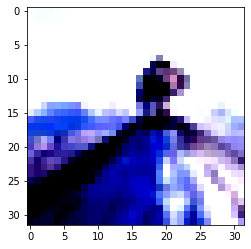

In [4]:
cifar100_train = datasets.CIFAR100(root = "data", 
                                   train = True, 
                                   download = False, 
                                   transform = transforms.Compose([
                                       ToTensor(), 
                                       #transforms.ConvertImageDtype(torch.float), 
                                       transforms.Normalize(
                                           mean = np.array([0.5070751592371323, 0.48654887331495095, 0.4409178433670343]), 
                                           std = np.array([0.2673342858792401, 0.2564384629170883, 0.27615047132568404]))]))
cifar100_test = datasets.CIFAR100(root = "data", 
                                  train = False, 
                                  download = False, 
                                  transform = transforms.Compose([
                                      ToTensor(), 
                                      #transforms.ConvertImageDtype(torch.float), 
                                      transforms.Normalize(
                                           mean = np.array([0.5070751592371323, 0.48654887331495095, 0.4409178433670343]), 
                                           std = np.array([0.2673342858792401, 0.2564384629170883, 0.27615047132568404]))]))

data_loader_train = torch.utils.data.DataLoader(cifar100_train,
                                                batch_size=batchsize,
                                                shuffle=True)
data_loader_test = torch.utils.data.DataLoader(cifar100_test,
                                                batch_size=batchsize,
                                                shuffle=True)

print(cifar100_test.classes)
plt.imshow(cifar100_test[0][0].permute(1,2,0))

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
!nvidia-smi

Using cuda device
Mon Nov 14 15:57:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.15       Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8     3W /  N/A |    323MiB /  6144MiB |     23%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                      

In [6]:
class BasicConv2d(nn.Module):

    def __init__(self, input_channels, output_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x

In [7]:
class InceptionA(nn.Module):

    def __init__(self, input_channels, pool_features):
        super().__init__()
        self.branch1x1 = BasicConv2d(input_channels, 64, kernel_size=1)

        self.branch5x5 = nn.Sequential(
            BasicConv2d(input_channels, 48, kernel_size=1),
            BasicConv2d(48, 64, kernel_size=5, padding=2)
        )

        self.branch3x3 = nn.Sequential(
            BasicConv2d(input_channels, 64, kernel_size=1),
            BasicConv2d(64, 96, kernel_size=3, padding=1),
            BasicConv2d(96, 96, kernel_size=3, padding=1)
        )

        self.branchpool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(input_channels, pool_features, kernel_size=3, padding=1)
        )

    def forward(self, x):

        #x -> 1x1(same)
        branch1x1 = self.branch1x1(x)

        #x -> 1x1 -> 5x5(same)
        branch5x5 = self.branch5x5(x)
        #branch5x5 = self.branch5x5_2(branch5x5)

        #x -> 1x1 -> 3x3 -> 3x3(same)
        branch3x3 = self.branch3x3(x)

        #x -> pool -> 1x1(same)
        branchpool = self.branchpool(x)

        outputs = [branch1x1, branch5x5, branch3x3, branchpool]

        return torch.cat(outputs, 1)

In [8]:
class InceptionB(nn.Module):

    def __init__(self, input_channels):
        super().__init__()

        self.branch3x3 = BasicConv2d(input_channels, 384, kernel_size=3, stride=2)

        self.branch3x3stack = nn.Sequential(
            BasicConv2d(input_channels, 64, kernel_size=1),
            BasicConv2d(64, 96, kernel_size=3, padding=1),
            BasicConv2d(96, 96, kernel_size=3, stride=2)
        )

        self.branchpool = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):

        #x - > 3x3(downsample)
        branch3x3 = self.branch3x3(x)

        #x -> 3x3 -> 3x3(downsample)
        branch3x3stack = self.branch3x3stack(x)

        #x -> avgpool(downsample)
        branchpool = self.branchpool(x)

        #"""We can use two parallel stride 2 blocks: P and C. P is a pooling
        #layer (either average or maximum pooling) the activation, both of
        #them are stride 2 the filter banks of which are concatenated as in
        #figure 10."""
        outputs = [branch3x3, branch3x3stack, branchpool]

        return torch.cat(outputs, 1)


In [9]:
class InceptionC(nn.Module):
    def __init__(self, input_channels, channels_7x7):
        super().__init__()
        self.branch1x1 = BasicConv2d(input_channels, 192, kernel_size=1)

        c7 = channels_7x7

        #In theory, we could go even further and argue that one can replace any n × n
        #convolution by a 1 × n convolution followed by a n × 1 convolution and the
        #computational cost saving increases dramatically as n grows (see figure 6).
        self.branch7x7 = nn.Sequential(
            BasicConv2d(input_channels, c7, kernel_size=1),
            BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(c7, 192, kernel_size=(1, 7), padding=(0, 3))
        )

        self.branch7x7stack = nn.Sequential(
            BasicConv2d(input_channels, c7, kernel_size=1),
            BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(c7, 192, kernel_size=(1, 7), padding=(0, 3))
        )

        self.branch_pool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(input_channels, 192, kernel_size=1),
        )

    def forward(self, x):

        #x -> 1x1(same)
        branch1x1 = self.branch1x1(x)

        #x -> 1layer 1*7 and 7*1 (same)
        branch7x7 = self.branch7x7(x)

        #x-> 2layer 1*7 and 7*1(same)
        branch7x7stack = self.branch7x7stack(x)

        #x-> avgpool (same)
        branchpool = self.branch_pool(x)

        outputs = [branch1x1, branch7x7, branch7x7stack, branchpool]

        return torch.cat(outputs, 1)

In [10]:
class InceptionD(nn.Module):

    def __init__(self, input_channels):
        super().__init__()

        self.branch3x3 = nn.Sequential(
            BasicConv2d(input_channels, 192, kernel_size=1),
            BasicConv2d(192, 320, kernel_size=3, stride=2)
        )

        self.branch7x7 = nn.Sequential(
            BasicConv2d(input_channels, 192, kernel_size=1),
            BasicConv2d(192, 192, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(192, 192, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(192, 192, kernel_size=3, stride=2)
        )

        self.branchpool = nn.AvgPool2d(kernel_size=3, stride=2)

    def forward(self, x):

        #x -> 1x1 -> 3x3(downsample)
        branch3x3 = self.branch3x3(x)

        #x -> 1x1 -> 1x7 -> 7x1 -> 3x3 (downsample)
        branch7x7 = self.branch7x7(x)

        #x -> avgpool (downsample)
        branchpool = self.branchpool(x)

        outputs = [branch3x3, branch7x7, branchpool]

        return torch.cat(outputs, 1)

In [11]:
class InceptionE(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.branch1x1 = BasicConv2d(input_channels, 320, kernel_size=1)

        self.branch3x3_1 = BasicConv2d(input_channels, 384, kernel_size=1)
        self.branch3x3_2a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3stack_1 = BasicConv2d(input_channels, 448, kernel_size=1)
        self.branch3x3stack_2 = BasicConv2d(448, 384, kernel_size=3, padding=1)
        self.branch3x3stack_3a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3stack_3b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(input_channels, 192, kernel_size=1)
        )

    def forward(self, x):

        #x -> 1x1 (same)
        branch1x1 = self.branch1x1(x)

        # x -> 1x1 -> 3x1
        # x -> 1x1 -> 1x3
        # concatenate(3x1, 1x3)
        #"""7. Inception modules with expanded the filter bank outputs.
        #This architecture is used on the coarsest (8 × 8) grids to promote
        #high dimensional representations, as suggested by principle
        #2 of Section 2."""
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3)
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        # x -> 1x1 -> 3x3 -> 1x3
        # x -> 1x1 -> 3x3 -> 3x1
        #concatenate(1x3, 3x1)
        branch3x3stack = self.branch3x3stack_1(x)
        branch3x3stack = self.branch3x3stack_2(branch3x3stack)
        branch3x3stack = [
            self.branch3x3stack_3a(branch3x3stack),
            self.branch3x3stack_3b(branch3x3stack)
        ]
        branch3x3stack = torch.cat(branch3x3stack, 1)

        branchpool = self.branch_pool(x)

        outputs = [branch1x1, branch3x3, branch3x3stack, branchpool]

        return torch.cat(outputs, 1)

In [12]:
class InceptionV3(nn.Module):

    def __init__(self, num_classes=100):
        super().__init__()
        self.Conv2d_1a_3x3 = BasicConv2d(3, 32, kernel_size=3, padding=1)
        self.Conv2d_2a_3x3 = BasicConv2d(32, 32, kernel_size=3, padding=1)
        self.Conv2d_2b_3x3 = BasicConv2d(32, 64, kernel_size=3, padding=1)
        self.Conv2d_3b_1x1 = BasicConv2d(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = BasicConv2d(80, 192, kernel_size=3)

        #naive inception module
        self.Mixed_5b = InceptionA(192, pool_features=32)
        self.Mixed_5c = InceptionA(256, pool_features=64)
        self.Mixed_5d = InceptionA(288, pool_features=64)

        #downsample
        self.Mixed_6a = InceptionB(288)

        self.Mixed_6b = InceptionC(768, channels_7x7=128)
        self.Mixed_6c = InceptionC(768, channels_7x7=160)
        self.Mixed_6d = InceptionC(768, channels_7x7=160)
        self.Mixed_6e = InceptionC(768, channels_7x7=192)

        #downsample
        self.Mixed_7a = InceptionD(768)

        self.Mixed_7b = InceptionE(1280)
        self.Mixed_7c = InceptionE(2048)

        #6*6 feature size
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout2d()
        self.linear = nn.Linear(2048, num_classes)

    def forward(self, x):

        #32 -> 30
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)

        #30 -> 30
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)

        #30 -> 14
        #Efficient Grid Size Reduction to avoid representation
        #bottleneck
        x = self.Mixed_6a(x)

        #14 -> 14
        #"""In practice, we have found that employing this factorization does not
        #work well on early layers, but it gives very good results on medium
        #grid-sizes (On m × m feature maps, where m ranges between 12 and 20).
        #On that level, very good results can be achieved by using 1 × 7 convolutions
        #followed by 7 × 1 convolutions."""
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)

        #14 -> 6
        #Efficient Grid Size Reduction
        x = self.Mixed_7a(x)

        #6 -> 6
        #We are using this solution only on the coarsest grid,
        #since that is the place where producing high dimensional
        #sparse representation is the most critical as the ratio of
        #local processing (by 1 × 1 convolutions) is increased compared
        #to the spatial aggregation."""
        x = self.Mixed_7b(x)
        x = self.Mixed_7c(x)

        #6 -> 1
        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x


def inceptionv3():
    return InceptionV3()

In [13]:
class FKernelforInceptionv3():
    def __init__(self):
        self.basic_weight_3x3 = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]
        self.basic_weight_5x5 = [[0, 0, 0, 0, 0], [0, 1, 1, 1, 0], [0, 1, 1, 1, 0], [0, 1, 1, 1, 0], [0, 0, 0, 0, 0]]
        self.basic_weight_7x1 = [[0], [1], [1], [1], [1], [1], [0]]
        self.basic_weight_1x7 = [[0, 1, 1, 1, 1, 1, 0]]
        self.basic_weight_3x1 = [[0], [1], [0]]
        self.basic_weight_1x3 = [[0, 1, 0]]
        
        
        self.g_tensor_32x3x3x3 = [[self.basic_weight_3x3 for p in range(3)] for q in range(32)]
        self.g_tensor_32x3x3x3 = torch.tensor(self.g_tensor_32x3x3x3, dtype=torch.float)
        
        self.g_tensor_32x32x3x3 = [[self.basic_weight_3x3 for p in range(32)] for q in range(32)]
        self.g_tensor_32x32x3x3 = torch.tensor(self.g_tensor_32x32x3x3, dtype=torch.float)
        
        self.g_tensor_64x32x3x3 = [[self.basic_weight_3x3 for p in range(32)] for q in range(64)]
        self.g_tensor_64x32x3x3 = torch.tensor(self.g_tensor_64x32x3x3, dtype=torch.float)
        
        self.g_tensor_192x80x3x3 = [[self.basic_weight_3x3 for p in range(80)] for q in range(192)]
        self.g_tensor_192x80x3x3 = torch.tensor(self.g_tensor_192x80x3x3, dtype=torch.float)
        
        self.g_tensor_64x48x5x5 = [[self.basic_weight_5x5 for p in range(48)] for q in range(64)]
        self.g_tensor_64x48x5x5 = torch.tensor(self.g_tensor_64x48x5x5, dtype=torch.float)
        
        self.g_tensor_96x64x3x3 = [[self.basic_weight_3x3 for p in range(64)] for q in range(96)]
        self.g_tensor_96x64x3x3 = torch.tensor(self.g_tensor_96x64x3x3, dtype=torch.float)
        
        self.g_tensor_96x96x3x3 = [[self.basic_weight_3x3 for p in range(96)] for q in range(96)]
        self.g_tensor_96x96x3x3 = torch.tensor(self.g_tensor_96x96x3x3, dtype=torch.float)
        
        self.g_tensor_32x192x3x3 = [[self.basic_weight_3x3 for p in range(192)] for q in range(32)]
        self.g_tensor_32x192x3x3 = torch.tensor(self.g_tensor_32x192x3x3, dtype=torch.float)
        
        self.g_tensor_64x256x3x3 = [[self.basic_weight_3x3 for p in range(256)] for q in range(64)]
        self.g_tensor_64x256x3x3 = torch.tensor(self.g_tensor_64x256x3x3, dtype=torch.float)
        
        self.g_tensor_64x288x3x3 = [[self.basic_weight_3x3 for p in range(288)] for q in range(64)]
        self.g_tensor_64x288x3x3 = torch.tensor(self.g_tensor_64x288x3x3, dtype=torch.float)
        
        self.g_tensor_384x288x3x3 = [[self.basic_weight_3x3 for p in range(288)] for q in range(384)]
        self.g_tensor_384x288x3x3 = torch.tensor(self.g_tensor_384x288x3x3, dtype=torch.float)
        
        self.g_tensor_128x128x7x1 = [[self.basic_weight_7x1 for p in range(128)] for q in range(128)]
        self.g_tensor_128x128x7x1 = torch.tensor(self.g_tensor_128x128x7x1, dtype=torch.float)
        
        self.g_tensor_192x128x1x7 = [[self.basic_weight_1x7 for p in range(128)] for q in range(192)]
        self.g_tensor_192x128x1x7 = torch.tensor(self.g_tensor_192x128x1x7, dtype=torch.float)
        
        self.g_tensor_128x128x1x7 = [[self.basic_weight_1x7 for p in range(128)] for q in range(128)]
        self.g_tensor_128x128x1x7 = torch.tensor(self.g_tensor_128x128x1x7, dtype=torch.float)
        
        self.g_tensor_160x160x7x1 = [[self.basic_weight_7x1 for p in range(160)] for q in range(160)]
        self.g_tensor_160x160x7x1 = torch.tensor(self.g_tensor_160x160x7x1, dtype=torch.float)

        self.g_tensor_192x160x1x7 = [[self.basic_weight_1x7 for p in range(160)] for q in range(192)]
        self.g_tensor_192x160x1x7 = torch.tensor(self.g_tensor_192x160x1x7, dtype=torch.float)
        
        self.g_tensor_160x160x1x7 = [[self.basic_weight_1x7 for p in range(160)] for q in range(160)]
        self.g_tensor_160x160x1x7 = torch.tensor(self.g_tensor_160x160x1x7, dtype=torch.float)
        
        self.g_tensor_192x192x7x1 = [[self.basic_weight_7x1 for p in range(192)] for q in range(192)]
        self.g_tensor_192x192x7x1 = torch.tensor(self.g_tensor_192x192x7x1, dtype=torch.float)

        self.g_tensor_192x192x1x7 = [[self.basic_weight_1x7 for p in range(192)] for q in range(192)]
        self.g_tensor_192x192x1x7 = torch.tensor(self.g_tensor_192x192x1x7, dtype=torch.float)
        
        self.g_tensor_320x192x3x3 = [[self.basic_weight_3x3 for p in range(192)] for q in range(320)]
        self.g_tensor_320x192x3x3 = torch.tensor(self.g_tensor_320x192x3x3, dtype=torch.float)
        
        self.g_tensor_192x192x3x3 = [[self.basic_weight_3x3 for p in range(192)] for q in range(192)]
        self.g_tensor_192x192x3x3 = torch.tensor(self.g_tensor_192x192x3x3, dtype=torch.float)
        
        self.g_tensor_384x384x1x3 = [[self.basic_weight_1x3 for p in range(384)] for q in range(384)]
        self.g_tensor_384x384x1x3 = torch.tensor(self.g_tensor_384x384x1x3, dtype=torch.float)
        
        self.g_tensor_384x384x3x1 = [[self.basic_weight_3x1 for p in range(384)] for q in range(384)]
        self.g_tensor_384x384x3x1 = torch.tensor(self.g_tensor_384x384x3x1, dtype=torch.float)
        
        self.g_tensor_384x448x3x3 = [[self.basic_weight_3x3 for p in range(448)] for q in range(384)]
        self.g_tensor_384x448x3x3 = torch.tensor(self.g_tensor_384x448x3x3, dtype=torch.float)

    def forward(self, net, device):
        custom_loss = 0
        num_conv = -1

        for param in net.parameters():
            num_conv = num_conv + 1
            
            param_ = param.to("cpu")
            if num_conv == 0:
                modify = param_ - self.g_tensor_32x3x3x3
            if num_conv == 3:
                modify = param_ - self.g_tensor_32x32x3x3
            if num_conv == 6:
                modify = param_ - self.g_tensor_64x32x3x3
            if num_conv == 12:
                modify = param_ - self.g_tensor_192x80x3x3
            if num_conv == 21 or num_conv == 42 or num_conv == 63:
                modify = param_ - self.g_tensor_64x48x5x5
            if num_conv == 27 or num_conv == 48 or num_conv == 69 or num_conv == 84:
                modify = param_ - self.g_tensor_96x64x3x3
            if num_conv == 30 or num_conv == 51 or num_conv == 72 or num_conv == 87:
                modify = param_ - self.g_tensor_96x96x3x3
            if num_conv == 33:
#              print(param_)
                modify = param_ - self.g_tensor_32x192x3x3 
            if num_conv == 54:
                modify = param_ - self.g_tensor_64x256x3x3 
            if num_conv == 75:
                modify = param_ - self.g_tensor_64x288x3x3 
            if num_conv == 78:
                modify = param_ - self.g_tensor_384x288x3x3 
            if num_conv == 96 or num_conv == 105 or num_conv == 111:
                modify = param_ - self.g_tensor_128x128x7x1 
            if num_conv == 99 or num_conv == 114:
                modify = param_ - self.g_tensor_192x128x1x7 
            if num_conv == 108:
                modify = param_ - self.g_tensor_128x128x1x7 
            if num_conv == 126 or num_conv == 135 or num_conv == 141 or num_conv == 156 or num_conv == 165 or num_conv == 171:
                modify = param_ - self.g_tensor_160x160x7x1 
            if num_conv == 129 or num_conv == 144 or num_conv == 159 or num_conv == 174:
                modify = param_ - self.g_tensor_192x160x1x7 
            if num_conv == 138 or num_conv == 168:
                modify = param_ - self.g_tensor_160x160x1x7 
            if num_conv == 186 or num_conv == 195 or num_conv == 201 or num_conv == 222:
                modify = param_ - self.g_tensor_192x192x7x1 
            if num_conv == 189 or num_conv == 198 or num_conv == 204 or num_conv == 219:
                modify = param_ - self.g_tensor_192x192x1x7 
            if num_conv == 213:
                modify = param_ - self.g_tensor_320x192x3x3 
            if num_conv == 225:
                modify = param_ - self.g_tensor_192x192x3x3 
            if num_conv == 234 or num_conv == 246 or num_conv == 261 or num_conv == 273:
                modify = param_ - self.g_tensor_384x384x1x3 
            if num_conv == 237 or num_conv == 249 or num_conv == 264 or num_conv == 276:
                modify = param_ - self.g_tensor_384x384x3x1 
            if num_conv == 243 or num_conv == 270:
                modify = param_ - self.g_tensor_384x448x3x3 
                
                
                
#            print(modify)
#                target_weight = g_tensor
#                target_weight = target_weight.to(device)
#            print(num_conv, param.shape)
#            custom_loss = 1
#                modify = param_ - g_tensor
#                print(modify)
            custom_loss += torch.sum(torch.norm(modify, p = 2).pow(2))
#                print(custom_loss)
        return custom_loss

In [14]:
def text_save(filename, data1):#filename为写入CSV文件的路径，data为要写入数据列表.
    file = open(filename,'a')
    for i in range(len(data1)):
        s1 = str(data1[i]).replace('[','').replace(']','')#去除[],这两行按数据不同，可以选择
        s1 = s1.replace("'",'').replace(',','') +'\n' #去除单引号，逗号，每行末尾追加换行符
        file.write(s1)
#    for i in range(len(data2)):
#        s2 = str(data2[i]).replace('[','').replace(']','')#去除[],这两行按数据不同，可以选择
#        s2 = s2.replace("'",'').replace(',','') +'\n' #去除单引号，逗号，每行末尾追加换行符
#        file.write(s2)
    file.close()
    print("保存成功")

In [14]:
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed_all(100)
#random.seed(100)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.enabled = True

net = inceptionv3()
#net.load_state_dict(torch.load(PATH))
#net.eval()
checkpoint = torch.load("39Iv3C.ckpt")
net.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
net.eval()
net = net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=momentum, weight_decay=weight_decay, nesterov=True)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


train_acc = []
valid_acc = []
train_loss_array = []
valid_loss_array = []
custom_loss_array = []
criterion = nn.CrossEntropyLoss()
#lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,steps_per_epoch=len(data_loader_train),
#                                                   epochs=num_epoch,div_factor=div_factor,final_div_factor=final_div,pct_start=pct_start)

#target_weight = torch.tensor(0)
#target_weight = target_weight.to(device)
FKernelforInceptionv3_ = FKernelforInceptionv3()

def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    train_classify_loss = 0
    train_custom_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(data_loader_train):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        classify_loss = criterion(outputs, targets)
        custom_loss = FKernelforInceptionv3_.forward(net,device)
        train_classify_loss += classify_loss.item()
        train_custom_loss += 0.00000002 * custom_loss.item()
        print(train_classify_loss/(batch_idx+1), '|', train_custom_loss/(batch_idx+1))
#        if custom_loss < 10000:
#            mode = 1
#        if mode == 0:
        loss = classify_loss + 0.00000002 * custom_loss
#        else:
#        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
#        lr_scheduler.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        print(batch_idx, '|', len(data_loader_train), '|', train_loss/(batch_idx+1), '|', 100.*correct/total)
#        progress_bar(batch_idx, len(data_loader_train), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    train_acc.append(correct/total)
    train_loss_array.append(train_loss/len(data_loader_train))
    custom_loss_array.append(train_custom_loss/len(data_loader_train))
    model_state_path = str(epoch + 40) + "Iv3C.ckpt"
    torch.save({
       'epoch': epoch,
       'model_state_dict': net.state_dict(),
       'optimizer_state_dict': optimizer.state_dict(),
       'loss': loss,
      }, model_state_path)

def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(data_loader_test):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        print(batch_idx, '|', len(data_loader_test), '|', test_loss/(batch_idx+1), '|', 100.*correct/total)
#        progress_bar(batch_idx, len(data_loader_test), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    valid_acc.append(correct/total)
    valid_loss_array.append(test_loss/len(data_loader_test))
    
for epoch in range(num_epoch):
    train(epoch)
    test(epoch)

print("Best test accuracy: {}".format(max(valid_acc)))
#torch.save(net.state_dict(), "10I.pth")
text_save("data50Iv3Ctrain_acc.txt", train_acc)
text_save("data50Iv3Cvalid_acc.txt", valid_acc)
text_save("data50Iv3Ctrainloss.txt", train_loss_array)
text_save("data50Iv3Cvalidloss.txt", valid_loss_array)
text_save("data50Iv3Ccustomloss.txt", custom_loss_array)


Epoch: 0
0.534711480140686 | 0.56000472
0 | 1563 | 1.094716191291809 | 81.25
0.7155529856681824 | 0.5600047
1 | 1563 | 1.2755576968193054 | 75.0
0.7129503091176351 | 0.5600044533333334
2 | 1563 | 1.2729547421137493 | 77.08333333333333
0.6732711642980576 | 0.56000417
3 | 1563 | 1.2332753241062164 | 79.6875
0.6737580180168152 | 0.560003952
4 | 1563 | 1.2337619543075562 | 79.375
0.7351533472537994 | 0.5600037800000001
5 | 1563 | 1.2951571146647136 | 76.5625
0.727414437702724 | 0.5600036342857143
6 | 1563 | 1.2874180589403426 | 75.44642857142857
0.6881909742951393 | 0.5600034650000001
7 | 1563 | 1.2481944262981415 | 77.734375
0.6786748038397895 | 0.5600032755555557
8 | 1563 | 1.2386780579884846 | 77.43055555555556
0.6723468124866485 | 0.5600031320000001
9 | 1563 | 1.2323499202728272 | 77.8125
0.6648142391985113 | 0.5600029636363637
10 | 1563 | 1.2248171784661033 | 78.97727272727273
0.6683156341314316 | 0.5600028100000001
11 | 1563 | 1.2283184230327606 | 79.42708333333333
0.680803280610304

94 | 1563 | 1.2123033360431068 | 79.80263157894737
0.6547848833724856 | 0.5599939858333336
95 | 1563 | 1.214778867860635 | 79.75260416666667
0.6550788556792072 | 0.5599938272164952
96 | 1563 | 1.2150726809944075 | 79.70360824742268
0.6567735030334823 | 0.559993659591837
97 | 1563 | 1.2167671602599475 | 79.52806122448979
0.6551680610035405 | 0.5599934941414144
98 | 1563 | 1.2151615523328685 | 79.60858585858585
0.6532091519236565 | 0.5599933388000002
99 | 1563 | 1.2132024884223938 | 79.71875
0.6508244160968478 | 0.5599931825742577
100 | 1563 | 1.210817596109787 | 79.79579207920793
0.6500216830594867 | 0.5599930329411767
101 | 1563 | 1.2100147131611318 | 79.77941176470588
0.6477096957489125 | 0.5599928854368935
102 | 1563 | 1.207702578271477 | 79.88470873786407
0.6470788416381066 | 0.5599927353846156
103 | 1563 | 1.2070715742615552 | 79.92788461538461
0.6466631523200443 | 0.5599925843809527
104 | 1563 | 1.2066557333582923 | 79.9702380952381
0.6511530614686463 | 0.5599924252830191
105 | 15

185 | 1563 | 1.1941197440829328 | 80.54435483870968
0.634047772715436 | 0.5599852254545458
186 | 1563 | 1.1940329964148169 | 80.51470588235294
0.6329745490975837 | 0.5599852048936174
187 | 1563 | 1.1929597521715976 | 80.5684840425532
0.6319257889002089 | 0.5599851809523813
188 | 1563 | 1.1919109679403759 | 80.62169312169313
0.6343771003578839 | 0.5599851530526319
189 | 1563 | 1.1943622510684164 | 80.50986842105263
0.6340704080478059 | 0.5599851212565449
190 | 1563 | 1.1940555269805548 | 80.49738219895288
0.6350013176755359 | 0.5599850875000003
191 | 1563 | 1.194986402677993 | 80.46875
0.6342623080151069 | 0.5599850499481869
192 | 1563 | 1.1942473554240607 | 80.50518134715026
0.6358007522127063 | 0.5599850098969075
193 | 1563 | 1.1957857593433143 | 80.49291237113403
0.6359705922695307 | 0.5599849698461542
194 | 1563 | 1.1959555592292395 | 80.46474358974359
0.6365129781164685 | 0.5599849248979596
195 | 1563 | 1.1964979004494998 | 80.42091836734694
0.637646322701183 | 0.5599848840609141
1

0.6685453841079443 | 0.559981580361011
276 | 1563 | 1.2285269612870062 | 79.55776173285199
0.6690624980724973 | 0.5599815559712231
277 | 1563 | 1.229044050835877 | 79.55260791366906
0.670799855102775 | 0.5599815317562725
278 | 1563 | 1.2307813836254955 | 79.49148745519713
0.6716056683765991 | 0.5599815101428572
279 | 1563 | 1.2315871751734189 | 79.47544642857143
0.6723936211278005 | 0.5599814929537368
280 | 1563 | 1.232375110807792 | 79.44839857651246
0.6731106072981307 | 0.55998148
281 | 1563 | 1.2330920837872417 | 79.43262411347517
0.6762745014454367 | 0.5599814681272086
282 | 1563 | 1.2362559665218258 | 79.38383392226149
0.6765584820278094 | 0.5599814604225353
283 | 1563 | 1.2365399395496073 | 79.39040492957747
0.676389640308263 | 0.5599814517894738
284 | 1563 | 1.2363710894919278 | 79.40789473684211
0.677080267844917 | 0.5599814478321679
285 | 1563 | 1.2370617129169144 | 79.38155594405595
0.6765200888757507 | 0.5599814429268293
286 | 1563 | 1.2365015290340065 | 79.3880662020906
0.6

366 | 1563 | 1.2519023754616199 | 78.84025885558583
0.6928448670989146 | 0.5599823333695649
367 | 1563 | 1.2528271968274012 | 78.82982336956522
0.692754211504931 | 0.5599823567479673
368 | 1563 | 1.2527365647357331 | 78.81944444444444
0.693043647142681 | 0.5599823775135133
369 | 1563 | 1.253026021010167 | 78.81756756756756
0.6927002908164921 | 0.5599823990296493
370 | 1563 | 1.2526826860127103 | 78.82412398921834
0.6934420814517365 | 0.5599824204301073
371 | 1563 | 1.253424497862016 | 78.8138440860215
0.6932254504342501 | 0.5599824433243965
372 | 1563 | 1.2532078895428225 | 78.82037533512064
0.6925897263986541 | 0.5599824668449195
373 | 1563 | 1.2525721891997332 | 78.8519385026738
0.6930170596837998 | 0.5599824902399997
374 | 1563 | 1.2529995458920797 | 78.83333333333333
0.6925454923209358 | 0.559982512978723
375 | 1563 | 1.252528001494864 | 78.83976063829788
0.694204365898823 | 0.5599825347480103
376 | 1563 | 1.254186896967951 | 78.80470822281167
0.6945155985535137 | 0.559982555026454

456 | 1563 | 1.2705007706742317 | 78.33014223194748
0.7105660431054481 | 0.5599840732751089
457 | 1563 | 1.2705501111053483 | 78.3160480349345
0.7104403562600317 | 0.5599840894117645
458 | 1563 | 1.2704244404057272 | 78.32244008714596
0.7105103130249873 | 0.5599841046086954
459 | 1563 | 1.2704944124688273 | 78.31521739130434
0.7110433907221817 | 0.5599841180043382
460 | 1563 | 1.2710275035876772 | 78.31480477223427
0.7109163505754945 | 0.5599841286580085
461 | 1563 | 1.2709004740952414 | 78.321158008658
0.7111799342650317 | 0.5599841380561553
462 | 1563 | 1.2711640672343854 | 78.30723542116631
0.7120512758927613 | 0.559984146637931
463 | 1563 | 1.272035417500241 | 78.29337284482759
0.7118156188598244 | 0.559984154064516
464 | 1563 | 1.2717997680428208 | 78.30645161290323
0.7132604640504833 | 0.5599841629184549
465 | 1563 | 1.273244622055553 | 78.2658261802575
0.7136763557951251 | 0.5599841723340471
466 | 1563 | 1.2736605230950186 | 78.23875802997858
0.7141274267600642 | 0.5599841827350

547 | 1563 | 1.2836319882504261 | 78.18202554744525
0.7240455660609383 | 0.5599863985428049
548 | 1563 | 1.2840319609164323 | 78.17622950819673
0.7240652230381965 | 0.559986408872727
549 | 1563 | 1.284051628112793 | 78.18181818181819
0.7235155614826511 | 0.5599864177858437
550 | 1563 | 1.283501975441152 | 78.19872958257713
0.7238372976527266 | 0.5599864254347824
551 | 1563 | 1.2838237193831499 | 78.1929347826087
0.7243657672329794 | 0.5599864320433994
552 | 1563 | 1.2843521955215909 | 78.17020795660036
0.7245608599123542 | 0.5599864368953066
553 | 1563 | 1.284547293121634 | 78.16448555956678
0.7247793673126547 | 0.5599864410090087
554 | 1563 | 1.2847658046731003 | 78.14752252252252
0.7245976432568306 | 0.5599864461870501
555 | 1563 | 1.284584085825536 | 78.15872302158273
0.7246726242761852 | 0.5599864504847394
556 | 1563 | 1.2846590711783679 | 78.15866247755835
0.7246163580099314 | 0.5599864559139782
557 | 1563 | 1.284602810298243 | 78.16980286738351
0.7243889094412007 | 0.559986461252

637 | 1563 | 1.3066965282710743 | 77.51763322884013
0.7465633920893796 | 0.5599863057902973
638 | 1563 | 1.306549695455972 | 77.52836463223787
0.7470383037114516 | 0.5599863263125
639 | 1563 | 1.3070246276445687 | 77.509765625
0.7470047310482879 | 0.5599863466458659
640 | 1563 | 1.3069910752977856 | 77.52535101404057
0.7467932453454469 | 0.5599863679750778
641 | 1563 | 1.306779611054982 | 77.53115264797508
0.7467162177360632 | 0.5599863900466563
642 | 1563 | 1.3067026055804678 | 77.52721617418351
0.7464760874415407 | 0.5599864135403727
643 | 1563 | 1.3064624988329336 | 77.54270186335404
0.7468920158092366 | 0.5599864384496124
644 | 1563 | 1.3068784520607586 | 77.52422480620154
0.7472891160993385 | 0.5599864644582043
645 | 1563 | 1.3072755782412302 | 77.515479876161
0.7472139379755238 | 0.5599864911901081
646 | 1563 | 1.3072004269411244 | 77.51642194744977
0.7476320793093355 | 0.5599865179012345
647 | 1563 | 1.307618595107838 | 77.51253858024691
0.7475779407610328 | 0.5599865463790447
6

0.7569536494987982 | 0.5599892062002745
728 | 1563 | 1.3169428536103749 | 77.37911522633745
0.7568695217983363 | 0.5599892431780824
729 | 1563 | 1.3168587628292712 | 77.38441780821918
0.75718779482773 | 0.5599892809302327
730 | 1563 | 1.317177073492397 | 77.37260601915185
0.756817482635786 | 0.5599893194535521
731 | 1563 | 1.3168067998084865 | 77.38644125683061
0.7571377304737109 | 0.5599893584174627
732 | 1563 | 1.3171270866999034 | 77.37465893587995
0.7573330513828457 | 0.5599893970572208
733 | 1563 | 1.3173224462312962 | 77.36290871934605
0.7569139646226857 | 0.5599894354285716
734 | 1563 | 1.3169033979072051 | 77.38095238095238
0.7569758211991385 | 0.5599894748913045
735 | 1563 | 1.3169652940300496 | 77.38196331521739
0.7568621536163332 | 0.5599895143012213
736 | 1563 | 1.3168516658054439 | 77.39569199457259
0.7573420952369527 | 0.5599895529539297
737 | 1563 | 1.3173316461122455 | 77.39244579945799
0.7570090329574474 | 0.55998959014885
738 | 1563 | 1.3169986210430749 | 77.401894451

0.7696437476355223 | 0.5599917085714289
818 | 1563 | 1.329635453966511 | 77.03754578754578
0.7699233467440779 | 0.559991735170732
819 | 1563 | 1.3299150796198262 | 77.03125
0.7702131976490334 | 0.5599917620950063
820 | 1563 | 1.3302049573678774 | 77.02877588306943
0.7706256126871655 | 0.5599917891484187
821 | 1563 | 1.33061739947384 | 77.01490267639903
0.7704200775227888 | 0.5599918165735118
822 | 1563 | 1.3304118916736338 | 77.02384568651276
0.7705234910714106 | 0.5599918441747577
823 | 1563 | 1.330515332809351 | 77.0289745145631
0.7707423397447124 | 0.5599918716121216
824 | 1563 | 1.3307342089306224 | 77.03030303030303
0.7707128331570302 | 0.559991899564165
825 | 1563 | 1.330704730229574 | 77.03162832929782
0.770522707985419 | 0.5599919277388153
826 | 1563 | 1.330514633309596 | 77.03295042321645
0.7707094548153128 | 0.5599919557487926
827 | 1563 | 1.3307014081069237 | 77.02294685990339
0.7706213559150984 | 0.5599919834499401
828 | 1563 | 1.3306133369628712 | 77.02427623642943
0.77070

908 | 1563 | 1.3415852531348125 | 76.67766776677668
0.7816964655295833 | 0.5599931401318685
909 | 1563 | 1.3416896033418046 | 76.67239010989012
0.7817711552234957 | 0.5599931552579587
910 | 1563 | 1.3417643081605368 | 76.67741492864984
0.7817075319359439 | 0.5599931705263161
911 | 1563 | 1.3417007002260601 | 76.67214912280701
0.7816846202426515 | 0.5599931860240968
912 | 1563 | 1.341677804048064 | 76.68400876232201
0.7818039610199385 | 0.5599932020568932
913 | 1563 | 1.3417971608284005 | 76.68216630196936
0.7817035274590299 | 0.5599932188852463
914 | 1563 | 1.341696744082404 | 76.68374316939891
0.7817971514594867 | 0.5599932365502188
915 | 1563 | 1.3417903858371176 | 76.67849344978166
0.7817632138826595 | 0.5599932556161401
916 | 1563 | 1.341756467275817 | 76.68007088331515
0.7813960966493829 | 0.5599932764705887
917 | 1563 | 1.3413893708346456 | 76.6952614379085
0.7813459741310403 | 0.5599932998041355
918 | 1563 | 1.341339271592627 | 76.69341675734493
0.781562000853212 | 0.55999332395

998 | 1563 | 1.355114195499573 | 76.31068568568568
0.7956558736711741 | 0.55999503588
999 | 1563 | 1.3556509072184562 | 76.2875
0.7961802714979732 | 0.5599950577822178
1000 | 1563 | 1.3561753268603916 | 76.27372627372627
0.7963096869592657 | 0.5599950811576847
1001 | 1563 | 1.3563047656399048 | 76.2630988023952
0.7963149867439318 | 0.5599951041674976
1002 | 1563 | 1.356310088458589 | 76.2649551345962
0.7965749587819159 | 0.5599951263745021
1003 | 1563 | 1.3565700827723006 | 76.25124501992032
0.7966111177383963 | 0.5599951484577116
1004 | 1563 | 1.3566062637229463 | 76.25932835820896
0.796668287848028 | 0.5599951699005966
1005 | 1563 | 1.356663455249775 | 76.25497017892644
0.7971290499859793 | 0.559995190506455
1006 | 1563 | 1.3571242379929127 | 76.24751737835155
0.7972461319425039 | 0.5599952106746032
1007 | 1563 | 1.3572413401589507 | 76.24317956349206
0.7974794990391396 | 0.5599952301288406
1008 | 1563 | 1.3574747267161653 | 76.22955896927651
0.7975569933505342 | 0.5599952498217823
1

1087 | 1563 | 1.3681879523484146 | 75.93922334558823
0.8085140418004727 | 0.5599974471258035
1088 | 1563 | 1.368511486316187 | 75.93262167125803
0.8087733548852282 | 0.5599974828990825
1089 | 1563 | 1.3687708351590218 | 75.9288990825688
0.8089356088753035 | 0.5599975184601282
1090 | 1563 | 1.3689331247869923 | 75.92231897341888
0.8087647718414938 | 0.5599975553479852
1091 | 1563 | 1.3687623245812162 | 75.9271978021978
0.8089356285682645 | 0.559997592461116
1092 | 1563 | 1.36893321839583 | 75.92349039341262
0.809176844219512 | 0.5599976301645336
1093 | 1563 | 1.3691744718298833 | 75.90836380255942
0.8093895101792192 | 0.5599976684566208
1094 | 1563 | 1.3693871760477214 | 75.89897260273973
0.8096651050540871 | 0.559997707518248
1095 | 1563 | 1.3696628099810468 | 75.89244981751825
0.8098833877847971 | 0.5599977463628074
1096 | 1563 | 1.3698811315903363 | 75.8859389243391
0.8100962219369651 | 0.5599977872495444
1097 | 1563 | 1.370094006613087 | 75.87374772313296
0.8098256956375762 | 0.5599

1176 | 1563 | 1.3801480731218674 | 75.56552676295667
0.8205729847068698 | 0.5600010118505939
1177 | 1563 | 1.3805739938302033 | 75.55443548387096
0.8204706457962516 | 0.5600010523494483
1178 | 1563 | 1.380471695470446 | 75.55661577608143
0.8205504568072699 | 0.5600010934576268
1179 | 1563 | 1.3805515475192311 | 75.55349576271186
0.8207721322724417 | 0.5600011339204061
1180 | 1563 | 1.3807732634984469 | 75.54508890770533
0.8206565489144696 | 0.5600011738071063
1181 | 1563 | 1.3806577200816972 | 75.5525592216582
0.8212829416244593 | 0.5600012136263733
1182 | 1563 | 1.381284152665384 | 75.53095942519019
0.8213694073587052 | 0.5600012530067565
1183 | 1563 | 1.381370657803239 | 75.52787162162163
0.8212548363183622 | 0.560001291476793
1184 | 1563 | 1.3812561252449131 | 75.52742616033755
0.8211058790954129 | 0.5600013296458684
1185 | 1563 | 1.3811072061878031 | 75.53225126475549
0.8213966733006338 | 0.5600013667396797
1186 | 1563 | 1.3813980374902664 | 75.52653748946925
0.8213608531463227 | 0

1265 | 1563 | 1.3850842467134032 | 75.33817140600316
0.825074740007061 | 0.5600046551539068
1266 | 1563 | 1.3850793927413982 | 75.33297158642462
0.8251829043806351 | 0.5600046967823343
1267 | 1563 | 1.385187598762076 | 75.33024447949526
0.8259328879809361 | 0.5600047377462569
1268 | 1563 | 1.3859376234271754 | 75.31028368794327
0.8257605738409861 | 0.5600047788661418
1269 | 1563 | 1.385765350475086 | 75.31003937007874
0.8255719586937189 | 0.5600048194807238
1270 | 1563 | 1.385576775981909 | 75.31963021243115
0.8258194483746335 | 0.5600048598742138
1271 | 1563 | 1.3858243060655564 | 75.31200864779875
0.826061140608338 | 0.5600048994501178
1272 | 1563 | 1.3860660378893623 | 75.30194422623724
0.8263088551640885 | 0.5600049377394034
1273 | 1563 | 1.3863137907566419 | 75.2918956043956
0.8260838519241296 | 0.5600049749333332
1274 | 1563 | 1.3860888246928944 | 75.29901960784314
0.8260246438082296 | 0.5600050122257053
1275 | 1563 | 1.3860296539284966 | 75.30368338557994
0.8259181592995615 | 0.

1354 | 1563 | 1.3911730679638712 | 75.20064575645756
0.8314303554770341 | 0.5600072705014751
1355 | 1563 | 1.3914376240124744 | 75.19588864306785
0.8315897026897443 | 0.5600072934119383
1356 | 1563 | 1.391596994113641 | 75.19113854089905
0.8317913788210309 | 0.5600073164359354
1357 | 1563 | 1.391798693275241 | 75.18869661266568
0.8316526239171811 | 0.5600073392788818
1358 | 1563 | 1.3916599612362337 | 75.19085724797645
0.8315576358643525 | 0.5600073623529414
1359 | 1563 | 1.3915649963214116 | 75.19301470588235
0.8316293097238695 | 0.5600073855400443
1360 | 1563 | 1.3916366933725233 | 75.1905767817781
0.8317783452056228 | 0.5600074091336272
1361 | 1563 | 1.3917857524494417 | 75.18355359765052
0.8317193047294525 | 0.5600074327806313
1362 | 1563 | 1.3917267356212752 | 75.18112619222303
0.831814445172849 | 0.560007456334311
1363 | 1563 | 1.3918218995906042 | 75.18099340175954
0.8320874411435354 | 0.5600074788571431
1364 | 1563 | 1.3920949180920918 | 75.17628205128206
0.831912385804325 | 0.

1443 | 1563 | 1.3984584404243328 | 74.95455332409972
0.8382476662991368 | 0.5600087628512112
1444 | 1563 | 1.3982564274002525 | 74.96107266435986
0.8382371503184775 | 0.5600087738035963
1445 | 1563 | 1.398245922386399 | 74.96109958506224
0.838444311689243 | 0.5600087844367658
1446 | 1563 | 1.3984530943792775 | 74.95464754664823
0.8383843071697002 | 0.5600087948066299
1447 | 1563 | 1.398393100261359 | 74.95467886740332
0.8385970800950496 | 0.5600088048861285
1448 | 1563 | 1.3986058832037604 | 74.95039682539682
0.8386837371772733 | 0.5600088148413793
1449 | 1563 | 1.3986925502892198 | 74.95043103448276
0.8386412167101379 | 0.5600088252515507
1450 | 1563 | 1.398650040181237 | 74.94400413507925
0.8384635859263995 | 0.5600088357024794
1451 | 1563 | 1.398472419906582 | 74.95049931129476
0.8383570354783116 | 0.5600088456159671
1452 | 1563 | 1.3983658793788079 | 74.95483482450103
0.8383052977419457 | 0.5600088562310868
1453 | 1563 | 1.398314152286994 | 74.9634628610729
0.8383256707711728 | 0.5

1532 | 1563 | 1.4046957836925633 | 74.80226679712982
0.8449639600969977 | 0.5600100111342902
1533 | 1563 | 1.4049739696600292 | 74.79220990873533
0.8450412843339995 | 0.5600100315309453
1534 | 1563 | 1.4050513142871546 | 74.78827361563518
0.8449619666886671 | 0.5600100514322923
1535 | 1563 | 1.404972016539735 | 74.78841145833333
0.8449505041986607 | 0.5600100706831497
1536 | 1563 | 1.404960573262492 | 74.78448275862068
0.8448351347923124 | 0.5600100901950592
1537 | 1563 | 1.4048452233539601 | 74.78462288686606
0.8455113833933546 | 0.5600101099675121
1538 | 1563 | 1.4055214916985868 | 74.76851851851852
0.8456998663192445 | 0.5600101297922085
1539 | 1563 | 1.4057099944972373 | 74.76258116883118
0.8458687735311711 | 0.5600101494354323
1540 | 1563 | 1.4058789214014156 | 74.75665152498378
0.8461101722218647 | 0.5600101684306104
1541 | 1563 | 1.406120339140354 | 74.75072957198444
0.84593096793625 | 0.5600101874270907
1542 | 1563 | 1.4059411538782942 | 74.75696694750486
0.8459155119743218 | 0

62 | 1563 | 1.2552684223841106 | 79.31547619047619
0.6910658024717122 | 0.5600498031249997
63 | 1563 | 1.251115600578487 | 79.296875
0.6971180615516809 | 0.5600496726153844
64 | 1563 | 1.2571677290476286 | 79.13461538461539
0.6997465954133959 | 0.560049538181818
65 | 1563 | 1.2597961290316149 | 78.92992424242425
0.6962484061273176 | 0.5600493880597014
66 | 1563 | 1.2562977885132405 | 78.96455223880596
0.6973730923936647 | 0.5600492317647057
67 | 1563 | 1.2574223183533724 | 79.04411764705883
0.6938789303320042 | 0.5600490585507245
68 | 1563 | 1.2539279832356218 | 79.21195652173913
0.6913705925856318 | 0.5600488679999999
69 | 1563 | 1.2514194548130035 | 79.33035714285714
0.6918869452996993 | 0.5600486704225351
70 | 1563 | 1.2519356087899545 | 79.31338028169014
0.6920547383940883 | 0.5600484444444443
71 | 1563 | 1.2521031755540106 | 79.38368055555556
0.6907877764881474 | 0.5600482115068492
72 | 1563 | 1.2508359796380344 | 79.45205479452055
0.6869137724106377 | 0.5600479643243242
73 | 1563

0.6544267821696497 | 0.5600249125161287
154 | 1563 | 1.214451688720334 | 80.64516129032258
0.6561747424495525 | 0.5600246592307689
155 | 1563 | 1.216199395366204 | 80.56891025641026
0.655764272828011 | 0.5600244007643309
156 | 1563 | 1.2157886669893934 | 80.59315286624204
0.6543227300236497 | 0.5600241486075946
157 | 1563 | 1.2143468721003472 | 80.6368670886076
0.6557432463708913 | 0.5600238996226413
158 | 1563 | 1.2157671391589087 | 80.54245283018868
0.6554674072191119 | 0.5600236432499999
159 | 1563 | 1.2154910437762738 | 80.56640625
0.6552050530170062 | 0.56002338931677
160 | 1563 | 1.2152284354156588 | 80.59006211180125
0.6536091880665885 | 0.5600231316049381
161 | 1563 | 1.2136323128217532 | 80.6520061728395
0.656191701355156 | 0.5600228748466256
162 | 1563 | 1.2162145690683939 | 80.54064417177914
0.6569712309212219 | 0.5600226178048779
163 | 1563 | 1.2169938414562038 | 80.50685975609755
0.6596446523160645 | 0.5600223602424241
164 | 1563 | 1.21966700481646 | 80.45454545454545
0.65

245 | 1563 | 1.2182365079236224 | 80.6275406504065
0.6582647826266192 | 0.5600042105263159
246 | 1563 | 1.2182689881035191 | 80.61740890688259
0.6576358862221241 | 0.5600040211290322
247 | 1563 | 1.2176399024263505 | 80.64516129032258
0.6582234704111475 | 0.5600038298795181
248 | 1563 | 1.2182272950329456 | 80.63504016064257
0.6575777300596237 | 0.5600036376
249 | 1563 | 1.217581362247467 | 80.6375
0.6565280283589762 | 0.5600034460557769
250 | 1563 | 1.2165314690525313 | 80.6648406374502
0.6573935240980179 | 0.5600032553968254
251 | 1563 | 1.217396774462291 | 80.62996031746032
0.657847354298995 | 0.560003065770751
252 | 1563 | 1.2178504151317913 | 80.63241106719367
0.6579299308652953 | 0.5600028787401575
253 | 1563 | 1.2179328048323084 | 80.63484251968504
0.6588421174124175 | 0.5600026900392158
254 | 1563 | 1.2188448027068493 | 80.60049019607843
0.6586963757872581 | 0.5600025014062501
255 | 1563 | 1.2186988722532988 | 80.56640625
0.6596756700411844 | 0.5600023109727628
256 | 1563 | 1.2

0.6621512749428565 | 0.5599921122848666
336 | 1563 | 1.2221433819224643 | 80.41543026706232
0.6616865611640659 | 0.5599920008284025
337 | 1563 | 1.2216785567752002 | 80.4271449704142
0.6615075549896487 | 0.5599918905014751
338 | 1563 | 1.2214994402410007 | 80.42035398230088
0.660903197351624 | 0.5599917788235296
339 | 1563 | 1.220894970963983 | 80.44117647058823
0.660810904244174 | 0.5599916660410559
340 | 1563 | 1.2208025651243775 | 80.44354838709677
0.6608598209612551 | 0.5599915522807019
341 | 1563 | 1.2208513680257296 | 80.44590643274854
0.660940890583283 | 0.5599914391836736
342 | 1563 | 1.220932324495677 | 80.44825072886297
0.6604868107756903 | 0.5599913259302326
343 | 1563 | 1.2204781313275181 | 80.46875
0.659643732810366 | 0.5599912139130436
344 | 1563 | 1.2196349413498588 | 80.4981884057971
0.6606453589965843 | 0.5599911023121389
345 | 1563 | 1.2206364559989444 | 80.48229768786128
0.6626110934043137 | 0.5599909874351586
346 | 1563 | 1.222602075389895 | 80.4664985590778
0.66362

426 | 1563 | 1.2352932504524392 | 80.02781030444964
0.6753537778820947 | 0.5599873991588785
427 | 1563 | 1.2353411709593836 | 80.01606308411215
0.6757725478608013 | 0.5599873999067599
428 | 1563 | 1.2357599415701308 | 80.01165501165501
0.67617179238519 | 0.559987399627907
429 | 1563 | 1.2361591857533123 | 80.01453488372093
0.6754805849489093 | 0.5599873984222737
430 | 1563 | 1.2354679771476444 | 80.03915313225058
0.6756608911134578 | 0.559987394074074
431 | 1563 | 1.2356482788368508 | 80.03472222222223
0.6752820750031681 | 0.5599873908545034
432 | 1563 | 1.2352694595107856 | 80.03752886836028
0.6754641328264491 | 0.5599873906912443
433 | 1563 | 1.2354515170172062 | 80.01872119815668
0.6762042268939402 | 0.5599873870344828
434 | 1563 | 1.236191607617784 | 80.0
0.6759743317278153 | 0.5599873848623853
435 | 1563 | 1.2359617100943119 | 80.00286697247707
0.6755046179556464 | 0.5599873830663615
436 | 1563 | 1.2354919945893625 | 80.0200228832952
0.6763956806022827 | 0.5599873815525115
437 | 1

0.705262704475506 | 0.5599897067181465
517 | 1563 | 1.2652524046916298 | 79.13851351351352
0.7055535385374389 | 0.5599897445857416
518 | 1563 | 1.2655432766342898 | 79.13053949903662
0.7056008928097212 | 0.5599897824615383
519 | 1563 | 1.2655906686416039 | 79.13461538461539
0.7055005068513573 | 0.5599898200383875
520 | 1563 | 1.2654903202734158 | 79.13267754318618
0.7052735447655236 | 0.5599898586206894
521 | 1563 | 1.2652633968897706 | 79.14870689655173
0.7054855650287285 | 0.5599898985086039
522 | 1563 | 1.2654754570747653 | 79.1288240917782
0.7048765355507836 | 0.5599899399999998
523 | 1563 | 1.264866469015602 | 79.1447996183206
0.7060564286935898 | 0.5599899823238093
524 | 1563 | 1.2660464046114968 | 79.125
0.7056101823487663 | 0.5599900238783267
525 | 1563 | 1.2656001999351008 | 79.12903992395437
0.705776912776976 | 0.559990065502846
526 | 1563 | 1.2657669721563582 | 79.12713472485768
0.7061639007068041 | 0.5599901049999998
527 | 1563 | 1.266153999576063 | 79.1015625
0.70772631846

0.7239755570496383 | 0.5599943837499997
607 | 1563 | 1.2839699351277791 | 78.5670230263158
0.7239796528088048 | 0.5599944373070604
608 | 1563 | 1.283974084458719 | 78.56629720853859
0.7235332205158765 | 0.5599944893114751
609 | 1563 | 1.2835277042428002 | 78.5860655737705
0.7239449449042057 | 0.5599945400327329
610 | 1563 | 1.2839394793182661 | 78.56996726677578
0.7244889451300397 | 0.5599945895424833
611 | 1563 | 1.2844835290916605 | 78.5641339869281
0.7251251643769698 | 0.5599946383686782
612 | 1563 | 1.285119797141089 | 78.55322185970637
0.7249214433206409 | 0.5599946869706837
613 | 1563 | 1.284916124728293 | 78.55761400651465
0.7250031025913672 | 0.5599947351544712
614 | 1563 | 1.2849978321936073 | 78.5569105691057
0.7252805451197284 | 0.5599947814935061
615 | 1563 | 1.2852753210183863 | 78.54099025974025
0.7258563027679438 | 0.5599948258022687
616 | 1563 | 1.2858511229774747 | 78.53018638573744
0.7256539799152455 | 0.5599948693851129
617 | 1563 | 1.285648843713563 | 78.52953074433

0.7363645754605105 | 0.5599970522063032
697 | 1563 | 1.2963616226327452 | 78.22797277936962
0.7365058746631223 | 0.5599970964234616
698 | 1563 | 1.296502966055372 | 78.22782546494993
0.7366451043742044 | 0.5599971403999995
699 | 1563 | 1.2966422397749764 | 78.22767857142857
0.7366623591084283 | 0.5599971845934375
700 | 1563 | 1.2966595386472477 | 78.22753209700429
0.7367718457496404 | 0.5599972282051278
701 | 1563 | 1.296769068791316 | 78.23628917378917
0.7372697781702533 | 0.5599972735704121
702 | 1563 | 1.2972670466258889 | 78.20501422475107
0.7375948183577169 | 0.5599973192613632
703 | 1563 | 1.2975921326062896 | 78.19158380681819
0.7374257254262343 | 0.5599973649361698
704 | 1563 | 1.2974230854223805 | 78.1959219858156
0.7375832791031252 | 0.5599974105949004
705 | 1563 | 1.2975806848861002 | 78.19582152974505
0.7376340930330365 | 0.5599974582743985
706 | 1563 | 1.2976315464966706 | 78.19130127298445
0.737573314689647 | 0.5599975051977397
707 | 1563 | 1.29757081502575 | 78.173552259

0.7536466237025212 | 0.5600014677664971
787 | 1563 | 1.313648086211403 | 77.688769035533
0.7536434314776737 | 0.560001511888466
788 | 1563 | 1.3136449381425808 | 77.69724334600761
0.7541073769330978 | 0.5600015562531642
789 | 1563 | 1.3141089279440386 | 77.68591772151899
0.7546500908363936 | 0.560001600859671
790 | 1563 | 1.3146516863826554 | 77.67857142857143
0.7550213131112884 | 0.5600016437878784
791 | 1563 | 1.3150229515752407 | 77.66335227272727
0.7553850286469934 | 0.5600016865069353
792 | 1563 | 1.315386709770068 | 77.65211223203026
0.7552613875352465 | 0.5600017293702767
793 | 1563 | 1.315263111435196 | 77.64877204030226
0.7556874040912532 | 0.5600017717735845
794 | 1563 | 1.3156891704355396 | 77.62578616352201
0.755958503851639 | 0.5600018130653263
795 | 1563 | 1.3159603115601755 | 77.62248743718592
0.7562333894718247 | 0.5600018544542028
796 | 1563 | 1.3162352385155978 | 77.62311794228356
0.7561054212930507 | 0.5600018956390973
797 | 1563 | 1.316107311493771 | 77.627662907268

0.7643396259372489 | 0.5600049160820042
877 | 1563 | 1.324344536505962 | 77.32773348519362
0.7645920218393393 | 0.5600049472582477
878 | 1563 | 1.3245969635770318 | 77.31797497155858
0.7645498437976296 | 0.5600049779090905
879 | 1563 | 1.3245548162270675 | 77.3153409090909
0.7652915940449809 | 0.5600050078547102
880 | 1563 | 1.3252965963522774 | 77.29852440408627
0.7656198919427638 | 0.5600050361451243
881 | 1563 | 1.3256249225734313 | 77.28528911564626
0.765717382035466 | 0.5600050632389577
882 | 1563 | 1.3257224398453131 | 77.28624009060023
0.7661067959072903 | 0.5600050890045245
883 | 1563 | 1.326111879486304 | 77.26951357466064
0.7661965502520739 | 0.5600051157062143
884 | 1563 | 1.3262016605522673 | 77.2704802259887
0.7661031723089735 | 0.5600051413544014
885 | 1563 | 1.3261083082609197 | 77.27144469525959
0.7659290343220635 | 0.5600051671702364
886 | 1563 | 1.3259341960695175 | 77.27593010146562
0.7657179714658776 | 0.5600051940090086
887 | 1563 | 1.3257231600246988 | 77.28392454

0.7719468691440161 | 0.5600075142561984
967 | 1563 | 1.3319543782960286 | 77.12422520661157
0.7719969768826807 | 0.5600075424561404
968 | 1563 | 1.3320045142104875 | 77.1155830753354
0.7722195885537826 | 0.5600075701030928
969 | 1563 | 1.3322271534462564 | 77.10695876288659
0.7726614607534497 | 0.5600075969927909
970 | 1563 | 1.332669052539967 | 77.09191555097837
0.7726912577272442 | 0.5600076236213992
971 | 1563 | 1.3326988761685021 | 77.0897633744856
0.7724161654373847 | 0.5600076502774922
972 | 1563 | 1.3324238105398534 | 77.0908273381295
0.7723258882761002 | 0.5600076762628335
973 | 1563 | 1.332333559434272 | 77.08868069815195
0.7723093636524982 | 0.5600077029743589
974 | 1563 | 1.3323170616076543 | 77.08333333333333
0.772431542730478 | 0.5600077305737704
975 | 1563 | 1.3324392682826909 | 77.0779969262295
0.7725112315271138 | 0.5600077586489252
976 | 1563 | 1.3325189851689607 | 77.07267144319344
0.7724884481213088 | 0.5600077855623721
977 | 1563 | 1.3324962286983286 | 77.0801380368

1056 | 1563 | 1.3422350514126817 | 76.74728003784296
0.7825935150308284 | 0.5600089462003782
1057 | 1563 | 1.3426024567314718 | 76.73972117202268
0.7827549253408361 | 0.5600089547497641
1058 | 1563 | 1.342763875597935 | 76.73807837582625
0.782909960032634 | 0.5600089624528304
1059 | 1563 | 1.342918917986582 | 76.73054245283019
0.7830162873310823 | 0.5600089707445808
1060 | 1563 | 1.3430252535291487 | 76.72891140433553
0.7831044019447209 | 0.5600089786817328
1061 | 1563 | 1.3431133760907557 | 76.71845574387947
0.7832268509849107 | 0.5600089868673568
1062 | 1563 | 1.3432358333443204 | 76.7197789275635
0.7835278079417863 | 0.5600089947368423
1063 | 1563 | 1.343536798163016 | 76.71522556390977
0.7836626017877194 | 0.5600090033051645
1064 | 1563 | 1.3436716005276066 | 76.70481220657277
0.7837810722960764 | 0.560009013020638
1065 | 1563 | 1.3437900807687535 | 76.7061444652908
0.7836251447942622 | 0.5600090237675728
1066 | 1563 | 1.3436341640428617 | 76.7104029990628
0.7836878132563405 | 0.56

1145 | 1563 | 1.354963736852426 | 76.43433682373472
0.7953982751007795 | 0.5600105060854405
1146 | 1563 | 1.3554087767625957 | 76.42218831734961
0.7955455716426779 | 0.5600105124738677
1147 | 1563 | 1.3555560796829882 | 76.42094947735191
0.7955013000778367 | 0.5600105182245432
1148 | 1563 | 1.3555118138630355 | 76.42243255004351
0.7953012952338094 | 0.5600105235130436
1149 | 1563 | 1.3553118143392646 | 76.42934782608695
0.795662165283639 | 0.5600105274022591
1150 | 1563 | 1.3556726883536934 | 76.41453084274544
0.7955396365012146 | 0.5600105319791668
1151 | 1563 | 1.3555501640981271 | 76.416015625
0.7956559138254611 | 0.5600105359930617
1152 | 1563 | 1.3556664454761218 | 76.41207718993928
0.7956648576662487 | 0.5600105401733104
1153 | 1563 | 1.355675393570234 | 76.41626949740035
0.7959980267208892 | 0.5600105446926409
1154 | 1563 | 1.3560085671804685 | 76.4069264069264
0.796241608071286 | 0.5600105493425607
1155 | 1563 | 1.3562521531816998 | 76.40030276816609
0.7966969673913825 | 0.5600

1234 | 1563 | 1.3654380931062737 | 76.12095141700405
0.8051164304313151 | 0.5600105450809062
1235 | 1563 | 1.3651269708540061 | 76.1301577669903
0.8050982503276153 | 0.5600105409539209
1236 | 1563 | 1.365108786567913 | 76.12924413904608
0.8052055871592585 | 0.5600105368659128
1237 | 1563 | 1.3652161193683574 | 76.12580775444265
0.8054006023932312 | 0.5600105324293786
1238 | 1563 | 1.365411130096568 | 76.12237691686845
0.8055907853428395 | 0.5600105279032258
1239 | 1563 | 1.3656013084515448 | 76.11391129032258
0.8057805547831426 | 0.5600105234165995
1240 | 1563 | 1.3657910734006804 | 76.11553182917002
0.8065260408053267 | 0.5600105192914654
1241 | 1563 | 1.366536555322856 | 76.09450483091787
0.8064022503691342 | 0.5600105142719228
1242 | 1563 | 1.3664127599301112 | 76.09362429605792
0.8064174624070094 | 0.560010508488746
1243 | 1563 | 1.3664279662048702 | 76.08772106109325
0.8064400439042164 | 0.5600105019437751
1244 | 1563 | 1.3664505411343402 | 76.0793172690763
0.8068157995828273 | 0.

1323 | 1563 | 1.3735228015667003 | 75.86149924471299
0.8137065063557535 | 0.5600111170716982
1324 | 1563 | 1.3737176185733868 | 75.86084905660377
0.8141720036261042 | 0.5600111337254903
1325 | 1563 | 1.3741831325028278 | 75.84134615384616
0.8140502606870181 | 0.5600111509269029
1326 | 1563 | 1.3740614068265598 | 75.84071213262999
0.8144268676503954 | 0.5600111693373495
1327 | 1563 | 1.3744380321937153 | 75.82831325301204
0.8145363901099197 | 0.5600111878103838
1328 | 1563 | 1.3745475730741714 | 75.82768999247554
0.8146574975180446 | 0.5600112069172933
1329 | 1563 | 1.374668699592576 | 75.82236842105263
0.8148267125160867 | 0.5600112270773855
1330 | 1563 | 1.3748379347917283 | 75.81705484598046
0.8147242895520486 | 0.5600112475675677
1331 | 1563 | 1.374735532356454 | 75.81878753753753
0.8149534763694256 | 0.5600112682070518
1332 | 1563 | 1.3749647397612237 | 75.81348462115528
0.8147676255794122 | 0.5600112888455774
1333 | 1563 | 1.3747789096170995 | 75.817559970015
0.8149830838044484 | 

1412 | 1563 | 1.3811486105250705 | 75.6457891012031
0.8211654033696297 | 0.5600127502121642
1413 | 1563 | 1.3811781486072163 | 75.64754243281472
0.8212050997958167 | 0.5600127605653711
1414 | 1563 | 1.381217855404628 | 75.64929328621908
0.8211103383725309 | 0.5600127712429379
1415 | 1563 | 1.3811231046325743 | 75.65545550847457
0.8210991544671351 | 0.5600127816231476
1416 | 1563 | 1.3811119310689293 | 75.65719830628088
0.8212740220581358 | 0.5600127921297603
1417 | 1563 | 1.3812868091972659 | 75.64571579689704
0.8212486921144758 | 0.560012802311487
1418 | 1563 | 1.381261489482057 | 75.6430584918957
0.8216407381103072 | 0.5600128118591551
1419 | 1563 | 1.3816535450623069 | 75.63380281690141
0.8216573341600832 | 0.5600128214496835
1420 | 1563 | 1.3816701506410662 | 75.63115763546799
0.8217126412943278 | 0.5600128307454291
1421 | 1563 | 1.3817254670813113 | 75.62851617440225
0.8216732330541752 | 0.5600128405621926
1422 | 1563 | 1.3816860686786059 | 75.62368236120871
0.8216048265399223 | 0

1501 | 1563 | 1.3875467112553264 | 75.43899800266311
0.8275599614509486 | 0.5600137542514974
1502 | 1563 | 1.3875737108156352 | 75.43870592149035
0.8278518669465755 | 0.5600137658510642
1503 | 1563 | 1.3878656278978636 | 75.42802526595744
0.827774148644799 | 0.5600137772491699
1504 | 1563 | 1.3877879209692692 | 75.42566445182725
0.8276880615815065 | 0.5600137890836657
1505 | 1563 | 1.3877018457785704 | 75.4316069057105
0.827735103790382 | 0.5600138007166561
1506 | 1563 | 1.3877488996069718 | 75.4313205043132
0.8274543961060459 | 0.5600138124933691
1507 | 1563 | 1.3874682036650907 | 75.43932360742706
0.8274433126387966 | 0.5600138236713059
1508 | 1563 | 1.3874571314309905 | 75.44110337972167
0.8274539625999944 | 0.5600138356291394
1509 | 1563 | 1.387467793320978 | 75.4387417218543
0.8275922201351958 | 0.5600138478093981
1510 | 1563 | 1.3876060630453098 | 75.43431502316346
0.8276891586760049 | 0.5600138601322755
1511 | 1563 | 1.3877030139168103 | 75.43609457671958
0.827568302998382 | 0.5

29 | 1563 | 1.2396654824415843 | 79.27083333333333
0.6738850570494129 | 0.5600199612903226
30 | 1563 | 1.233905013530485 | 79.53629032258064
0.6733034178614616 | 0.5600199662500001
31 | 1563 | 1.2333233784884214 | 79.4921875
0.6803900743975784 | 0.5600199745454546
32 | 1563 | 1.240410044337764 | 79.26136363636364
0.6749785349649542 | 0.560020025882353
33 | 1563 | 1.2349985539913177 | 79.41176470588235
0.6676437607833318 | 0.5600200811428573
34 | 1563 | 1.227663835457393 | 79.64285714285714
0.6646449739734331 | 0.5600201333333334
35 | 1563 | 1.2246651003758113 | 79.6875
0.6657393792191068 | 0.560020185945946
36 | 1563 | 1.2257595593864854 | 79.72972972972973
0.6746247606842142 | 0.5600202263157896
37 | 1563 | 1.2346449792385101 | 79.52302631578948
0.6745461829197712 | 0.5600202553846155
38 | 1563 | 1.2345664302508037 | 79.5673076923077
0.67962511703372 | 0.5600202820000002
39 | 1563 | 1.239645390212536 | 79.375
0.6739184660155598 | 0.5600202878048781
40 | 1563 | 1.233938744882258 | 79.5

121 | 1563 | 1.197142236056875 | 80.7889344262295
0.6382348222461173 | 0.5600101788617888
122 | 1563 | 1.1982449995792979 | 80.76727642276423
0.6396186375810254 | 0.5600100029032261
123 | 1563 | 1.1996286391250548 | 80.74596774193549
0.6370581431388855 | 0.5600098272000003
124 | 1563 | 1.1970679688453674 | 80.825
0.6370833648575677 | 0.5600096571428573
125 | 1563 | 1.197093019882838 | 80.80357142857143
0.6366368719911951 | 0.5600094825196853
126 | 1563 | 1.1966463529218838 | 80.75787401574803
0.6364441188052297 | 0.5600093103125002
127 | 1563 | 1.1964534274302423 | 80.76171875
0.6361793191858041 | 0.5600091410852716
128 | 1563 | 1.1961884586385978 | 80.6686046511628
0.635418222959225 | 0.5600089741538464
129 | 1563 | 1.1954271953839521 | 80.67307692307692
0.6353888402458365 | 0.5600088064122141
130 | 1563 | 1.195397645007563 | 80.65362595419847
0.6366400533553326 | 0.5600086412121216
131 | 1563 | 1.1966486929944067 | 80.56344696969697
0.6339186631647268 | 0.5600084730827072
132 | 1563 

0.6397446850096116 | 0.5599960559624414
212 | 1563 | 1.1997407406148777 | 80.4430751173709
0.6407847540957905 | 0.5599959342056077
213 | 1563 | 1.2007806880451808 | 80.41764018691589
0.6402135391568029 | 0.5599958098604653
214 | 1563 | 1.2002093487007672 | 80.42151162790698
0.6392870567463063 | 0.5599956846296298
215 | 1563 | 1.199282741105115 | 80.4542824074074
0.639553132419762 | 0.5599955607373274
216 | 1563 | 1.1995486927471952 | 80.4291474654378
0.6408159645325547 | 0.5599954377981653
217 | 1563 | 1.200811401966515 | 80.34690366972477
0.6405404531248083 | 0.5599953101369864
218 | 1563 | 1.2005357627999294 | 80.32248858447488
0.6400678623806346 | 0.5599951825454547
219 | 1563 | 1.2000630443746394 | 80.32670454545455
0.6414066596268528 | 0.5599950530316744
220 | 1563 | 1.2014017121284795 | 80.30260180995475
0.6412864029407501 | 0.5599949236036038
221 | 1563 | 1.20128132577415 | 80.30686936936937
0.6407998249669781 | 0.5599947969506729
222 | 1563 | 1.2007946214333778 | 80.31109865470

0.6522137361391149 | 0.559988855577558
302 | 1563 | 1.2122025897007178 | 80.14645214521452
0.6530253659737738 | 0.5599888142105265
303 | 1563 | 1.2130141781741066 | 80.10896381578948
0.6535573386755146 | 0.5599887687868854
304 | 1563 | 1.2135461054864476 | 80.07172131147541
0.6534938636948081 | 0.5599887227450983
305 | 1563 | 1.2134825846338584 | 80.07557189542484
0.6544497682916225 | 0.5599886733550491
306 | 1563 | 1.2144384397745909 | 80.03868078175896
0.6547279990725703 | 0.5599886196103898
307 | 1563 | 1.214716616969604 | 80.03246753246754
0.6536552080444533 | 0.559988566601942
308 | 1563 | 1.2136437728952822 | 80.06674757281553
0.6534603370774177 | 0.5599885109677422
309 | 1563 | 1.2134488465324524 | 80.06048387096774
0.6540154050017476 | 0.5599884553054665
310 | 1563 | 1.2140038586506123 | 80.06430868167203
0.6542835579468653 | 0.5599883978205131
311 | 1563 | 1.214271954045846 | 80.04807692307692
0.6545052044688703 | 0.5599883371246009
312 | 1563 | 1.2144935399579544 | 80.0419329

392 | 1563 | 1.2327018260349147 | 79.65171755725191
0.6730134128616546 | 0.5599849245685279
393 | 1563 | 1.2329983351194314 | 79.6478426395939
0.6726491203790979 | 0.5599849227341771
394 | 1563 | 1.2326340406755858 | 79.65189873417721
0.6717799371390631 | 0.5599849230303029
395 | 1563 | 1.2317648578171778 | 79.67171717171718
0.6730188878267178 | 0.5599849238287152
396 | 1563 | 1.233003809109743 | 79.62846347607054
0.6727006302856321 | 0.559984924924623
397 | 1563 | 1.23268555276957 | 79.63253768844221
0.6736198680890831 | 0.5599849288220551
398 | 1563 | 1.2336047944568453 | 79.60526315789474
0.6737418123334646 | 0.5599849338999999
399 | 1563 | 1.2337267437577248 | 79.5859375
0.6734699059157003 | 0.5599849409476308
400 | 1563 | 1.2334548443035591 | 79.58229426433915
0.6743377044574538 | 0.5599849501492536
401 | 1563 | 1.2343226519983206 | 79.56312189054727
0.6748619813924983 | 0.55998496
402 | 1563 | 1.2348469389283627 | 79.55955334987593
0.6746771995826523 | 0.5599849703960396
403 | 15

0.6978034362320072 | 0.5599873491735535
483 | 1563 | 1.2577907826043357 | 78.83522727272727
0.6976689071999382 | 0.5599873805360822
484 | 1563 | 1.2576562850745683 | 78.82731958762886
0.6971907301694767 | 0.5599874118518516
485 | 1563 | 1.2571781394167691 | 78.83230452674897
0.6970307555286791 | 0.5599874445995892
486 | 1563 | 1.2570181976108825 | 78.84368583162218
0.6977125501534978 | 0.5599874783606555
487 | 1563 | 1.2577000261574496 | 78.82940573770492
0.698108378729206 | 0.5599875120654395
488 | 1563 | 1.2580958883942759 | 78.81518404907976
0.6983799506206901 | 0.5599875475918366
489 | 1563 | 1.25836749575576 | 78.81377551020408
0.6982020743024325 | 0.5599875840325863
490 | 1563 | 1.2581896559769656 | 78.81873727087576
0.6985887450173618 | 0.5599876195934957
491 | 1563 | 1.25857636223479 | 78.80462398373983
0.6983109280980867 | 0.5599876558215007
492 | 1563 | 1.2582985814396315 | 78.81592292089249
0.6986767471077954 | 0.5599876911740889
493 | 1563 | 1.2586644358239194 | 78.79554655

0.7138815783872837 | 0.559990787108014
573 | 1563 | 1.2738723617812897 | 78.43532229965157
0.7136397516209146 | 0.5599908466782609
574 | 1563 | 1.2736305945852529 | 78.44021739130434
0.713925599017077 | 0.5599909070833333
575 | 1563 | 1.2739165023797088 | 78.43967013888889
0.7143064715626748 | 0.559990969220104
576 | 1563 | 1.2742974369736644 | 78.43370883882149
0.7148782154061802 | 0.559991031349481
577 | 1563 | 1.274869242960194 | 78.41695501730104
0.7147527871354257 | 0.5599910943696029
578 | 1563 | 1.2747438777501925 | 78.43803972366149
0.7145088276986418 | 0.559991157448276
579 | 1563 | 1.2744999813622442 | 78.4375
0.7146527885159609 | 0.5599912201721172
580 | 1563 | 1.2746440049087735 | 78.4315834767642
0.7141467281633226 | 0.55999128233677
581 | 1563 | 1.2741380067625405 | 78.44179553264605
0.7136876472682527 | 0.5599913437392798
582 | 1563 | 1.2736789871448104 | 78.46805317324186
0.7135715327442509 | 0.559991405821918
583 | 1563 | 1.273562934708922 | 78.48351883561644
0.7132732

663 | 1563 | 1.2882924189409577 | 78.06381777108433
0.7288327761162493 | 0.559994841864662
664 | 1563 | 1.2888276125255385 | 78.04981203007519
0.7291691855446354 | 0.559994866726727
665 | 1563 | 1.2891640468044683 | 78.03584834834835
0.7292907042303185 | 0.5599948919340333
666 | 1563 | 1.2892855906236296 | 78.0359820089955
0.7290400760973285 | 0.5599949173053895
667 | 1563 | 1.2890349878165537 | 78.04547155688623
0.7286711788230947 | 0.5599949437967119
668 | 1563 | 1.2886661169953053 | 78.05493273542601
0.7282784638564979 | 0.5599949705671645
669 | 1563 | 1.2882734288030595 | 78.06902985074628
0.7295493648322258 | 0.5599949995231002
670 | 1563 | 1.2895443588717328 | 78.03185543964233
0.7304410943761468 | 0.5599950294047623
671 | 1563 | 1.290436118308987 | 78.00874255952381
0.7303865583389333 | 0.559995060326895
672 | 1563 | 1.2903816131390575 | 78.013558692422
0.7305816449556577 | 0.5599950928783387
673 | 1563 | 1.2905767323001556 | 78.00445103857567
0.7310097996835355 | 0.559995128237

0.742456516682707 | 0.5599973374834442
754 | 1563 | 1.3024538485419672 | 77.70281456953643
0.7427591873066766 | 0.5599973424867729
755 | 1563 | 1.3027565242752197 | 77.69923941798942
0.7429378372832365 | 0.559997345891678
756 | 1563 | 1.3029351776153282 | 77.68741743725231
0.7429123398181946 | 0.5599973472295519
757 | 1563 | 1.3029096815391077 | 77.68799472295514
0.7431298905838777 | 0.5599973488801058
758 | 1563 | 1.3031272338470137 | 77.68033596837945
0.7440642317658976 | 0.5599973505789477
759 | 1563 | 1.3040615768809067 | 77.64802631578948
0.7437356464496266 | 0.5599973518002632
760 | 1563 | 1.303732992785049 | 77.65275952693824
0.7434779824860139 | 0.5599973543307091
761 | 1563 | 1.3034753312901874 | 77.65337926509186
0.7433350103398294 | 0.5599973565923988
762 | 1563 | 1.3033323614500454 | 77.66628440366972
0.7436828783357331 | 0.5599973586910998
763 | 1563 | 1.3036802315899214 | 77.65461387434554
0.7436337552039451 | 0.5599973627712421
764 | 1563 | 1.3036311126222797 | 77.663398

844 | 1563 | 1.3174180328493288 | 77.34097633136095
0.7572282839821868 | 0.5599988402364072
845 | 1563 | 1.3172271198132923 | 77.34559692671395
0.7570004441028784 | 0.5599988618181825
846 | 1563 | 1.316999301437504 | 77.35758559622197
0.7576805142650627 | 0.5599988825943403
847 | 1563 | 1.317679392279319 | 77.34006485849056
0.7580844275170698 | 0.5599989035571267
848 | 1563 | 1.3180833264430645 | 77.32994699646643
0.7579186598343007 | 0.5599989248941183
849 | 1563 | 1.3179175800435683 | 77.3345588235294
0.7577330124434237 | 0.55999894679201
850 | 1563 | 1.317731954516311 | 77.33548766157462
0.7575722764565351 | 0.5599989697652589
851 | 1563 | 1.317571241531014 | 77.33274647887323
0.7578324227302323 | 0.5599989935287227
852 | 1563 | 1.3178314115908891 | 77.32268464243845
0.7578823508856168 | 0.5599990174238881
853 | 1563 | 1.3178813636163358 | 77.30898711943794
0.7574878094140549 | 0.5599990411695912
854 | 1563 | 1.3174868458892868 | 77.3172514619883
0.7574933017038297 | 0.5599990667289

934 | 1563 | 1.3313516352903396 | 76.88836898395722
0.771570582070157 | 0.5599998214957271
935 | 1563 | 1.3315703984763887 | 76.88301282051282
0.7718606034935857 | 0.5599998307790828
936 | 1563 | 1.3318604291948464 | 76.87766808964781
0.77155050854566 | 0.559999840298508
937 | 1563 | 1.3315503438398528 | 76.88899253731343
0.7717390219434 | 0.559999849329074
938 | 1563 | 1.3317388661753256 | 76.88365282215122
0.7718185035155175 | 0.5599998581276601
939 | 1563 | 1.3318183565393407 | 76.89162234042553
0.7722352257633818 | 0.5599998669925615
940 | 1563 | 1.3322350876237583 | 76.88629117959617
0.7721407548573873 | 0.559999874394905
941 | 1563 | 1.3321406241435154 | 76.89092356687898
0.7722845748461948 | 0.5599998815694597
942 | 1563 | 1.3322844512894956 | 76.89554612937434
0.7722293326347056 | 0.559999888050848
943 | 1563 | 1.33222921558861 | 76.89353813559322
0.7722324870566212 | 0.5599998943068788
944 | 1563 | 1.3322323762550556 | 76.89153439153439
0.7725683237420076 | 0.5599998992811844


1024 | 1563 | 1.3411524342327583 | 76.60975609756098
0.7814675841124666 | 0.5599997626510724
1025 | 1563 | 1.341467341484382 | 76.60818713450293
0.7815016995908687 | 0.5599997648296011
1026 | 1563 | 1.3415014590585592 | 76.6096640701071
0.7814108113312536 | 0.559999767821012
1027 | 1563 | 1.3414105738183404 | 76.60505836575875
0.7813201022738966 | 0.5599997706122453
1028 | 1563 | 1.3413198675428117 | 76.60046161321671
0.7812387329571455 | 0.5599997733980586
1029 | 1563 | 1.3412385010024876 | 76.60497572815534
0.7813394507601005 | 0.5599997762560625
1030 | 1563 | 1.3413392216342959 | 76.60645004849661
0.7814197411197562 | 0.5599997787596903
1031 | 1563 | 1.3414195145285406 | 76.59580910852713
0.7813759376614968 | 0.5599997814133595
1032 | 1563 | 1.3413757137730646 | 76.6003146176186
0.7819397876352591 | 0.5599997827853002
1033 | 1563 | 1.341939565060909 | 76.58667794970987
0.7821551394635352 | 0.559999783497585
1034 | 1563 | 1.3421549176248375 | 76.57910628019323
0.7821970287724812 | 0.

1113 | 1563 | 1.3484613594182733 | 76.3717459605027
0.7890435320112202 | 0.5599996076053818
1114 | 1563 | 1.349043134349344 | 76.35650224215247
0.7890998475173469 | 0.55999961967742
1115 | 1563 | 1.3490994619105452 | 76.35248655913979
0.7892261964194777 | 0.5599996324440472
1116 | 1563 | 1.349225823593225 | 76.34568039391226
0.7889506300521452 | 0.5599996466905194
1117 | 1563 | 1.3489502714763602 | 76.34727191413238
0.7890517865844451 | 0.5599996618766762
1118 | 1563 | 1.3490514431924454 | 76.34048257372655
0.7890351938083768 | 0.5599996773571435
1119 | 1563 | 1.3490348658923592 | 76.34207589285714
0.7890994144432466 | 0.5599996942729711
1120 | 1563 | 1.3490991034643869 | 76.34366636931311
0.7896639965806628 | 0.5599997117647064
1121 | 1563 | 1.3496637031462528 | 76.32854278074866
0.7895758291864013 | 0.5599997303294753
1122 | 1563 | 1.3495755543267207 | 76.33014247551202
0.7894984382698544 | 0.5599997492170824
1123 | 1563 | 1.3494981823760843 | 76.32895907473309
0.7899886439376407 | 0

1202 | 1563 | 1.359526001753058 | 76.04426433915212
0.7993219440239806 | 0.5600014446511634
1203 | 1563 | 1.3593233833182294 | 76.05377906976744
0.7997229158507343 | 0.5600014820248969
1204 | 1563 | 1.3597243925842506 | 76.0399377593361
0.7998327182769578 | 0.5600015198341631
1205 | 1563 | 1.3598342328818875 | 76.03907545605307
0.7999620656756794 | 0.5600015575476394
1206 | 1563 | 1.3599636179905048 | 76.03821458160729
0.8002262741006565 | 0.5600015951986761
1207 | 1563 | 1.360227864062944 | 76.03218129139073
0.800206662789665 | 0.5600016324234911
1208 | 1563 | 1.360208290041331 | 76.02874276261373
0.7999570338809786 | 0.5600016694214882
1209 | 1563 | 1.3599586980894578 | 76.03822314049587
0.7996544246950197 | 0.5600017068868709
1210 | 1563 | 1.3596561263652993 | 76.04768786127168
0.8000507700585886 | 0.5600017439934
1211 | 1563 | 1.3600525088337783 | 76.03908828382838
0.8003585156412628 | 0.5600017811376757
1212 | 1563 | 1.3603602915584598 | 76.0330791426216
0.8006692623606034 | 0.560

0.809359351321421 | 0.5600041554524366
1292 | 1563 | 1.3693635019791375 | 75.76614462490332
0.8093875120444313 | 0.5600041833075738
1293 | 1563 | 1.369391690496315 | 75.76796754250387
0.8094434948386373 | 0.5600042109343634
1294 | 1563 | 1.3694477009036827 | 75.76254826254826
0.8098153859537877 | 0.5600042398148153
1295 | 1563 | 1.3698196209231277 | 75.75954861111111
0.8097689353854453 | 0.5600042701619126
1296 | 1563 | 1.3697732006391379 | 75.76619121048573
0.8099980895136281 | 0.5600043008012331
1297 | 1563 | 1.3700023854182939 | 75.76078582434515
0.8103345000142772 | 0.5600043314549659
1298 | 1563 | 1.3703388266144945 | 75.74817167051579
0.8106033845933585 | 0.5600043628000004
1299 | 1563 | 1.3706077424837992 | 75.74038461538461
0.8106359540614415 | 0.5600043940968491
1300 | 1563 | 1.3706403432398186 | 75.7326095311299
0.8108523072712066 | 0.5600044253763447
1301 | 1563 | 1.3708567277352381 | 75.72964669738863
0.8109182152648385 | 0.5600044567613205
1302 | 1563 | 1.3709226670579917 

0.8176272337563476 | 0.5600069707959483
1381 | 1563 | 1.377634199888765 | 75.55852026049205
0.8178000815929232 | 0.5600070052639194
1382 | 1563 | 1.3778070822110318 | 75.55811641359364
0.8181067094788214 | 0.5600070397687865
1383 | 1563 | 1.3781137446189202 | 75.55093930635839
0.8184099159838921 | 0.5600070752635382
1384 | 1563 | 1.3784169866289904 | 75.55054151624549
0.8182543006444735 | 0.5600071099278503
1385 | 1563 | 1.3782614059692508 | 75.55690836940838
0.8183916968218955 | 0.5600071442537855
1386 | 1563 | 1.3783988364325552 | 75.547494592646
0.8187633557325653 | 0.5600071793083577
1387 | 1563 | 1.378770530352675 | 75.53134005763688
0.8188948127822622 | 0.5600072139092876
1388 | 1563 | 1.3789020220181167 | 75.52870770338373
0.8190850466596995 | 0.5600072487194249
1389 | 1563 | 1.3790922907187784 | 75.52607913669065
0.8189998872733476 | 0.5600072828181168
1390 | 1563 | 1.3790071654628284 | 75.52120776419842
0.8190652554983209 | 0.5600073169827591
1391 | 1563 | 1.379072567811985 | 

0.8235609001504735 | 0.56000985743032
1470 | 1563 | 1.383570752728966 | 75.42700543847722
0.8234014564659446 | 0.5600098883152178
1471 | 1563 | 1.383411339889078 | 75.42883831521739
0.8235101825371132 | 0.5600099191310256
1472 | 1563 | 1.3835200967630075 | 75.43066870332655
0.8236058055646869 | 0.5600099499321578
1473 | 1563 | 1.3836157505919846 | 75.43037652645862
0.8237793009665053 | 0.5600099812610174
1474 | 1563 | 1.3837892772787708 | 75.42584745762711
0.8237536553707387 | 0.5600100127371278
1475 | 1563 | 1.3837636631274934 | 75.42344173441734
0.8238765623675219 | 0.5600100437914697
1476 | 1563 | 1.3838866011629898 | 75.42315504400813
0.8238541414615911 | 0.5600100750473618
1477 | 1563 | 1.383864211495739 | 75.42075439783491
0.8237720235547478 | 0.560010105665991
1478 | 1563 | 1.3837821242211235 | 75.42469574036511
0.8241421037529771 | 0.560010136567568
1479 | 1563 | 1.384152235332373 | 75.41385135135135
0.8240454178114826 | 0.5600101661580018
1480 | 1563 | 1.38405557901452 | 75.41

1559 | 1563 | 1.3894769127170246 | 75.23036858974359
0.8294928683961988 | 0.5600120213452918
1560 | 1563 | 1.3895048848869402 | 75.23222293401666
0.8295521236545909 | 0.5600120389500644
1561 | 1563 | 1.3895641577152222 | 75.22807298335468
0.8296427688896847 | 0.5600120569929626
1562 | 1563 | 1.389654820993476 | 75.222
312 | 313 | 1.6814689181102351 | 58.06

Epoch: 3
0.577296257019043 | 0.56003976
0 | 1563 | 1.137336015701294 | 81.25
0.5319452285766602 | 0.56003934
1 | 1563 | 1.0919845700263977 | 84.375
0.71415114402771 | 0.5600391866666666
2 | 1563 | 1.2741903066635132 | 82.29166666666667
0.8316137194633484 | 0.56003908
3 | 1563 | 1.3916527926921844 | 78.90625
0.8436099648475647 | 0.5600387760000001
4 | 1563 | 1.4036487340927124 | 77.5
0.7936742802460989 | 0.56003866
5 | 1563 | 1.3537129362424214 | 78.125
0.7962806224822998 | 0.5600384971428571
6 | 1563 | 1.3563191039221627 | 78.125
0.7554972767829895 | 0.560038355
7 | 1563 | 1.315535619854927 | 78.90625
0.7616856892903646 | 0.56003809

89 | 1563 | 1.2114283959070842 | 80.59027777777777
0.6513561147909898 | 0.5600301156043955
90 | 1563 | 1.2113862273457285 | 80.59752747252747
0.6537487973337588 | 0.5600299786956521
91 | 1563 | 1.2137787730797478 | 80.63858695652173
0.6499341498779995 | 0.5600298421505375
92 | 1563 | 1.2099639895141765 | 80.74596774193549
0.6472270770909938 | 0.5600296970212765
93 | 1563 | 1.2072567717826113 | 80.88430851063829
0.649514169755735 | 0.5600295465263156
94 | 1563 | 1.2095437131429974 | 80.82236842105263
0.6532427746181687 | 0.5600294054166665
95 | 1563 | 1.2132721773038309 | 80.69661458333333
0.6516510856520269 | 0.560029252783505
96 | 1563 | 1.2116803354823713 | 80.7667525773196
0.6497145140049408 | 0.5600290967346937
97 | 1563 | 1.2097436074091463 | 80.80357142857143
0.6515943513374136 | 0.560028932121212
98 | 1563 | 1.2116232803373626 | 80.8080808080808
0.651387023627758 | 0.56002877
99 | 1563 | 1.2114157909154892 | 80.8125
0.6497741633712655 | 0.560028615841584
100 | 1563 | 1.209802775

180 | 1563 | 1.2051420699166988 | 80.76657458563535
0.6448514416486353 | 0.5600156795604393
181 | 1563 | 1.2048671186625302 | 80.71771978021978
0.6463608302868129 | 0.5600155366120216
182 | 1563 | 1.206376364322308 | 80.68647540983606
0.6462393241893986 | 0.5600153895652172
183 | 1563 | 1.2062547109697177 | 80.68953804347827
0.6455398144754203 | 0.5600152445405403
184 | 1563 | 1.2055550562368857 | 80.72635135135135
0.6472032295279605 | 0.5600151032258062
185 | 1563 | 1.2072183303935553 | 80.67876344086021
0.6471522884732261 | 0.5600149608556148
186 | 1563 | 1.207167246762444 | 80.68181818181819
0.6470911744585697 | 0.5600148199999998
187 | 1563 | 1.2071059916881806 | 80.66821808510639
0.6460990818246962 | 0.5600146799999998
188 | 1563 | 1.206113759172026 | 80.68783068783068
0.648615368494862 | 0.5600145431578946
189 | 1563 | 1.2086299086871901 | 80.67434210526316
0.6490268664366288 | 0.5600144092146595
190 | 1563 | 1.2090412727825304 | 80.6446335078534
0.6504575204259405 | 0.5600142758

0.648387721630142 | 0.5600070717647055
271 | 1563 | 1.2083947923691833 | 80.3423713235294
0.6490980636178355 | 0.5600069815384612
272 | 1563 | 1.2091050438391857 | 80.34569597069597
0.6480010039288632 | 0.5600068922627733
273 | 1563 | 1.2080078949458408 | 80.38321167883211
0.6477417016571219 | 0.5600068050909087
274 | 1563 | 1.207748505635695 | 80.38636363636364
0.6482711102327575 | 0.5600067175362315
275 | 1563 | 1.2082778265078862 | 80.38949275362319
0.6491564013574959 | 0.5600066294584833
276 | 1563 | 1.2091630294865219 | 80.35875451263539
0.6501517309237728 | 0.5600065448920859
277 | 1563 | 1.2101582745425135 | 80.32823741007195
0.6507002474693414 | 0.560006464802867
278 | 1563 | 1.2107067110290664 | 80.30913978494624
0.6504384807710136 | 0.5600063815714282
279 | 1563 | 1.2104448610118457 | 80.3125
0.6504088078635443 | 0.5600062996441277
280 | 1563 | 1.2104151064390813 | 80.3047153024911
0.6501812943858458 | 0.5600062192907798
281 | 1563 | 1.2101875122980024 | 80.33023049645391
0.6

0.6618966691154802 | 0.5600068468508287
361 | 1563 | 1.221903515454814 | 80.03280386740332
0.6626315833205362 | 0.5600068609366391
362 | 1563 | 1.2226384438102238 | 80.0103305785124
0.6626988901951156 | 0.560006871098901
363 | 1563 | 1.2227057608274312 | 80.01373626373626
0.6635954305325469 | 0.5600068804383561
364 | 1563 | 1.2236023102721123 | 80.01712328767124
0.6629349531127455 | 0.5600068886338797
365 | 1563 | 1.222941841095523 | 80.0290300546448
0.6647196703207265 | 0.5600068944959128
366 | 1563 | 1.224726564065637 | 79.9982970027248
0.664178328872051 | 0.5600068979347825
367 | 1563 | 1.224185225918241 | 80.00169836956522
0.6646567068206586 | 0.5600068997289972
368 | 1563 | 1.2246636056964637 | 80.01355013550136
0.6657173577595401 | 0.5600068985945945
369 | 1563 | 1.225724255555385 | 79.97466216216216
0.6653582158516038 | 0.5600068935849056
370 | 1563 | 1.2253651083961652 | 79.98652291105121
0.6658848146357204 | 0.560006883548387
371 | 1563 | 1.2258916969901772 | 79.97311827956989

451 | 1563 | 1.2494757542040495 | 79.36946902654867
0.6891064387612522 | 0.5600054202207506
452 | 1563 | 1.24911185631952 | 79.39431567328919
0.6892933104072373 | 0.5600054052863437
453 | 1563 | 1.2492987130181905 | 79.38463656387665
0.6893976621902906 | 0.5600053904175825
454 | 1563 | 1.2494030499196314 | 79.38186813186813
0.6886544456019214 | 0.5600053771929825
455 | 1563 | 1.2486598201488193 | 79.39967105263158
0.6882636148963507 | 0.5600053622757112
456 | 1563 | 1.2482689744273212 | 79.4105579868709
0.6889621363912087 | 0.560005348908297
457 | 1563 | 1.2489674825335173 | 79.38728165938865
0.6888623290526841 | 0.5600053359477125
458 | 1563 | 1.2488676623840997 | 79.38453159041394
0.6893390573561191 | 0.5600053237391305
459 | 1563 | 1.2493443784506424 | 79.36820652173913
0.6897990081354233 | 0.5600053134924079
460 | 1563 | 1.249804318856262 | 79.35873101952278
0.689988614644581 | 0.5600053025974027
461 | 1563 | 1.2499939146496 | 79.34929653679653
0.6897046931297166 | 0.56000529278617

541 | 1563 | 1.2630489956848736 | 78.9494926199262
0.703366768541257 | 0.560005483462247
542 | 1563 | 1.2633722498052466 | 78.93646408839778
0.7042286661453545 | 0.5600054794117648
543 | 1563 | 1.264234143364079 | 78.9349724264706
0.7049081439545395 | 0.5600054754495415
544 | 1563 | 1.2649136173615763 | 78.91055045871559
0.7048425335205082 | 0.5600054712087914
545 | 1563 | 1.2648480028023212 | 78.92055860805861
0.70431166475935 | 0.5600054680073129
546 | 1563 | 1.2643171308027543 | 78.92481718464352
0.7046989222349477 | 0.5600054632846718
547 | 1563 | 1.2647043835290157 | 78.91195255474453
0.7051603881224908 | 0.5600054587249548
548 | 1563 | 1.2651658447930938 | 78.89344262295081
0.705256251882423 | 0.5600054541818185
549 | 1563 | 1.2652617041631178 | 78.88068181818181
0.705648850859185 | 0.5600054487114341
550 | 1563 | 1.265654297684152 | 78.8736388384755
0.7060478278098331 | 0.5600054443478264
551 | 1563 | 1.2660532702786336 | 78.8666213768116
0.7062362490952769 | 0.5600054421699823


631 | 1563 | 1.2780891007071808 | 78.4167325949367
0.718490122077401 | 0.5600047445181678
632 | 1563 | 1.2784948645609815 | 78.4063981042654
0.7180882833122455 | 0.5600047328075712
633 | 1563 | 1.2780930141357216 | 78.41581230283911
0.7188222137727137 | 0.5600047228976381
634 | 1563 | 1.2788269346154582 | 78.39074803149606
0.7189280658538612 | 0.5600047131446545
635 | 1563 | 1.2789327769346956 | 78.38541666666667
0.7194611466426865 | 0.5600047034850867
636 | 1563 | 1.2794658479922607 | 78.37029042386185
0.7194956878089233 | 0.560004695360502
637 | 1563 | 1.2795003810459544 | 78.3650078369906
0.7194204147386253 | 0.5600046878247266
638 | 1563 | 1.2794251004481727 | 78.3695226917058
0.7196238985983655 | 0.5600046825000005
639 | 1563 | 1.279628578852862 | 78.3642578125
0.7199945879196414 | 0.5600046763806557
640 | 1563 | 1.279999261992212 | 78.34925897035882
0.719977636087535 | 0.560004671090343
641 | 1563 | 1.2799823049258592 | 78.35864485981308
0.7206167432003036 | 0.5600046683670299
64

721 | 1563 | 1.2931434768058587 | 77.95619806094183
0.7331520049197711 | 0.5600051214384508
722 | 1563 | 1.293157125409708 | 77.94778699861688
0.7327173992950284 | 0.5600051314917127
723 | 1563 | 1.2927225297985814 | 77.96529696132596
0.7330212328557311 | 0.5600051399172413
724 | 1563 | 1.2930263716599038 | 77.95258620689656
0.733269819153406 | 0.5600051485399449
725 | 1563 | 1.2932749664816319 | 77.95282369146005
0.7332433346746057 | 0.5600051575240715
726 | 1563 | 1.2932484910773443 | 77.94446354883081
0.7336204791502966 | 0.5600051688461538
727 | 1563 | 1.2936256468951046 | 77.93183379120879
0.7335374933579331 | 0.5600051818381344
728 | 1563 | 1.2935426742124623 | 77.92352537722908
0.7339322228341887 | 0.5600051948493151
729 | 1563 | 1.2939374165992215 | 77.92380136986301
0.7337139888313662 | 0.5600052079890561
730 | 1563 | 1.2937191957977336 | 77.93262653898769
0.7337003582528706 | 0.5600052222404371
731 | 1563 | 1.293705579361629 | 77.93715846994536
0.7337088724966752 | 0.56000523

811 | 1563 | 1.301161177566486 | 77.6901169950739
0.7412944844251482 | 0.5600075835670358
812 | 1563 | 1.3013020660751127 | 77.68680811808117
0.7413812158697946 | 0.5600076174938577
813 | 1563 | 1.3013888314110056 | 77.67582923832924
0.741438440585429 | 0.5600076510920248
814 | 1563 | 1.3014460897884486 | 77.67638036809817
0.7415565353653887 | 0.5600076847549023
815 | 1563 | 1.3015642181477125 | 77.66927083333333
0.741861100277819 | 0.5600077178457775
816 | 1563 | 1.3018688161195127 | 77.66217870257037
0.7416903492983221 | 0.5600077509535455
817 | 1563 | 1.3016980983371549 | 77.66656479217603
0.7416049683596189 | 0.5600077833455436
818 | 1563 | 1.301612749859527 | 77.67094017094017
0.7418569537742836 | 0.5600078161463417
819 | 1563 | 1.3018647680195365 | 77.6638719512195
0.7416261007485233 | 0.5600078491595618
820 | 1563 | 1.3016339480223522 | 77.66823995127893
0.7419410244790597 | 0.5600078814598543
821 | 1563 | 1.3019489040484973 | 77.66119221411192
0.742094522457511 | 0.560007914070

901 | 1563 | 1.3107204317650087 | 77.47713414634147
0.750678170674531 | 0.5600098600221486
902 | 1563 | 1.3106880290299687 | 77.46746954595791
0.7508967732268889 | 0.5600098950884957
903 | 1563 | 1.3109066666359395 | 77.46819690265487
0.7515709365764376 | 0.5600099301215471
904 | 1563 | 1.3115808650933576 | 77.4482044198895
0.7518529685226497 | 0.5600099649448125
905 | 1563 | 1.3118629319383608 | 77.44205298013244
0.7515727848208857 | 0.5600099999117972
906 | 1563 | 1.311582783157008 | 77.44969680264609
0.7520836338499307 | 0.5600100348017623
907 | 1563 | 1.3120936670623686 | 77.43667400881057
0.7519697574007236 | 0.5600100700550057
908 | 1563 | 1.311979825806172 | 77.44086908690869
0.7520260342038595 | 0.5600101059340661
909 | 1563 | 1.312036138510966 | 77.44162087912088
0.7523128302148354 | 0.5600101415148191
910 | 1563 | 1.3123229700830712 | 77.42521953896816
0.7522516283451727 | 0.5600101760964914
911 | 1563 | 1.3122618027815693 | 77.43626644736842
0.7523036562110351 | 0.5600102116

991 | 1563 | 1.3263741983401198 | 77.11693548387096
0.7663049222629476 | 0.5600110347230617
992 | 1563 | 1.3263159541925276 | 77.11480362537765
0.7667968966501579 | 0.5600110286921531
993 | 1563 | 1.3268079224606635 | 77.09695674044265
0.7667196362611637 | 0.560011022673367
994 | 1563 | 1.3267306559648946 | 77.08856783919597
0.7666989916928083 | 0.5600110163052211
995 | 1563 | 1.326710005062651 | 77.09588353413655
0.7666101417576179 | 0.5600110105516553
996 | 1563 | 1.3266211492845503 | 77.09691574724172
0.7669212956854958 | 0.5600110046092187
997 | 1563 | 1.326932297261779 | 77.09168336673346
0.7671471815835964 | 0.5600109991591594
998 | 1563 | 1.3271581776387937 | 77.08646146146147
0.7675501001626253 | 0.5600109946800003
999 | 1563 | 1.3275610917210579 | 77.078125
0.7679590786640699 | 0.5600109910889114
1000 | 1563 | 1.3279700665683536 | 77.0698051948052
0.768029770466263 | 0.5600109878243517
1001 | 1563 | 1.32804075502112 | 77.06150199600799
0.7683837108484888 | 0.5600109842472586
1

1080 | 1563 | 1.3393119802969016 | 76.78075855689177
0.7792611607865133 | 0.5600106831423295
1081 | 1563 | 1.3392718407891815 | 76.78200092421442
0.7789758145946765 | 0.5600106723176367
1082 | 1563 | 1.338986483747389 | 76.78612650046168
0.7792574984753484 | 0.5600106611070116
1083 | 1563 | 1.3392681564132225 | 76.77294741697418
0.7797057894929763 | 0.5600106504700466
1084 | 1563 | 1.3397164367860364 | 76.75979262672811
0.779437739285426 | 0.5600106409576432
1085 | 1563 | 1.3394483770235248 | 76.76968232044199
0.7797755184613353 | 0.5600106317203316
1086 | 1563 | 1.3397861469088066 | 76.75655473781049
0.7800693895037779 | 0.5600106225367651
1087 | 1563 | 1.3400800087872673 | 76.75206801470588
0.7800789520459179 | 0.5600106138108362
1088 | 1563 | 1.3400895626201226 | 76.74758953168045
0.7799523165603296 | 0.560010605247707
1089 | 1563 | 1.3399629186052795 | 76.75172018348624
0.7801251978119178 | 0.5600105969202572
1090 | 1563 | 1.3401357915617806 | 76.74725022914757
0.7800900441741113 |

1169 | 1563 | 1.3450772945697491 | 76.61057692307692
0.7849866860219294 | 0.5600095283689163
1170 | 1563 | 1.3449962116733358 | 76.6145388556789
0.7848241391620335 | 0.5600095098976117
1171 | 1563 | 1.3448336464146298 | 76.62649317406144
0.7850601193824591 | 0.5600094905711858
1172 | 1563 | 1.3450696073021526 | 76.62244245524296
0.7852474791608637 | 0.5600094708006822
1173 | 1563 | 1.345256947272884 | 76.61839863713799
0.7852577068323785 | 0.5600094508595752
1174 | 1563 | 1.3452671550182587 | 76.62234042553192
0.7854577014919649 | 0.5600094309183681
1175 | 1563 | 1.3454671297349086 | 76.62096088435374
0.785180702324428 | 0.5600094107731528
1176 | 1563 | 1.3451901104051174 | 76.62754885301614
0.785567243088587 | 0.5600093904923606
1177 | 1563 | 1.3455766308894586 | 76.62086162988115
0.7859418666570039 | 0.5600093713655647
1178 | 1563 | 1.3459512353246752 | 76.61153519932147
0.7860763309744455 | 0.5600093518983058
1179 | 1563 | 1.3460856802382712 | 76.59957627118644
0.7861758779283301 | 

1258 | 1563 | 1.3516708466152618 | 76.4272239872915
0.791897115407009 | 0.5600083686031753
1259 | 1563 | 1.351905481446357 | 76.42857142857143
0.7926270974641939 | 0.5600083661221259
1260 | 1563 | 1.3526354609832794 | 76.41256938937352
0.7925408882710333 | 0.5600083650396204
1261 | 1563 | 1.3525492506907595 | 76.41887876386687
0.792955924819503 | 0.5600083638638169
1262 | 1563 | 1.3529642860472249 | 76.41280680918449
0.7929424050888871 | 0.5600083619936715
1263 | 1563 | 1.3529507644663128 | 76.41663370253164
0.7933134635564367 | 0.5600083598418979
1264 | 1563 | 1.3533218208037818 | 76.40316205533597
0.793619874964864 | 0.5600083580410748
1265 | 1563 | 1.353628230462142 | 76.39218009478672
0.7936531789042203 | 0.5600083564956597
1266 | 1563 | 1.3536615327953256 | 76.39601420678768
0.7935305294765846 | 0.5600083546687703
1267 | 1563 | 1.35353888148201 | 76.39737776025237
0.7935105420948484 | 0.5600083526241141
1268 | 1563 | 1.353518892076656 | 76.39381402679275
0.793631749089778 | 0.5600

1347 | 1563 | 1.3598023336435991 | 76.2124443620178
0.7996176820913892 | 0.5600082338917727
1348 | 1563 | 1.3596259133739768 | 76.21617865085248
0.7997916813581079 | 0.5600082406518528
1349 | 1563 | 1.3597999193933274 | 76.20601851851852
0.7995462088144594 | 0.5600082471354563
1350 | 1563 | 1.3595544533055417 | 76.21669133974834
0.7996158422736903 | 0.5600082531360957
1351 | 1563 | 1.3596240927481793 | 76.20885724852072
0.7996661374173337 | 0.5600082585070224
1352 | 1563 | 1.3596743932936866 | 76.20796378418329
0.7996373806187286 | 0.5600082635450526
1353 | 1563 | 1.3596456415367972 | 76.20476366322009
0.7995115403429609 | 0.5600082683099641
1354 | 1563 | 1.3595198060313713 | 76.20848708487085
0.7997907714967707 | 0.5600082726253697
1355 | 1563 | 1.359799041508925 | 76.20298672566372
0.7996954268383998 | 0.560008275991158
1356 | 1563 | 1.359703700157677 | 76.2090088430361
0.7995793799347133 | 0.5600082786156122
1357 | 1563 | 1.3595876558539794 | 76.21272091310752
0.7998008030775806 | 0

1436 | 1563 | 1.3668570595228928 | 76.03949199721642
0.8066048725651932 | 0.5600087161057032
1437 | 1563 | 1.3666135859837618 | 76.04311543810849
0.806783125570783 | 0.5600087339263387
1438 | 1563 | 1.3667918568356656 | 76.03370396108409
0.8066315003877713 | 0.5600087521388898
1439 | 1563 | 1.36664024984671 | 76.03949652777777
0.8070235629097444 | 0.5600087711866768
1440 | 1563 | 1.3670323314061188 | 76.02793199167245
0.8074569334579572 | 0.5600087906518733
1441 | 1563 | 1.3674657214613795 | 76.01421636615811
0.8079057120132678 | 0.56000880909217
1442 | 1563 | 1.3679145184227435 | 76.00051975051976
0.8081962137155421 | 0.5600088283102501
1443 | 1563 | 1.3682050393311271 | 75.9911703601108
0.8082512366214838 | 0.5600088473633227
1444 | 1563 | 1.3682600812928487 | 75.98832179930795
0.8083966401499666 | 0.5600088660580921
1445 | 1563 | 1.3684055034797715 | 75.98115491009682
0.8088355170564151 | 0.5600088845611618
1446 | 1563 | 1.3688443988541035 | 75.9675190048376
0.8087711331655801 | 0.5

1525 | 1563 | 1.3727738143654045 | 75.7925131061599
0.8129683073802797 | 0.5600105770006556
1526 | 1563 | 1.3729788810892987 | 75.78790111329404
0.8129912046959419 | 0.5600105937434562
1527 | 1563 | 1.373001795203586 | 75.78534031413612
0.8128291837934422 | 0.5600106104905174
1528 | 1563 | 1.372839791038755 | 75.79300196206671
0.812880034666825 | 0.5600106270588243
1529 | 1563 | 1.3728906584331413 | 75.79248366013071
0.8130130634383389 | 0.5600106435271072
1530 | 1563 | 1.3730237036651447 | 75.78584258654475
0.8130626535777479 | 0.5600106598172331
1531 | 1563 | 1.3730733100879287 | 75.77921018276763
0.8129340056512221 | 0.5600106754337907
1532 | 1563 | 1.372944677762556 | 75.78481735159818
0.813079557652346 | 0.5600106909517608
1533 | 1563 | 1.373090245305637 | 75.78023142112126
0.8131911696459649 | 0.5600107060846913
1534 | 1563 | 1.3732018724326591 | 75.77972312703584
0.813125047221547 | 0.5600107214062507
1535 | 1563 | 1.3731357652771596 | 75.78531901041667
0.8131229684057372 | 0.56

54 | 1563 | 1.2385715614665638 | 79.77272727272727
0.677679179502385 | 0.5600278578571429
55 | 1563 | 1.2377070380108697 | 79.74330357142857
0.6744717783049533 | 0.5600276968421053
56 | 1563 | 1.2344994754122014 | 79.87938596491227
0.673864928298983 | 0.5600275400000001
57 | 1563 | 1.2338924695705544 | 79.84913793103448
0.6715647290318699 | 0.5600273945762713
58 | 1563 | 1.2315921258118192 | 79.92584745762711
0.6722711438934008 | 0.5600272540000001
59 | 1563 | 1.2322984000047048 | 79.89583333333333
0.6729024164989347 | 0.5600271265573772
60 | 1563 | 1.2329295443706825 | 79.76434426229508
0.6749104362341666 | 0.560027010967742
61 | 1563 | 1.2349374486554054 | 79.83870967741936
0.6748961120370834 | 0.5600268901587303
62 | 1563 | 1.2349230032118539 | 79.76190476190476
0.6729710078798234 | 0.5600267775000002
63 | 1563 | 1.2329977862536907 | 79.736328125
0.6701807897824508 | 0.5600266689230771
64 | 1563 | 1.2302074597432062 | 79.8076923076923
0.6716604607574868 | 0.560026564848485
65 | 1563

0.6354386271262655 | 0.5600221749659864
146 | 1563 | 1.1954608020328341 | 80.97363945578232
0.6344647544461328 | 0.560022127027027
147 | 1563 | 1.1944868814300846 | 81.01773648648648
0.6337822947726154 | 0.5600220751677852
148 | 1563 | 1.1938043696768332 | 81.04026845637584
0.6316888944307963 | 0.5600220248
149 | 1563 | 1.1917109191417694 | 81.10416666666667
0.633165051210795 | 0.5600219753642384
150 | 1563 | 1.1931870263933346 | 81.08443708609272
0.632651693334705 | 0.5600219236842104
151 | 1563 | 1.19267361689555 | 81.1060855263158
0.6329927354856254 | 0.5600218732026143
152 | 1563 | 1.1930146088787155 | 81.08660130718954
0.6334850521056683 | 0.5600218322077921
153 | 1563 | 1.1935068844974814 | 81.04707792207792
0.6353978295480052 | 0.5600217907096773
154 | 1563 | 1.195419620313952 | 80.9274193548387
0.6352248340845108 | 0.5600217466666666
155 | 1563 | 1.195246580701608 | 80.90945512820512
0.6353264921789716 | 0.5600217024203821
156 | 1563 | 1.1953481948299773 | 80.93152866242038
0.6

236 | 1563 | 1.20734221044975 | 80.74894514767932
0.6462096376579349 | 0.5600226415126052
237 | 1563 | 1.2062322760329527 | 80.7641806722689
0.6461247031159979 | 0.560022658577406
238 | 1563 | 1.2061473582579003 | 80.75313807531381
0.6457939629753431 | 0.5600226775000002
239 | 1563 | 1.2058166372279326 | 80.78125
0.6456576583296432 | 0.5600226995850623
240 | 1563 | 1.2056803547495134 | 80.77022821576763
0.6464754655834072 | 0.5600227223140497
241 | 1563 | 1.206498184726258 | 80.75929752066116
0.6471506742292962 | 0.5600227450205764
242 | 1563 | 1.2071734163986803 | 80.70987654320987
0.6466900838203118 | 0.5600227659016396
243 | 1563 | 1.206712847117518 | 80.7248975409836
0.6458212969254474 | 0.5600227822040819
244 | 1563 | 1.2058440765556024 | 80.75255102040816
0.6463797039132777 | 0.5600227972357725
245 | 1563 | 1.2064024987744122 | 80.7545731707317
0.646944974115503 | 0.560022811012146
246 | 1563 | 1.2069677826364031 | 80.76923076923077
0.6479609776889125 | 0.5600228187096776
247 | 1

327 | 1563 | 1.2075478747123625 | 80.67835365853658
0.6471079576160408 | 0.5600209342249242
328 | 1563 | 1.207128887843216 | 80.6895896656535
0.6474110638553446 | 0.5600209259393941
329 | 1563 | 1.2074319857539553 | 80.68181818181819
0.6475733634748487 | 0.5600209139577041
330 | 1563 | 1.2075942733136549 | 80.67409365558912
0.6479157467024872 | 0.5600209021686748
331 | 1563 | 1.2079366449132023 | 80.6570030120482
0.6486306757003337 | 0.5600208885285286
332 | 1563 | 1.208651560204881 | 80.63063063063063
0.6487707880264271 | 0.5600208756886229
333 | 1563 | 1.2087916596207076 | 80.62312874251496
0.6481532459828391 | 0.5600208643582091
334 | 1563 | 1.2081741062562856 | 80.65298507462687
0.6480534672737122 | 0.5600208523809526
335 | 1563 | 1.208074315672829 | 80.6640625
0.6481405379864158 | 0.5600208388130565
336 | 1563 | 1.2081613728129899 | 80.67507418397626
0.6479720612602121 | 0.5600208214201184
337 | 1563 | 1.207992878538617 | 80.69526627218934
0.6464463719839895 | 0.5600208001179943
3

417 | 1563 | 1.2293345538908214 | 79.9342105263158
0.6696731577269501 | 0.5600174633890214
418 | 1563 | 1.22969061648362 | 79.92989260143199
0.6691460485614481 | 0.5600174297142856
419 | 1563 | 1.2291634737026125 | 79.95535714285714
0.6687411773870223 | 0.5600173966745842
420 | 1563 | 1.2287585694263214 | 79.958432304038
0.6698855522190225 | 0.5600173644549762
421 | 1563 | 1.2299029119489318 | 79.92446682464455
0.6695578749650477 | 0.5600173351300235
422 | 1563 | 1.229575205497426 | 79.94237588652483
0.6705152232481061 | 0.5600173083962262
423 | 1563 | 1.2305325271104866 | 79.93071933962264
0.6714845952216316 | 0.5600172812235292
424 | 1563 | 1.2315018719785353 | 79.88970588235294
0.6726689050804842 | 0.560017256995305
425 | 1563 | 1.2326861576575068 | 79.86355633802818
0.6727278425556714 | 0.560017235409836
426 | 1563 | 1.232745073578676 | 79.85948477751757
0.6732091516883016 | 0.5600172128037382
427 | 1563 | 1.2332263601439022 | 79.84082943925233
0.6742155921834332 | 0.56001719132867

508 | 1563 | 1.2434776283668862 | 79.48796660117878
0.6832253627040807 | 0.5600138753725493
509 | 1563 | 1.2432392335405538 | 79.50367647058823
0.683831355372287 | 0.5600138006262233
510 | 1563 | 1.2438451515951736 | 79.49486301369863
0.6845218607049901 | 0.5600137259375002
511 | 1563 | 1.244535582140088 | 79.461669921875
0.6849494752189105 | 0.5600136498245616
512 | 1563 | 1.2449631205311529 | 79.44688109161794
0.6853732850822957 | 0.5600135709727628
513 | 1563 | 1.2453868516688218 | 79.43214980544747
0.6851271331020929 | 0.5600134908737865
514 | 1563 | 1.245140619648313 | 79.44174757281553
0.6846316910471565 | 0.5600134092248064
515 | 1563 | 1.2446450958418291 | 79.45736434108527
0.6845556039586519 | 0.5600133272727275
516 | 1563 | 1.2445689269145177 | 79.46687620889749
0.6848460595522609 | 0.5600132437065639
517 | 1563 | 1.2448592989140956 | 79.45825289575289
0.6848453337000054 | 0.5600131593834299
518 | 1563 | 1.244858488871183 | 79.46170520231213
0.6844275860545727 | 0.56001307446

598 | 1563 | 1.2636143791058625 | 78.90233722871453
0.703363743002216 | 0.5600064102666674
599 | 1563 | 1.2633701491355895 | 78.91666666666667
0.7030933773805218 | 0.5600063323793685
600 | 1563 | 1.2630997057167346 | 78.93094841930116
0.7025836173234588 | 0.560006256079735
601 | 1563 | 1.2625898694081163 | 78.94518272425249
0.7030013909140235 | 0.5600061799004983
602 | 1563 | 1.2630075668023395 | 78.93864013266999
0.7034222023524591 | 0.5600061042384114
603 | 1563 | 1.2634283026914723 | 78.93211920529801
0.7034444099369128 | 0.560006030611571
604 | 1563 | 1.263450436651214 | 78.93595041322314
0.7031916028546421 | 0.5600059581518159
605 | 1563 | 1.263197557072435 | 78.94492574257426
0.7035547871713387 | 0.5600058857990123
606 | 1563 | 1.2635606691314911 | 78.94357495881384
0.7039266429400366 | 0.5600058146052639
607 | 1563 | 1.2639324536645098 | 78.92680921052632
0.7039952415893427 | 0.5600057457471272
608 | 1563 | 1.2640009835631585 | 78.93062397372742
0.704645865544921 | 0.56000567895

688 | 1563 | 1.2814723325052524 | 78.4288824383164
0.7216888838272164 | 0.5600010747826091
689 | 1563 | 1.2816899549270022 | 78.42391304347827
0.7221074866187556 | 0.5600010207814765
690 | 1563 | 1.2821085036404745 | 78.40086830680174
0.7220044486827588 | 0.5600009680346825
691 | 1563 | 1.28200541298858 | 78.40046965317919
0.722064771026932 | 0.5600009150360755
692 | 1563 | 1.2820656823389458 | 78.4090909090909
0.722090976661667 | 0.5600008623631128
693 | 1563 | 1.2820918353043647 | 78.41318443804035
0.7221218481552687 | 0.560000809726619
694 | 1563 | 1.2821226541086923 | 78.40827338129496
0.721992162901951 | 0.560000757758621
695 | 1563 | 1.2819929170026176 | 78.40337643678161
0.7218427362409521 | 0.5600007070301295
696 | 1563 | 1.28184343949281 | 78.40746054519369
0.722005930384968 | 0.5600006575931236
697 | 1563 | 1.2820065842146178 | 78.4070558739255
0.7220194552290934 | 0.5600006073819747
698 | 1563 | 1.282020058839959 | 78.41559370529328
0.7221704649286611 | 0.5600005580000004
69

778 | 1563 | 1.2913618255334887 | 78.125
0.7313498192299634 | 0.5599996276410258
779 | 1563 | 1.2913494433347996 | 78.11698717948718
0.7311675427398059 | 0.5599996364660693
780 | 1563 | 1.2911671756476966 | 78.10899487836107
0.7311115515087266 | 0.5599996446035808
781 | 1563 | 1.2911111925111707 | 78.10901534526855
0.7316521662138735 | 0.5599996520561943
782 | 1563 | 1.2916518147573313 | 78.10105363984674
0.7315220907520579 | 0.5599996604081634
783 | 1563 | 1.2915217475775553 | 78.10507015306122
0.7316215072657652 | 0.559999667923567
784 | 1563 | 1.2916211715169772 | 78.10509554140127
0.7315186175870835 | 0.5599996761323156
785 | 1563 | 1.291518290003444 | 78.10909669211196
0.7318383959871083 | 0.5599996846251589
786 | 1563 | 1.29183807692655 | 78.1011753494282
0.7325647517395806 | 0.5599996951269037
787 | 1563 | 1.292564443147122 | 78.0813769035533
0.7323152475219564 | 0.5599997058555134
788 | 1563 | 1.2923149496732405 | 78.0893536121673
0.7321205908927736 | 0.5599997174683545
789 | 1

868 | 1563 | 1.3030431651273449 | 77.80494821634062
0.7432156234123241 | 0.5599994670804598
869 | 1563 | 1.3032150873507578 | 77.80172413793103
0.74305252409214 | 0.559999439586682
870 | 1563 | 1.3030519605230382 | 77.79850746268657
0.7431933100788145 | 0.5599994106422018
871 | 1563 | 1.3031927175614813 | 77.79529816513761
0.743137894029743 | 0.5599993812142039
872 | 1563 | 1.3031372721525676 | 77.79925544100801
0.7435838017672368 | 0.5599993516704805
873 | 1563 | 1.3035831503928117 | 77.79962814645309
0.7438903816257204 | 0.5599993228342857
874 | 1563 | 1.3038897013664246 | 77.79285714285714
0.7440919322408226 | 0.5599992943378995
875 | 1563 | 1.3040912235028124 | 77.78610159817352
0.7446349993976791 | 0.5599992649030787
876 | 1563 | 1.3046342612264366 | 77.7686716077537
0.7445239703211263 | 0.5599992345785877
877 | 1563 | 1.3045232018332817 | 77.77263667425969
0.7445849047484251 | 0.5599992043686007
878 | 1563 | 1.3045841060129584 | 77.76592718998862
0.7445270149714568 | 0.5599991739

958 | 1563 | 1.3180081275630668 | 77.43743482794578
0.7586101969548812 | 0.559998111291667
959 | 1563 | 1.3186083046719432 | 77.41536458333333
0.7591187347823698 | 0.5599981133402708
960 | 1563 | 1.3191168445330133 | 77.39008844953173
0.7593630649412744 | 0.5599981154261957
961 | 1563 | 1.3193611767212714 | 77.37461018711019
0.7595888455925454 | 0.5599981173831778
962 | 1563 | 1.3195869593976814 | 77.36565420560747
0.7592992436805454 | 0.5599981197095438
963 | 1563 | 1.319297359753941 | 77.37292531120332
0.7593835834857713 | 0.559998121906736
964 | 1563 | 1.3193817018227256 | 77.37694300518135
0.7595108548645895 | 0.5599981240165633
965 | 1563 | 1.3195089753987133 | 77.37771739130434
0.759284905696359 | 0.559998125997932
966 | 1563 | 1.319283028238192 | 77.39141675284385
0.7595013389132979 | 0.5599981283884299
967 | 1563 | 1.319499463766567 | 77.39217458677686
0.7595665046274355 | 0.5599981313519095
968 | 1563 | 1.319564632525508 | 77.38970588235294
0.7592290926686267 | 0.5599981341855

0.7702666940265206 | 0.5599999242326026
1048 | 1563 | 1.330266614546653 | 77.06744518589133
0.7707319932750293 | 0.5599999546666667
1049 | 1563 | 1.3307319442431131 | 77.05357142857143
0.7705834206658018 | 0.5599999861845862
1050 | 1563 | 1.3305834031581425 | 77.06053758325405
0.7703460016263075 | 0.5600000177566541
1051 | 1563 | 1.3303460156962899 | 77.07046102661597
0.7707231483879479 | 0.5600000496486232
1052 | 1563 | 1.3307231944284321 | 77.06255935422602
0.7706444094229694 | 0.5600000815559774
1053 | 1563 | 1.3306444874298413 | 77.06653225806451
0.7707008359980244 | 0.5600001126445499
1054 | 1563 | 1.330700945063225 | 77.0675355450237
0.770752746767054 | 0.5600001434848485
1055 | 1563 | 1.3307528866059852 | 77.06557765151516
0.7706946550023477 | 0.5600001731315043
1056 | 1563 | 1.3306948245417543 | 77.06953642384106
0.771172785395598 | 0.560000201625709
1057 | 1563 | 1.3311729834525932 | 77.0616729678639
0.771061342079421 | 0.560000229197356
1058 | 1563 | 1.3310615676433213 | 77.0

0.7846421747221259 | 0.5600028323374342
1137 | 1563 | 1.3446450036523212 | 76.68607205623901
0.7844351131969424 | 0.560002874310799
1138 | 1563 | 1.3444379841266125 | 76.69556628621598
0.7846709190361333 | 0.5600029175789474
1139 | 1563 | 1.3446738333032842 | 76.69133771929825
0.7849383747676921 | 0.5600029616476775
1140 | 1563 | 1.344941333132183 | 76.68437773882559
0.7854158196291656 | 0.5600030059544658
1141 | 1563 | 1.3454188223269274 | 76.66648423817864
0.7857974908092203 | 0.5600030503237096
1142 | 1563 | 1.3458005378669746 | 76.66502624671917
0.7861253644854247 | 0.5600030951748252
1143 | 1563 | 1.3461284564508424 | 76.6635708041958
0.7863724743565097 | 0.5600031407510918
1144 | 1563 | 1.3463756118799401 | 76.65665938864629
0.7863458659350352 | 0.5600031864223386
1145 | 1563 | 1.3463490490930035 | 76.65248691099477
0.7866868308786735 | 0.5600032323278117
1146 | 1563 | 1.3466900599553675 | 76.64559721011334
0.786984445650507 | 0.560003278292683
1147 | 1563 | 1.3469877206697696 | 

1226 | 1563 | 1.3547058076322225 | 76.42114914425427
0.7948536598502813 | 0.5600068892182409
1227 | 1563 | 1.3548605457579275 | 76.40726791530945
0.7948210140352233 | 0.560006934125305
1228 | 1563 | 1.3548279448773823 | 76.4086655817738
0.7949121725631924 | 0.5600069792845528
1229 | 1563 | 1.3549191485575545 | 76.40497967479675
0.7949312131134695 | 0.560007024565394
1230 | 1563 | 1.3549382343803549 | 76.4012997562957
0.7947356475323633 | 0.5600070696103896
1231 | 1563 | 1.3547427138531363 | 76.40269886363636
0.7947306993983184 | 0.560007114647202
1232 | 1563 | 1.3547378107482402 | 76.40156123276562
0.7945174234202268 | 0.5600071594813615
1233 | 1563 | 1.3545245795814107 | 76.40549027552674
0.7946996606192608 | 0.560007204923077
1234 | 1563 | 1.3547068622913438 | 76.40182186234817
0.7951804593711802 | 0.5600072507443365
1235 | 1563 | 1.3551877068663107 | 76.39310275080906
0.795269094787014 | 0.5600072959094584
1236 | 1563 | 1.3552763874528866 | 76.38692400970089
0.795310114511862 | 0.56

1316 | 1563 | 1.3611578147069197 | 76.2243735763098
0.8014737881256525 | 0.5600100105918056
1317 | 1563 | 1.361483795735109 | 76.21396054628225
0.801629862058244 | 0.5600100226838512
1318 | 1563 | 1.3616398817395694 | 76.21304018195603
0.8017327201072917 | 0.5600100338484847
1319 | 1563 | 1.3617427509390947 | 76.21212121212122
0.8019240480832851 | 0.5600100448145342
1320 | 1563 | 1.3619340898682004 | 76.20410673732022
0.8021544635453671 | 0.5600100560363084
1321 | 1563 | 1.3621645165373446 | 76.20319591527988
0.8021601675386602 | 0.5600100676341646
1322 | 1563 | 1.362170232081179 | 76.19992441421013
0.8020613463961286 | 0.560010078942598
1323 | 1563 | 1.3620714222466477 | 76.19901812688822
0.8020549985485257 | 0.5600100902037733
1324 | 1563 | 1.3620650856000072 | 76.2004716981132
0.8020613156090495 | 0.5600101008748113
1325 | 1563 | 1.362071413395092 | 76.20192307692308
0.802043534068569 | 0.5600101118613411
1326 | 1563 | 1.3620536428424947 | 76.19866239638282
0.8018840138340392 | 0.56

1405 | 1563 | 1.3678486490063104 | 76.02462660028449
0.8076676371233973 | 0.5600108128500352
1406 | 1563 | 1.3676784469374716 | 76.02611940298507
0.8073763908204538 | 0.5600108182102269
1407 | 1563 | 1.3673872059973127 | 76.03870738636364
0.8075838485683762 | 0.5600108232789208
1408 | 1563 | 1.367594668804288 | 76.03797019162526
0.8076543023294591 | 0.5600108277730492
1409 | 1563 | 1.367665127109974 | 76.03280141843972
0.8078699135488859 | 0.5600108327143866
1410 | 1563 | 1.3678807432899909 | 76.02763997165131
0.8079114676091725 | 0.5600108371954671
1411 | 1563 | 1.367922301797286 | 76.02691218130312
0.8078375602877907 | 0.5600108411323421
1412 | 1563 | 1.3678483984526049 | 76.03282024062278
0.8078325794116611 | 0.5600108446958978
1413 | 1563 | 1.3678434211681723 | 76.03429985855729
0.8080606198879519 | 0.560010847915194
1414 | 1563 | 1.368071464894096 | 76.02915194346289
0.8081110721653969 | 0.5600108513559319
1415 | 1563 | 1.3681219206270525 | 76.02621822033899
0.8080984970571798 | 0

1494 | 1563 | 1.3754219534006407 | 75.77759197324414
0.8154817009892534 | 0.5600114741978608
1495 | 1563 | 1.3754931718987577 | 75.77289438502673
0.8160075784505967 | 0.5600114890046759
1496 | 1563 | 1.3760190641155383 | 75.76611556446225
0.8161875035698328 | 0.5600115034445926
1497 | 1563 | 1.3761990037317746 | 75.75934579439253
0.8160596195958788 | 0.5600115169846562
1498 | 1563 | 1.3760711332811684 | 75.76509339559706
0.8160212307671706 | 0.5600115295199999
1499 | 1563 | 1.376032757004102 | 75.76666666666667
0.8160508870582117 | 0.5600115417455028
1500 | 1563 | 1.3760624254726712 | 75.76823784143905
0.8161590084949442 | 0.5600115530226364
1501 | 1563 | 1.3761705581976793 | 75.76772636484687
0.8162000827585469 | 0.5600115639387889
1502 | 1563 | 1.3762116433379654 | 75.7651363938789
0.8163393919276906 | 0.5600115747074467
1503 | 1563 | 1.3763509633296982 | 75.75839428191489
0.8165575183804249 | 0.560011585887043
1504 | 1563 | 1.3765691009074748 | 75.74958471760797
0.8167315703602742 |

0.6329354103654623 | 0.560035765
23 | 1563 | 1.1929711749156315 | 80.98958333333333
0.6354734092950821 | 0.5600354415999999
24 | 1563 | 1.1955088472366333 | 81.125
0.6389319191758449 | 0.560035123076923
25 | 1563 | 1.1989670395851135 | 81.1298076923077
0.6429348284447635 | 0.5600348133333333
26 | 1563 | 1.2029696393896032 | 81.01851851851852
0.6509191995220525 | 0.5600345042857142
27 | 1563 | 1.2109537039484297 | 80.69196428571429
0.6555250086661043 | 0.5600342013793103
28 | 1563 | 1.2155592112705624 | 80.38793103448276
0.6527094309528668 | 0.5600338653333332
29 | 1563 | 1.2127432982126871 | 80.41666666666667
0.6498395978443084 | 0.5600335458064515
30 | 1563 | 1.2098731456264373 | 80.44354838709677
0.6452826694585383 | 0.5600332112499998
31 | 1563 | 1.2053158804774284 | 80.46875
0.6436640371878942 | 0.5600328763636362
32 | 1563 | 1.2036969155976267 | 80.68181818181819
0.6379766223185203 | 0.5600325541176469
33 | 1563 | 1.1980091789189506 | 80.7904411764706
0.6388510367700032 | 0.560032

115 | 1563 | 1.1738330521460236 | 81.54633620689656
0.6133586378433765 | 0.5600235952136752
116 | 1563 | 1.1733822257090838 | 81.54380341880342
0.612692826506445 | 0.5600235213559321
117 | 1563 | 1.1727163412813413 | 81.6207627118644
0.6137088844004799 | 0.560023440672269
118 | 1563 | 1.1737323182971537 | 81.59138655462185
0.6123560382674138 | 0.5600233583333334
119 | 1563 | 1.172379389901956 | 81.61458333333333
0.6096782818559773 | 0.5600232717355372
120 | 1563 | 1.1697015471694883 | 81.71487603305785
0.610137007886269 | 0.560023184590164
121 | 1563 | 1.1701601865838787 | 81.68545081967213
0.6133743423998841 | 0.5600230946341463
122 | 1563 | 1.1733974310440747 | 81.58028455284553
0.6143602234942298 | 0.5600229974193549
123 | 1563 | 1.1743832148851887 | 81.5524193548387
0.6166146994829178 | 0.5600228998400001
124 | 1563 | 1.1766375937461853 | 81.45
0.6157576632168558 | 0.5600228053968255
125 | 1563 | 1.1757804623671941 | 81.49801587301587
0.6142748992039463 | 0.5600227105511811
126 | 1

0.5915818509560277 | 0.5600123485990336
206 | 1563 | 1.151594194525106 | 82.03502415458937
0.5907656186475203 | 0.5600122144230767
207 | 1563 | 1.1507778279483318 | 82.07632211538461
0.590510654392425 | 0.5600120786602868
208 | 1563 | 1.1505227280005315 | 82.07236842105263
0.5889486779769262 | 0.5600119455238093
209 | 1563 | 1.1489606184618815 | 82.14285714285714
0.589411051211199 | 0.5600118142180093
210 | 1563 | 1.149422859976077 | 82.12381516587678
0.5891242647227252 | 0.5600116803773583
211 | 1563 | 1.1491359396363205 | 82.14917452830188
0.5895083489272516 | 0.5600115532394364
212 | 1563 | 1.149519897122898 | 82.1449530516432
0.590213551560295 | 0.5600114271028036
213 | 1563 | 1.1502249733866932 | 82.12616822429906
0.5892183718293212 | 0.5600113030697673
214 | 1563 | 1.1492296695709228 | 82.15116279069767
0.5878489552824585 | 0.5600111788888887
215 | 1563 | 1.147860129122381 | 82.19039351851852
0.5874537921720936 | 0.5600110549308753
216 | 1563 | 1.1474648417415707 | 82.20046082949

0.5965355665796133 | 0.560000245252525
296 | 1563 | 1.1565358056765214 | 82.00757575757575
0.5984394181294729 | 0.5600001409395972
297 | 1563 | 1.1584395526239537 | 81.96308724832215
0.5981989970374666 | 0.5600000393311035
298 | 1563 | 1.1581990300213614 | 81.97115384615384
0.5988247806827227 | 0.5599999409333332
299 | 1563 | 1.1588247152169546 | 81.94791666666667
0.5990731241893135 | 0.5599998442524916
300 | 1563 | 1.1590729619181432 | 81.93521594684385
0.5989337349372195 | 0.5599997484768211
301 | 1563 | 1.1589334768964754 | 81.94329470198676
0.5999914245440228 | 0.5599996525412541
302 | 1563 | 1.1599910707757024 | 81.92037953795379
0.6008152662727394 | 0.5599995564473683
303 | 1563 | 1.1608148162302219 | 81.8873355263158
0.6018706918739881 | 0.559999459672131
304 | 1563 | 1.1618701450160291 | 81.84426229508196
0.601959769145336 | 0.5599993611764704
305 | 1563 | 1.1619591237672793 | 81.8423202614379
0.6017278561957108 | 0.5599992611074917
306 | 1563 | 1.1617271108037097 | 81.86074918

0.6155080816465447 | 0.5599906901291988
386 | 1563 | 1.1754987664925036 | 81.45187338501292
0.6155740536902983 | 0.5599906211340204
387 | 1563 | 1.1755646694566786 | 81.45940721649484
0.6147682185268034 | 0.559990554241645
388 | 1563 | 1.1747587674074738 | 81.49100257069409
0.6152854254230474 | 0.5599904889230768
389 | 1563 | 1.1752759089836708 | 81.4823717948718
0.615610179045926 | 0.5599904256777493
390 | 1563 | 1.1756005994499188 | 81.48177749360613
0.6154970708778318 | 0.5599903672448978
391 | 1563 | 1.175487432856949 | 81.49713010204081
0.6152288638832611 | 0.5599903118575061
392 | 1563 | 1.1752191703131485 | 81.51240458015268
0.6151699937766578 | 0.5599902555329948
393 | 1563 | 1.1751602437290443 | 81.51967005076142
0.6152262690323818 | 0.5599901993924049
394 | 1563 | 1.1752164626423316 | 81.51898734177215
0.6148992656081012 | 0.5599901434343433
395 | 1563 | 1.1748894034612059 | 81.51830808080808
0.6153733049817289 | 0.5599900878589419
396 | 1563 | 1.1753633872087417 | 81.5097607

0.6367499436909797 | 0.5599863402096438
476 | 1563 | 1.1967362783989817 | 80.76519916142557
0.6367564487843833 | 0.5599862819246864
477 | 1563 | 1.196742725297497 | 80.76621338912133
0.6379685476266765 | 0.5599862251356995
478 | 1563 | 1.197954767307807 | 80.741127348643
0.638371455638359 | 0.5599861699166667
479 | 1563 | 1.19835761996607 | 80.72916666666667
0.6384828473265106 | 0.5599861174220375
480 | 1563 | 1.1984689591332434 | 80.73674636174636
0.6384952001242716 | 0.5599860653112033
481 | 1563 | 1.1984812598752779 | 80.73132780082987
0.6393024039996583 | 0.55998601689441
482 | 1563 | 1.1992884154892363 | 80.7129917184265
0.639445355577656 | 0.5599859742975207
483 | 1563 | 1.1994313244238373 | 80.70764462809917
0.64081385107999 | 0.5599859349278351
484 | 1563 | 1.2007997804081316 | 80.68943298969072
0.6411992362681239 | 0.5599858994238683
485 | 1563 | 1.201185129920151 | 80.68415637860082
0.6415360411762946 | 0.5599858641478439
486 | 1563 | 1.2015218995435037 | 80.67890143737166
0.

0.6637671726248252 | 0.5599840392945322
566 | 1563 | 1.2237512067722476 | 79.92173721340389
0.6638279533879438 | 0.5599840015492953
567 | 1563 | 1.223811949747549 | 79.92957746478874
0.6631662177547211 | 0.5599839626010541
568 | 1563 | 1.2231501752546676 | 79.94837434094903
0.6633872106671334 | 0.5599839236491224
569 | 1563 | 1.223371129182347 | 79.95614035087719
0.6631299651076205 | 0.5599838845534147
570 | 1563 | 1.223113844461491 | 79.95293345008757
0.6632236185242663 | 0.5599838467832164
571 | 1563 | 1.2232074601041687 | 79.94973776223776
0.6633961238422111 | 0.5599838089354272
572 | 1563 | 1.2233799274679253 | 79.9465532286213
0.6635943434431578 | 0.5599837702439021
573 | 1563 | 1.2235781084162018 | 79.94337979094077
0.6635430201499358 | 0.5599837319652171
574 | 1563 | 1.223526746812074 | 79.94565217391305
0.6637884850562032 | 0.5599836951388886
575 | 1563 | 1.2237721748857036 | 79.92621527777777
0.664056324592083 | 0.5599836592027727
576 | 1563 | 1.2240399784397211 | 79.917677642

0.6807493661137658 | 0.5599831476407916
656 | 1563 | 1.2407325087072643 | 79.4044901065449
0.6811283110530543 | 0.5599831593920973
657 | 1563 | 1.241111465500481 | 79.39779635258358
0.6808710872719972 | 0.5599831728072838
658 | 1563 | 1.2408542551654242 | 79.39586494688922
0.6812806556847962 | 0.5599831854545455
659 | 1563 | 1.2412638362609978 | 79.37973484848484
0.6813853037023688 | 0.5599832
660 | 1563 | 1.2413684988166127 | 79.38729198184569
0.6815911877416412 | 0.5599832134138972
661 | 1563 | 1.2415743963595964 | 79.38066465256797
0.6810721401490417 | 0.5599832273906485
662 | 1563 | 1.2410553627244307 | 79.39291101055807
0.6810302737741226 | 0.5599832416867471
663 | 1563 | 1.2410135107586182 | 79.38158885542168
0.68127631923758 | 0.5599832547368422
664 | 1563 | 1.2412595691537498 | 79.3796992481203
0.6816516495100012 | 0.5599832675075076
665 | 1563 | 1.2416349123190116 | 79.37312312312312
0.6820301294460825 | 0.5599832793403299
666 | 1563 | 1.2420134040369266 | 79.3618815592204
0.6

0.6912160764935824 | 0.5599833494511381
746 | 1563 | 1.251199421154926 | 79.1708500669344
0.6914858951327953 | 0.559983351069519
747 | 1563 | 1.2514692414253152 | 79.15691844919786
0.6915083269928103 | 0.5599833525767693
748 | 1563 | 1.251491674912151 | 79.15554072096128
0.6918519774476687 | 0.5599833528533336
749 | 1563 | 1.2518353255589802 | 79.15
0.6914859378980733 | 0.559983354087883
750 | 1563 | 1.2514692871929327 | 79.15695739014647
0.6912609954424044 | 0.5599833553723407
751 | 1563 | 1.2512443460365559 | 79.15974069148936
0.6913534784182451 | 0.5599833575033203
752 | 1563 | 1.2513368311789566 | 79.14591633466135
0.6915653285320937 | 0.5599833595225467
753 | 1563 | 1.2515486832955156 | 79.14041777188329
0.6916298492657428 | 0.5599833622251659
754 | 1563 | 1.2516132067370889 | 79.14321192052981
0.6918740597942834 | 0.5599833651851854
755 | 1563 | 1.2518574201240742 | 79.13773148148148
0.6918950841283547 | 0.5599833691413477
756 | 1563 | 1.2518784483326315 | 79.12400924702774
0.691

0.7113400481757013 | 0.5599830591158904
836 | 1563 | 1.2713231024918732 | 78.58049581839904
0.7113818851853043 | 0.5599830447255374
837 | 1563 | 1.2713649251580523 | 78.5799522673031
0.7112135842211624 | 0.5599830309892733
838 | 1563 | 1.271196610453018 | 78.5831346841478
0.7113249672842877 | 0.5599830168095241
839 | 1563 | 1.2713079793112618 | 78.58258928571429
0.7113423634333786 | 0.5599830037574319
840 | 1563 | 1.2713253624232288 | 78.58576099881094
0.7118236962484634 | 0.5599829908788602
841 | 1563 | 1.2718066823737355 | 78.5815023752969
0.7119501852303355 | 0.5599829783629896
842 | 1563 | 1.271933158804372 | 78.57725385527877
0.7119406396567256 | 0.5599829663033179
843 | 1563 | 1.2719236012036201 | 78.58412322274881
0.7118485429406871 | 0.5599829543195269
844 | 1563 | 1.2718314925594443 | 78.57988165680473
0.7117981427914989 | 0.5599829424586292
845 | 1563 | 1.2717810805807723 | 78.58303782505911
0.7123121533195412 | 0.5599829298229047
846 | 1563 | 1.272295078533177 | 78.575118063

0.7257755799811764 | 0.559983253764833
926 | 1563 | 1.2857588289110664 | 78.27332793959008
0.7264044406053064 | 0.5599832646120693
927 | 1563 | 1.2863877004590527 | 78.24959590517241
0.7266193839878774 | 0.5599832747900971
928 | 1563 | 1.2866026540362026 | 78.2494617868676
0.7264172193664377 | 0.5599832841290325
929 | 1563 | 1.2864004987542348 | 78.25940860215054
0.7260358744129842 | 0.5599832935338349
930 | 1563 | 1.2860191631522009 | 78.27269065520946
0.7262943628935599 | 0.5599833021888415
931 | 1563 | 1.2862776602286639 | 78.25912017167381
0.7264961608768404 | 0.5599833108252951
932 | 1563 | 1.28647946685329 | 78.24557877813506
0.7264659786537067 | 0.5599833195717349
933 | 1563 | 1.286449293380631 | 78.248795503212
0.7267947907275695 | 0.5599833283850271
934 | 1563 | 1.2867781143137478 | 78.23529411764706
0.7270650412314213 | 0.5599833379059833
935 | 1563 | 1.2870483743584054 | 78.22516025641026
0.7273339565083973 | 0.5599833493276418
936 | 1563 | 1.287317301064189 | 78.21504802561

1016 | 1563 | 1.2957827135290485 | 77.98979842674532
0.7357024444314726 | 0.5599843907662089
1017 | 1563 | 1.2956868304719156 | 77.99300098231826
0.7358653042191261 | 0.5599843963101087
1018 | 1563 | 1.295849695757865 | 77.99313052011776
0.7357197303251893 | 0.5599844018431379
1019 | 1563 | 1.2957041274098788 | 77.99325980392157
0.7356405078226392 | 0.5599844072086196
1020 | 1563 | 1.2956249103256585 | 77.99644955925564
0.735952297170918 | 0.5599844123287678
1021 | 1563 | 1.295936704731734 | 77.99657534246575
0.736029083413579 | 0.559984417790812
1022 | 1563 | 1.296013496371891 | 77.99364613880743
0.7367730686528375 | 0.5599844228125006
1023 | 1563 | 1.2967574865324423 | 77.978515625
0.7366960946379638 | 0.5599844280195128
1024 | 1563 | 1.296680517778164 | 77.98475609756098
0.7366054212460276 | 0.5599844333723203
1025 | 1563 | 1.296589849752757 | 77.98489278752437
0.7367492392876829 | 0.5599844385589101
1026 | 1563 | 1.2967336730344154 | 77.97285783836416
0.7368759859483761 | 0.5599844

1105 | 1563 | 1.305926727235425 | 77.70682640144665
0.7462672740759457 | 0.5599845187714547
1106 | 1563 | 1.3062517876655213 | 77.69873532068654
0.7463811469072684 | 0.5599845210469317
1107 | 1563 | 1.3063656627486329 | 77.69629963898917
0.7465695871948873 | 0.5599845234986478
1108 | 1563 | 1.306554105498965 | 77.6966862037872
0.7466806408924025 | 0.5599845246486491
1109 | 1563 | 1.3066651604197046 | 77.69707207207207
0.7470129742668514 | 0.5599845254365441
1110 | 1563 | 1.3069974945859797 | 77.68058055805581
0.7474732983642988 | 0.5599845263669069
1111 | 1563 | 1.3074578195810318 | 77.66130845323741
0.747512857105854 | 0.5599845269002699
1112 | 1563 | 1.3074973788437068 | 77.65891734052111
0.7475968914865592 | 0.5599845277917419
1113 | 1563 | 1.3075814141191315 | 77.66214093357272
0.7475797715074813 | 0.5599845286457403
1114 | 1563 | 1.3075642950331683 | 77.6597533632287
0.7473864362418224 | 0.5599845284229394
1115 | 1563 | 1.307370959537431 | 77.665770609319
0.7472461544597586 | 0.55

1194 | 1563 | 1.3173595810535064 | 77.38493723849372
0.7573819714271305 | 0.5599846249163878
1195 | 1563 | 1.3173665905676557 | 77.38033026755853
0.7572880279375497 | 0.559984625998329
1196 | 1563 | 1.3172726481779475 | 77.37834168755221
0.7572903858127698 | 0.5599846275792987
1197 | 1563 | 1.317275007698492 | 77.37896494156928
0.7571191506474291 | 0.5599846298582151
1198 | 1563 | 1.317103774871699 | 77.38740617180984
0.7574500615522265 | 0.5599846334333333
1199 | 1563 | 1.3174346894025804 | 77.38541666666667
0.7574884336779855 | 0.5599846368026643
1200 | 1563 | 1.3174730649498678 | 77.38603247293922
0.7576347039191179 | 0.5599846399001663
1201 | 1563 | 1.3176193383093087 | 77.38404742096506
0.7574917052873253 | 0.5599846428262676
1202 | 1563 | 1.3174763426420002 | 77.37687032418953
0.7577076051941147 | 0.5599846453488371
1203 | 1563 | 1.3176922450627995 | 77.37230066445183
0.7581144142571327 | 0.5599846479336098
1204 | 1563 | 1.3180990567345836 | 77.37033195020747
0.7585337409752716 |

1283 | 1563 | 1.327952698987221 | 77.06386292834891
0.7678790535096528 | 0.5599858020856031
1284 | 1563 | 1.327864850495112 | 77.06468871595331
0.7684968043564823 | 0.5599858168895802
1285 | 1563 | 1.3284826162350865 | 77.05093312597201
0.7682825084355976 | 0.5599858316394717
1286 | 1563 | 1.328268334998951 | 77.05662393162393
0.7683477393982018 | 0.5599858457763975
1287 | 1563 | 1.3283335801144565 | 77.050174689441
0.7685112537132667 | 0.5599858591776571
1288 | 1563 | 1.3284971078206071 | 77.04858417377812
0.7688267329982085 | 0.5599858720310078
1289 | 1563 | 1.3288125999676166 | 77.04457364341086
0.769017976824855 | 0.5599858846165763
1290 | 1563 | 1.3290038563593887 | 77.03814872192099
0.7689801633196534 | 0.5599858968111455
1291 | 1563 | 1.3289660549846596 | 77.04140866873065
0.7691140375507035 | 0.5599859091415313
1292 | 1563 | 1.3290999415579086 | 77.03741299303944
0.7692760377085928 | 0.5599859214528594
1293 | 1563 | 1.3292619540389208 | 77.03342349304482
0.7694435707045338 | 0.

1372 | 1563 | 1.3355350842114704 | 76.86862709395484
0.775602312056345 | 0.5599868803784572
1373 | 1563 | 1.3355891880249873 | 76.87181586608442
0.7758446730592035 | 0.5599869008872729
1374 | 1563 | 1.3358315695415843 | 76.86363636363636
0.7762916262997964 | 0.5599869226162792
1375 | 1563 | 1.3362785444789849 | 76.85319767441861
0.7761033469014351 | 0.5599869437037038
1376 | 1563 | 1.3360902861832014 | 76.86092955700799
0.7762252353077703 | 0.5599869650507984
1377 | 1563 | 1.3362121959642679 | 76.8550435413643
0.7760948359728551 | 0.5599869865989848
1378 | 1563 | 1.336081818145976 | 76.86049673676577
0.776127196945574 | 0.5599870072463768
1379 | 1563 | 1.3361141998266828 | 76.86141304347827
0.7763057933671158 | 0.5599870282983346
1380 | 1563 | 1.3362928172715067 | 76.85553946415641
0.7763769055909427 | 0.5599870492329957
1381 | 1563 | 1.3363639504881912 | 76.84967438494935
0.7762489070063989 | 0.5599870699349241
1382 | 1563 | 1.336235972607558 | 76.84833694866232
0.7766853996762478 | 0

1461 | 1563 | 1.3463730663672682 | 76.60524965800273
0.786379256856743 | 0.5599886858509913
1462 | 1563 | 1.346367938259409 | 76.60628844839371
0.7862614011035753 | 0.5599887163934427
1463 | 1563 | 1.3462501129980295 | 76.60946038251366
0.7864776865715867 | 0.5599887472491469
1464 | 1563 | 1.3464664293230597 | 76.59556313993174
0.786551042933825 | 0.5599887776807642
1465 | 1563 | 1.346539816134298 | 76.59021145975443
0.7865299407872686 | 0.5599888083435585
1466 | 1563 | 1.3465187446390112 | 76.59125766871166
0.7864908738929667 | 0.5599888392643053
1467 | 1563 | 1.3464797086384381 | 76.5986886920981
0.7865926494417425 | 0.5599888704152487
1468 | 1563 | 1.3465815152823317 | 76.59547311095983
0.7868836651549859 | 0.5599889020680273
1469 | 1563 | 1.3468725626971445 | 76.58375850340136
0.7868068187537443 | 0.5599889341672333
1470 | 1563 | 1.3467957484000885 | 76.58905506458191
0.7869571980352149 | 0.5599889668206522
1471 | 1563 | 1.346946160349509 | 76.59009850543478
0.7868671358663536 | 0.

0.7948966736511625 | 0.5599917703608254
1551 | 1563 | 1.3548884394857073 | 76.38732280927834
0.7951204648285778 | 0.5599918170251134
1552 | 1563 | 1.355112277379131 | 76.3783805537669
0.7951934111030099 | 0.5599918640411847
1553 | 1563 | 1.3551852706162932 | 76.37548262548262
0.7954834437926099 | 0.5599919101993576
1554 | 1563 | 1.3554753495182639 | 76.3685691318328
0.7957857227130077 | 0.5599919561953735
1555 | 1563 | 1.355777674438408 | 76.35563946015424
0.7960643819320945 | 0.5599920025690437
1556 | 1563 | 1.3560563799809706 | 76.34674052665382
0.796609280858098 | 0.55999204813864
1557 | 1563 | 1.3566013245588702 | 76.33584724005135
0.7966670806186944 | 0.5599920931622842
1558 | 1563 | 1.3566591693775405 | 76.33298588839
0.7967908487583583 | 0.559992137333334
1559 | 1563 | 1.356782981676933 | 76.3301282051282
0.7968013570008562 | 0.5599921806790525
1560 | 1563 | 1.3567935332970922 | 76.32527226137091
0.7968601171265949 | 0.5599922233034578
1561 | 1563 | 1.3568523360580855 | 76.33042

81 | 1563 | 1.155708233030831 | 81.89786585365853
0.5937921087066811 | 0.5600468549397591
82 | 1563 | 1.153838956212423 | 81.89006024096386
0.5959463955036232 | 0.5600469214285715
83 | 1563 | 1.1559933097589583 | 81.88244047619048
0.5972629818846198 | 0.5600469887058824
84 | 1563 | 1.157309962721432 | 81.80147058823529
0.5978266075253487 | 0.5600470488372093
85 | 1563 | 1.1578736485436905 | 81.79505813953489
0.5966594258601639 | 0.5600470974712645
86 | 1563 | 1.156706515399889 | 81.82471264367815
0.5939919469370083 | 0.5600471454545456
87 | 1563 | 1.1540390849113464 | 81.88920454545455
0.5917213396744782 | 0.560047191011236
88 | 1563 | 1.1517685236555806 | 81.95224719101124
0.5927361658877797 | 0.5600472266666667
89 | 1563 | 1.1527833859125773 | 81.94444444444444
0.5961777847874296 | 0.5600472646153848
90 | 1563 | 1.1562250420287414 | 81.76510989010988
0.6017802187606044 | 0.5600473004347828
91 | 1563 | 1.161827512409376 | 81.55570652173913
0.5992580871748668 | 0.5600473436559141
92 | 

172 | 1563 | 1.1596324085500198 | 82.04479768786128
0.599745991414991 | 0.5600452680459769
173 | 1563 | 1.1597912517087212 | 82.04022988505747
0.5996780809334347 | 0.5600451938285713
174 | 1563 | 1.159723266874041 | 82.03571428571429
0.5987283858385953 | 0.5600451224999999
175 | 1563 | 1.1587735008109699 | 82.06676136363636
0.5996114992152499 | 0.5600450510734463
176 | 1563 | 1.159656542842671 | 82.04449152542372
0.5979230750477715 | 0.5600449811235955
177 | 1563 | 1.1579680489690116 | 82.09269662921348
0.5982065442221125 | 0.5600449101675977
178 | 1563 | 1.158251447384584 | 82.07053072625699
0.5968660967217552 | 0.5600448395555554
179 | 1563 | 1.156910929414961 | 82.13541666666667
0.5974009725270351 | 0.5600447668508286
180 | 1563 | 1.1574457324012208 | 82.11325966850829
0.5997752144441499 | 0.5600446929670327
181 | 1563 | 1.1598199003345364 | 82.05700549450549
0.5989634112907889 | 0.5600446179234971
182 | 1563 | 1.1590080222145456 | 82.06967213114754
0.6004220491842084 | 0.5600445443

262 | 1563 | 1.1659398301019415 | 81.4995247148289
0.6049148731046554 | 0.5600375966666664
263 | 1563 | 1.1649524662079234 | 81.52225378787878
0.6052370880572301 | 0.5600375553207545
264 | 1563 | 1.1652746400743161 | 81.52122641509433
0.6047371492013895 | 0.5600375209022553
265 | 1563 | 1.1647746668274241 | 81.5437030075188
0.6047633886895376 | 0.5600374904868911
266 | 1563 | 1.1648008758655648 | 81.51919475655431
0.6034228027200521 | 0.5600374589552235
267 | 1563 | 1.163460258450081 | 81.57649253731343
0.601950712363516 | 0.5600374276579921
268 | 1563 | 1.161988136715162 | 81.63336431226766
0.6023840804894766 | 0.5600373982222219
269 | 1563 | 1.1624214752956672 | 81.63194444444444
0.6010901628825057 | 0.5600373682656823
270 | 1563 | 1.1611275277014588 | 81.66512915129151
0.602512078031021 | 0.5600373374999996
271 | 1563 | 1.1625494119875572 | 81.65211397058823
0.6020343408479796 | 0.5600373068131864
272 | 1563 | 1.162071644168197 | 81.68498168498168
0.6023896327854072 | 0.560037275036

352 | 1563 | 1.1760173936403506 | 81.15262039660057
0.6157114134501602 | 0.560034190734463
353 | 1563 | 1.175745601539558 | 81.14406779661017
0.6150930384515036 | 0.5600341972957744
354 | 1563 | 1.17512723308214 | 81.15316901408451
0.6152608131759623 | 0.5600342058426965
355 | 1563 | 1.1752950162365194 | 81.15344101123596
0.6144774595395524 | 0.5600342166946777
356 | 1563 | 1.174511673570681 | 81.17997198879551
0.6154056338791075 | 0.5600342284916199
357 | 1563 | 1.1754398597352331 | 81.17143854748603
0.6153639789909373 | 0.560034236768802
358 | 1563 | 1.17539821311956 | 81.1716573816156
0.6156036172476079 | 0.5600342429999998
359 | 1563 | 1.1756378576159476 | 81.16319444444444
0.6150674046406786 | 0.5600342485318558
360 | 1563 | 1.175101650553727 | 81.18074792243767
0.6160182975109111 | 0.5600342511602208
361 | 1563 | 1.176052545809614 | 81.18093922651934
0.6165256418965079 | 0.5600342515702478
362 | 1563 | 1.17655989076152 | 81.17252066115702
0.6166157271344583 | 0.5600342504395602
3

0.6398306302055046 | 0.5600314699099095
443 | 1563 | 1.199862096760724 | 80.63766891891892
0.6402553716067517 | 0.5600314499775277
444 | 1563 | 1.2002868180864312 | 80.63904494382022
0.640924012547384 | 0.5600314317488786
445 | 1563 | 1.2009554406452607 | 80.60538116591928
0.6416301673624073 | 0.5600314124384784
446 | 1563 | 1.2016615760939766 | 80.57186800894854
0.6423867014569363 | 0.5600313956249996
447 | 1563 | 1.2024180934365307 | 80.54547991071429
0.642800329489538 | 0.5600313794209351
448 | 1563 | 1.2028317053227753 | 80.5400890868597
0.642803759806686 | 0.5600313644444441
449 | 1563 | 1.2028351206249661 | 80.53472222222223
0.6432044396048903 | 0.5600313474944564
450 | 1563 | 1.2032357834923821 | 80.50859201773837
0.6434398667672566 | 0.5600313300884953
451 | 1563 | 1.2034711932714006 | 80.48949115044248
0.6439461991947482 | 0.5600313131125825
452 | 1563 | 1.2039775087870246 | 80.4842715231788
0.6449708436751156 | 0.560031294096916
453 | 1563 | 1.205002134329422 | 80.46530837004

533 | 1563 | 1.2216735651877042 | 79.94499063670412
0.6615548634919051 | 0.5600281910280375
534 | 1563 | 1.2215830515478259 | 79.95327102803738
0.6610819372946202 | 0.5600281512686568
535 | 1563 | 1.2211100854980412 | 79.96735074626865
0.6608170995998649 | 0.5600281098696462
536 | 1563 | 1.2208452064897761 | 79.97555865921788
0.6607040286784278 | 0.5600280681040892
537 | 1563 | 1.2207320937436752 | 79.98373605947955
0.660072332714617 | 0.5600280237476809
538 | 1563 | 1.220100353511676 | 80.00347866419295
0.6612053578374563 | 0.5600279798518518
539 | 1563 | 1.2212333345854725 | 79.98263888888889
0.6613130810465698 | 0.5600279336044363
540 | 1563 | 1.2213410117048873 | 79.99075785582255
0.66104510093857 | 0.5600278868634687
541 | 1563 | 1.2210729850174316 | 79.99884686346863
0.6610158036152521 | 0.5600278397053408
542 | 1563 | 1.2210436405178373 | 80.00115101289134
0.6608503611813135 | 0.5600277904411765
543 | 1563 | 1.2208781487801497 | 79.99770220588235
0.6606594503199289 | 0.560027742

623 | 1563 | 1.2366935721574686 | 79.55729166666667
0.6768685805559158 | 0.5600261283840001
624 | 1563 | 1.2368947063446045 | 79.56
0.6766684129834175 | 0.5600261288178915
625 | 1563 | 1.2366945393169269 | 79.5726837060703
0.6764386017024042 | 0.5600261288676237
626 | 1563 | 1.2364647281987435 | 79.57535885167464
0.6764679515295348 | 0.5600261288535033
627 | 1563 | 1.2364940779983618 | 79.57304936305732
0.6773261605319234 | 0.5600261280763117
628 | 1563 | 1.2373522863099988 | 79.55087440381558
0.6784375622395485 | 0.5600261266666667
629 | 1563 | 1.2384636865721808 | 79.5188492063492
0.6781606862407101 | 0.5600261262757529
630 | 1563 | 1.2381868101715474 | 79.5364500792393
0.6784988162874044 | 0.5600261251898736
631 | 1563 | 1.2385249390632291 | 79.52432753164557
0.6790604301585593 | 0.5600261240442339
632 | 1563 | 1.239086551877183 | 79.49743285939968
0.6789141568334697 | 0.560026122208202
633 | 1563 | 1.2389402767461182 | 79.5051261829653
0.6791857695250999 | 0.5600261207559056
634 | 

713 | 1563 | 1.2535893931275321 | 79.0484943977591
0.6935266419932559 | 0.560026197594406
714 | 1563 | 1.2535528377219514 | 79.05594405594405
0.6932399711420749 | 0.5600261963128496
715 | 1563 | 1.2532661656261157 | 79.05900837988827
0.6937062119132471 | 0.5600261959274759
716 | 1563 | 1.2537324060289763 | 79.04898884239888
0.6948329463269053 | 0.5600261945961006
717 | 1563 | 1.254859139079171 | 79.01723537604457
0.6949098339622972 | 0.5600261932684287
718 | 1563 | 1.254936025354892 | 79.01599443671766
0.6952105682550205 | 0.5600261916111114
719 | 1563 | 1.2552367578778 | 79.00607638888889
0.6954758068683574 | 0.560026189570042
720 | 1563 | 1.2555019945608925 | 79.00485436893204
0.6959981747239911 | 0.5600261867590032
721 | 1563 | 1.2560243595835245 | 78.98632271468144
0.696254022120605 | 0.5600261830705399
722 | 1563 | 1.2562802033305662 | 78.98513139695713
0.696462888888068 | 0.5600261795027629
723 | 1563 | 1.2564890665408657 | 78.98394337016575
0.6965496387769436 | 0.560026176441379

803 | 1563 | 1.273451278903591 | 78.5331156716418
0.7137900803955446 | 0.560025865192547
804 | 1563 | 1.2738159435876408 | 78.51319875776397
0.7138283997959002 | 0.560025860099256
805 | 1563 | 1.2738542578948047 | 78.5088399503722
0.7142748327318769 | 0.5600258550185877
806 | 1563 | 1.2743006857502122 | 78.5006195786865
0.7139585279481541 | 0.5600258491584162
807 | 1563 | 1.2739843751239304 | 78.51175742574257
0.7135907504960839 | 0.560025842719407
808 | 1563 | 1.2736165912543298 | 78.5267305315204
0.7134362172013448 | 0.5600258353580251
809 | 1563 | 1.2734620506380812 | 78.52623456790124
0.7137441909085367 | 0.5600258276202223
810 | 1563 | 1.2737700166008474 | 78.5180332922318
0.7139037366534395 | 0.5600258200492615
811 | 1563 | 1.273929554840614 | 78.52139778325123
0.714352506314843 | 0.5600258132841333
812 | 1563 | 1.2743783177484886 | 78.51322263222632
0.7146805159253335 | 0.5600258062407866
813 | 1563 | 1.274706320329146 | 78.50890663390663
0.7147179070243075 | 0.5600257997546016


893 | 1563 | 1.2897223770885127 | 78.0795581655481
0.7300546354255196 | 0.560025038212291
894 | 1563 | 1.290079671510771 | 78.06913407821229
0.7303804982553369 | 0.5600250252232148
895 | 1563 | 1.2904055213688739 | 78.05524553571429
0.7304948091739529 | 0.5600250115050173
896 | 1563 | 1.2905198184808626 | 78.04835562987736
0.7308133559629222 | 0.5600249981291765
897 | 1563 | 1.2908383519585787 | 78.03800111358575
0.7307457592218153 | 0.56002498509455
898 | 1563 | 1.2907707422673371 | 78.04505005561735
0.7304346541398101 | 0.5600249720888895
899 | 1563 | 1.290459624197748 | 78.05208333333333
0.7308900997819964 | 0.5600249596448397
900 | 1563 | 1.2909150574104107 | 78.03829078801331
0.7310471696461119 | 0.5600249483370294
901 | 1563 | 1.2910721159959315 | 78.03492239467849
0.7316533005481807 | 0.5600249378073096
902 | 1563 | 1.2916782363704669 | 78.00733665559247
0.7318121583027913 | 0.560024926371682
903 | 1563 | 1.2918370826977543 | 78.00400995575221
0.7324625945716932 | 0.560024916331

983 | 1563 | 1.3088332404935263 | 77.56923272357723
0.7485954929880685 | 0.5600255755939093
984 | 1563 | 1.3086210674440801 | 77.5761421319797
0.7484036357752208 | 0.5600255933468566
985 | 1563 | 1.308429228002111 | 77.57986815415822
0.7484150342454543 | 0.5600256113880453
986 | 1563 | 1.3084406445695516 | 77.58358662613982
0.748491309266462 | 0.5600256289068832
987 | 1563 | 1.308516937108175 | 77.58413461538461
0.7485124808260597 | 0.5600256463094042
988 | 1563 | 1.3085381260294282 | 77.5783619817998
0.7486014153770726 | 0.5600256645656573
989 | 1563 | 1.3086270788703303 | 77.57260101010101
0.7492421101158491 | 0.5600256820181642
990 | 1563 | 1.3092677910801862 | 77.56054490413723
0.7497133768403963 | 0.5600257002016136
991 | 1563 | 1.309739075961613 | 77.5390625
0.7492847870153723 | 0.5600257176636462
992 | 1563 | 1.3093105035966257 | 77.54909365558912
0.7493041684360091 | 0.5600257343661978
993 | 1563 | 1.3093299017825597 | 77.54967303822937
0.7495382104237475 | 0.5600257505929654
9

0.7613638965638434 | 0.5600257192178779
1073 | 1563 | 1.3213896147587667 | 77.19099162011173
0.7618743468301241 | 0.560025709060466
1074 | 1563 | 1.3219000547985698 | 77.17732558139535
0.7624350984383471 | 0.5600256986245361
1075 | 1563 | 1.322460795977745 | 77.16658921933086
0.7623884049603091 | 0.5600256884308272
1076 | 1563 | 1.3224140923667418 | 77.16747910863509
0.7627845312950784 | 0.5600256779962902
1077 | 1563 | 1.3228102083108864 | 77.15387291280149
0.7625122981368667 | 0.5600256683966645
1078 | 1563 | 1.3225379655270582 | 77.16056533827619
0.7628369988804614 | 0.5600256593333343
1079 | 1563 | 1.3228626571319722 | 77.14699074074075
0.763141182770782 | 0.5600256511008336
1080 | 1563 | 1.3231668327827348 | 77.13922294172063
0.7632132042715818 | 0.5600256437707958
1081 | 1563 | 1.323238846885519 | 77.13146950092421
0.7635155668686852 | 0.560025636823639
1082 | 1563 | 1.3235412025935982 | 77.11507386888273
0.763584904578889 | 0.5600256302952039
1083 | 1563 | 1.3236105337574033 | 7

0.7712860387635456 | 0.5600266403439389
1162 | 1563 | 1.3313126777229078 | 76.87553740326742
0.7713228744611502 | 0.5600266541580764
1163 | 1563 | 1.3313495273032958 | 76.87124140893471
0.7712678745964566 | 0.5600266683605158
1164 | 1563 | 1.3312945417068547 | 76.86963519313305
0.7712939219424696 | 0.5600266836020591
1165 | 1563 | 1.3313206042679055 | 76.86803173241853
0.7712501097844009 | 0.5600266997772073
1166 | 1563 | 1.3312768083203013 | 76.87178663239075
0.7714309492722562 | 0.5600267161643844
1167 | 1563 | 1.331457664194989 | 76.86750856164383
0.7715600836445268 | 0.5600267335158264
1168 | 1563 | 1.331586815843835 | 76.86056458511548
0.7716352509509804 | 0.5600267517606846
1169 | 1563 | 1.3316620014671587 | 76.85630341880342
0.7713733817475357 | 0.560026770555082
1170 | 1563 | 1.331400151032856 | 76.8653928266439
0.7712272848717792 | 0.5600267897610931
1171 | 1563 | 1.3312540733773555 | 76.8664675767918
0.7714912183678059 | 0.5600268096504698
1172 | 1563 | 1.3315180267722608 | 7

0.7815620142121475 | 0.5600288731629406
1251 | 1563 | 1.3415908859179804 | 76.55501198083067
0.7815160421091181 | 0.5600289045171601
1252 | 1563 | 1.3415449451467845 | 76.55875897845172
0.7815004823286757 | 0.5600289356618833
1253 | 1563 | 1.3415294165056098 | 76.55751594896331
0.7819159909904716 | 0.5600289672031885
1254 | 1563 | 1.3419449566844925 | 76.54631474103586
0.7819911681329179 | 0.5600289995541414
1255 | 1563 | 1.342020166148046 | 76.54508359872611
0.7821733263412353 | 0.5600290318536211
1256 | 1563 | 1.3422023567208812 | 76.53888225934766
0.7823951981002273 | 0.5600290645786977
1257 | 1563 | 1.3424242611719808 | 76.53517488076312
0.7826346480320899 | 0.560029097188246
1258 | 1563 | 1.3426637437440176 | 76.52154487688642
0.7823985933429665 | 0.5600291296190489
1259 | 1563 | 1.3424277214776903 | 76.53025793650794
0.7826584589022857 | 0.5600291627914367
1260 | 1563 | 1.342687620235567 | 76.52656621728786
0.7829442132034128 | 0.5600291958161661
1261 | 1563 | 1.342973407588179 |

0.7911863848511449 | 0.5600316429530213
1340 | 1563 | 1.3512180264008569 | 76.29567486950037
0.7911020677353515 | 0.560031674575262
1341 | 1563 | 1.3511337409609299 | 76.3016952309985
0.791266188735582 | 0.5600317062099789
1342 | 1563 | 1.3512978935454731 | 76.29374534623976
0.7914901053022948 | 0.5600317371726203
1343 | 1563 | 1.351521841117314 | 76.28813244047619
0.7915640738927742 | 0.5600317674349455
1344 | 1563 | 1.3515958399577654 | 76.28717472118959
0.7917657420260591 | 0.5600317974739983
1345 | 1563 | 1.3517975381189433 | 76.28621842496285
0.7916817620960801 | 0.5600318273496673
1346 | 1563 | 1.3517135880837727 | 76.2829435783222
0.7917296217107809 | 0.560031856973295
1347 | 1563 | 1.3517614773720592 | 76.28199183976261
0.7920951099308267 | 0.5600318865826551
1348 | 1563 | 1.3521269952216972 | 76.26945885841364
0.7921297046542167 | 0.5600319161185198
1349 | 1563 | 1.3521616194866322 | 76.26851851851852
0.7920878409214324 | 0.5600319456698755
1350 | 1563 | 1.3521197852516598 | 7

1429 | 1563 | 1.3586301911544132 | 76.1013986013986
0.7989789285728933 | 0.5600335883158647
1430 | 1563 | 1.359012515248326 | 76.09407756813417
0.7987861971594601 | 0.5600336070391078
1431 | 1563 | 1.358819802505011 | 76.0976780726257
0.7988273301223567 | 0.5600336258199597
1432 | 1563 | 1.358860954195157 | 76.09473133286811
0.7990902889119864 | 0.5600336451046042
1433 | 1563 | 1.3591239322262663 | 76.08089260808926
0.7992482962820173 | 0.5600336646968658
1434 | 1563 | 1.3592819592263226 | 76.07578397212544
0.7994011930166679 | 0.5600336848746534
1435 | 1563 | 1.3594348761447625 | 76.06850626740948
0.7994560080327006 | 0.5600337059429383
1436 | 1563 | 1.3594897122290206 | 76.0677627000696
0.7996045374965635 | 0.560033727260085
1437 | 1563 | 1.3596382630634043 | 76.05832753824757
0.8000883120704311 | 0.5600337493815165
1438 | 1563 | 1.3601220597236665 | 76.04890548992356
0.8002274193594026 | 0.5600337717777794
1439 | 1563 | 1.360261189399494 | 76.04600694444444
0.8002442181379245 | 0.56

1518 | 1563 | 1.367844190975802 | 75.86611257406189
0.8078651632819521 | 0.5600361842105279
1519 | 1563 | 1.3679013453423976 | 75.86348684210526
0.8080798997191674 | 0.5600362180933612
1520 | 1563 | 1.3681161156380983 | 75.86086456278764
0.8077352204691721 | 0.5600362513009215
1521 | 1563 | 1.3677714695755034 | 75.87261826544021
0.8078874230130441 | 0.5600362842022341
1522 | 1563 | 1.3679237050283761 | 75.86999343401182
0.8079736362116074 | 0.5600363170866158
1523 | 1563 | 1.3680099510927526 | 75.86942257217848
0.808205639211858 | 0.5600363494819688
1524 | 1563 | 1.3682419865248634 | 75.86270491803279
0.8083014640063634 | 0.5600363808650082
1525 | 1563 | 1.368337842693179 | 75.86623525557012
0.8085572988419417 | 0.5600364120759675
1526 | 1563 | 1.3685937087834077 | 75.85952848722987
0.8087426613119104 | 0.5600364428272268
1527 | 1563 | 1.3687791019990183 | 75.8528304973822
0.808663828133991 | 0.5600364732766531
1528 | 1563 | 1.3687002992536446 | 75.85431654676259
0.8086697764159028 | 0

0.6067350798596939 | 0.5600679241666666
47 | 1563 | 1.1668029949069023 | 82.48697916666667
0.6103835866159323 | 0.5600678840816325
48 | 1563 | 1.1704514634852508 | 82.33418367346938
0.6088643890619277 | 0.5600678632
49 | 1563 | 1.1689322447776795 | 82.3125
0.6032842502874487 | 0.56006784
50 | 1563 | 1.1633520827573889 | 82.47549019607843
0.6050218045711517 | 0.5600678323076923
51 | 1563 | 1.1650896301636329 | 82.39182692307692
0.6029663845053259 | 0.5600678173584905
52 | 1563 | 1.1630341961698711 | 82.42924528301887
0.6020413962779222 | 0.5600678103703703
53 | 1563 | 1.1621092006012246 | 82.58101851851852
0.60066962946545 | 0.560067797090909
54 | 1563 | 1.1607374212958597 | 82.5
0.5984678763364043 | 0.5600677942857143
55 | 1563 | 1.158535665699414 | 82.64508928571429
0.5983505034655855 | 0.5600677922807017
56 | 1563 | 1.158418289402075 | 82.62061403508773
0.599373193136577 | 0.5600677862068966
57 | 1563 | 1.159440971654037 | 82.48922413793103
0.5984061223975683 | 0.5600677816949152
58 

139 | 1563 | 1.128675283704485 | 82.8125
0.5697800788684939 | 0.5600636263829789
140 | 1563 | 1.129843700016644 | 82.80141843971631
0.568278887427189 | 0.5600635239436621
141 | 1563 | 1.1283424060109635 | 82.83450704225352
0.5682611120539112 | 0.5600634181818184
142 | 1563 | 1.1283245245059887 | 82.80157342657343
0.57004487566236 | 0.5600633202777779
143 | 1563 | 1.13010819007953 | 82.79079861111111
0.5691398738787092 | 0.5600632217931036
144 | 1563 | 1.1292030901744448 | 82.78017241379311
0.5693567863678279 | 0.5600631210958905
145 | 1563 | 1.1294199024161247 | 82.74828767123287
0.5694717917920781 | 0.5600630231292518
146 | 1563 | 1.1295348097677944 | 82.69557823129252
0.568149071790882 | 0.5600629243243244
147 | 1563 | 1.1282119912070196 | 82.70692567567568
0.56820278929784 | 0.5600628246979866
148 | 1563 | 1.128265609677206 | 82.69714765100672
0.5675542335708936 | 0.5600627232000002
149 | 1563 | 1.1276169522603352 | 82.70833333333333
0.5673384639798411 | 0.5600626180132452
150 | 156

0.5764706057387513 | 0.5600511548051949
230 | 1563 | 1.1365217535526722 | 82.12932900432901
0.5769779394412863 | 0.5600510579310345
231 | 1563 | 1.1370289903776398 | 82.13900862068965
0.5767108629189848 | 0.5600509624034334
232 | 1563 | 1.1367618180651522 | 82.14860515021459
0.5762482205262551 | 0.5600508694017093
233 | 1563 | 1.136299082611361 | 82.18482905982906
0.5752321112663188 | 0.5600507783829787
234 | 1563 | 1.135282882223738 | 82.20744680851064
0.5745012449511027 | 0.5600506869491525
235 | 1563 | 1.1345519246691365 | 82.20338983050847
0.5742687638298871 | 0.5600505979746835
236 | 1563 | 1.1343193547132147 | 82.18618143459915
0.5749236297707597 | 0.5600505055462185
237 | 1563 | 1.1349741280579768 | 82.18224789915966
0.5740576215618325 | 0.5600504137238494
238 | 1563 | 1.1341080281524978 | 82.20449790794979
0.5746489322433869 | 0.5600503223333334
239 | 1563 | 1.134699247777462 | 82.17447916666667
0.5746720347909017 | 0.5600502283817428
240 | 1563 | 1.1347222560668881 | 82.170643

320 | 1563 | 1.1511012128209028 | 81.60046728971963
0.5913010540863742 | 0.5600468951552795
321 | 1563 | 1.1513479446402248 | 81.58967391304348
0.5908864046859298 | 0.5600468478018577
322 | 1563 | 1.1509332477861882 | 81.55959752321981
0.5918679852268578 | 0.560046798271605
323 | 1563 | 1.1519147788668855 | 81.52970679012346
0.5916461567236827 | 0.5600467447384615
324 | 1563 | 1.1516928968062767 | 81.51923076923077
0.5927398528880868 | 0.560046688588957
325 | 1563 | 1.1527865366336028 | 81.49923312883436
0.592692734314761 | 0.5600466259327217
326 | 1563 | 1.1527393551412344 | 81.48891437308869
0.5928245245410901 | 0.5600465614634147
327 | 1563 | 1.1528710808332374 | 81.49771341463415
0.5940004044118986 | 0.5600464938601823
328 | 1563 | 1.154046893300981 | 81.44946808510639
0.5945990434650219 | 0.5600464238787879
329 | 1563 | 1.154645462289001 | 81.44886363636364
0.595199601932955 | 0.5600463528700906
330 | 1563 | 1.155245949674589 | 81.42938066465257
0.5956120164728308 | 0.560046282168

410 | 1563 | 1.1742262805465364 | 81.06751824817518
0.6137472521332861 | 0.560041662815534
411 | 1563 | 1.1737889097732248 | 81.09071601941747
0.6140112979360123 | 0.5600416477481841
412 | 1563 | 1.1740529404425448 | 81.09110169491525
0.6144648853707428 | 0.5600416314975847
413 | 1563 | 1.1745065116651967 | 81.08393719806763
0.6149835208812392 | 0.5600416144578314
414 | 1563 | 1.1750251301799912 | 81.07680722891567
0.6146746903944474 | 0.5600415974038462
415 | 1563 | 1.1747162826359272 | 81.09224759615384
0.6149566166406627 | 0.5600415781294964
416 | 1563 | 1.174998189619691 | 81.08513189448442
0.6153584058490096 | 0.5600415607655502
417 | 1563 | 1.1753999616540791 | 81.07057416267942
0.6155430240676625 | 0.5600415448210024
418 | 1563 | 1.1755845637765305 | 81.07846062052506
0.6157260601009641 | 0.5600415247619048
419 | 1563 | 1.1757675798166365 | 81.0639880952381
0.6156450444898809 | 0.5600415040380048
420 | 1563 | 1.175686543457865 | 81.06442992874109
0.6157917658582118 | 0.560041483

500 | 1563 | 1.1942269159648233 | 80.58882235528942
0.6342896303213925 | 0.5600389745019919
501 | 1563 | 1.1943285992421002 | 80.59013944223108
0.6343897854239045 | 0.5600389666799204
502 | 1563 | 1.194428746553349 | 80.57902584493041
0.6349647305905819 | 0.5600389599999999
503 | 1563 | 1.1950036850240495 | 80.54935515873017
0.634760716232923 | 0.5600389527128712
504 | 1563 | 1.1947996635248166 | 80.5569306930693
0.634691963023819 | 0.5600389436363635
505 | 1563 | 1.1947309011998384 | 80.55830039525692
0.6346465888225585 | 0.5600389318343194
506 | 1563 | 1.194685515332269 | 80.55966469428007
0.6351047186987606 | 0.5600389194488187
507 | 1563 | 1.1951436327667686 | 80.54256889763779
0.6349449714532301 | 0.5600389054616893
508 | 1563 | 1.1949838713719005 | 80.53781925343812
0.6353757389035879 | 0.5600388913725488
509 | 1563 | 1.1954146247284085 | 80.52083333333333
0.6356495792035254 | 0.5600388763209392
510 | 1563 | 1.1956884499398697 | 80.5222602739726
0.635664930276107 | 0.560038859453

590 | 1563 | 1.2214194964838108 | 79.80118443316412
0.6626820016048245 | 0.5600374795945946
591 | 1563 | 1.222719475928996 | 79.77195945945945
0.6631000477688711 | 0.5600374669814502
592 | 1563 | 1.223137509460996 | 79.76918212478921
0.6637628667984747 | 0.560037452996633
593 | 1563 | 1.223800314496262 | 79.76641414141415
0.6642443423010722 | 0.5600374397983193
594 | 1563 | 1.2242817767527925 | 79.75840336134453
0.6644194185633787 | 0.5600374255704698
595 | 1563 | 1.224456838813404 | 79.75566275167785
0.6647357993089973 | 0.5600374118592965
596 | 1563 | 1.2247732058042657 | 79.74769681742043
0.6646689876764514 | 0.5600373979933111
597 | 1563 | 1.224706380363292 | 79.75020903010034
0.6645279412775087 | 0.5600373831051754
598 | 1563 | 1.2245653190079435 | 79.74749582637729
0.6647669908901056 | 0.5600373686666668
599 | 1563 | 1.2248043542106946 | 79.72395833333333
0.6646582928056923 | 0.560037353610649
600 | 1563 | 1.2246956409709822 | 79.73169717138103
0.6649551299026242 | 0.560037338006

0.6785719886291062 | 0.5600368322580646
681 | 1563 | 1.2386088160650472 | 79.34842375366568
0.679410436186574 | 0.5600368330893118
682 | 1563 | 1.239447264423482 | 79.32375549048317
0.6797601961862971 | 0.5600368330409357
683 | 1563 | 1.239797024263276 | 79.31286549707602
0.6794891500995107 | 0.5600368310656935
684 | 1563 | 1.2395259762332387 | 79.32025547445255
0.6796701422759465 | 0.5600368275801749
685 | 1563 | 1.2397069648646752 | 79.31395772594752
0.6802216538348747 | 0.5600368217758369
686 | 1563 | 1.2402584706331445 | 79.30312954876274
0.6809912051052548 | 0.5600368145348837
687 | 1563 | 1.241028014743744 | 79.28324854651163
0.6806793567144646 | 0.5600368062699564
688 | 1563 | 1.2407161581325947 | 79.29063860667634
0.680772147791973 | 0.5600367968115942
689 | 1563 | 1.2408089396746262 | 79.28894927536231
0.6809724524897536 | 0.5600367870332851
690 | 1563 | 1.2410092346057533 | 79.28274240231549
0.6807907244804278 | 0.5600367760115608
691 | 1563 | 1.2408274955659933 | 79.28558526

0.6879792060181884 | 0.5600360843523313
771 | 1563 | 1.2480152866228875 | 79.12079015544042
0.6884846390835835 | 0.5600360633893917
772 | 1563 | 1.2485206986923267 | 79.11141655886158
0.688431261699329 | 0.5600360411886303
773 | 1563 | 1.2484672991342323 | 79.11014211886305
0.6884987272370247 | 0.5600360186322578
774 | 1563 | 1.2485347420938553 | 79.09677419354838
0.6889547239797017 | 0.560035995154639
775 | 1563 | 1.2489907153949296 | 79.08344072164948
0.6891872124552266 | 0.5600359704504503
776 | 1563 | 1.2492231791083876 | 79.07818532818533
0.6894336111824433 | 0.5600359461182517
777 | 1563 | 1.2494695535202567 | 79.06892673521851
0.6901055446255651 | 0.5600359230295248
778 | 1563 | 1.2501414638581723 | 79.06771501925546
0.6908798063794772 | 0.5600359005128203
779 | 1563 | 1.2509157030246196 | 79.05048076923077
0.6908354848127206 | 0.5600358791293212
780 | 1563 | 1.250871359996698 | 79.05329705505761
0.6906243123285606 | 0.5600358580051149
781 | 1563 | 1.250660166334923 | 79.0601023

0.7043992329017192 | 0.5600349413457075
861 | 1563 | 1.2644341708335964 | 78.67604408352668
0.7043949503404102 | 0.5600349424797219
862 | 1563 | 1.2644298894380501 | 78.68264774044033
0.7043452773036228 | 0.5600349431481481
863 | 1563 | 1.2643802171504055 | 78.67838541666667
0.704238601468202 | 0.560034944184971
864 | 1563 | 1.264273542338024 | 78.68135838150289
0.7043678663825879 | 0.5600349452655888
865 | 1563 | 1.2644028082730863 | 78.68432448036951
0.7041508154266846 | 0.5600349460668973
866 | 1563 | 1.2641857580605125 | 78.69088811995387
0.7040947433646922 | 0.5600349476958525
867 | 1563 | 1.2641296875641643 | 78.6902361751152
0.704105703033704 | 0.5600349484925201
868 | 1563 | 1.2641406480407276 | 78.68239355581127
0.7044235274366949 | 0.5600349485517242
869 | 1563 | 1.2644584725643027 | 78.68175287356321
0.7048457054470492 | 0.560034948748565
870 | 1563 | 1.2648806507633967 | 78.67035017221585
0.705069771292833 | 0.5600349490366974
871 | 1563 | 1.2651047169341954 | 78.6697247706

951 | 1563 | 1.2824061375205256 | 78.23332457983193
0.722286620082535 | 0.5600365790975868
952 | 1563 | 1.282323195951808 | 78.23976915005247
0.722405929860329 | 0.5600366170649896
953 | 1563 | 1.2824425436165847 | 78.23309748427673
0.722391366396899 | 0.5600366541989531
954 | 1563 | 1.2824280173366607 | 78.23298429319372
0.722181008138916 | 0.5600366896652721
955 | 1563 | 1.2822176945009989 | 78.2394089958159
0.7221577354359403 | 0.560036724555904
956 | 1563 | 1.2821944567103372 | 78.24908568443051
0.7223920861962941 | 0.5600367593319416
957 | 1563 | 1.2824288422479013 | 78.24569415448852
0.7225296827376946 | 0.5600367949947863
958 | 1563 | 1.2825664744262775 | 78.24556830031283
0.722451945580542 | 0.5600368297916668
959 | 1563 | 1.2824887721488873 | 78.251953125
0.7223850325540747 | 0.5600368649323623
960 | 1563 | 1.282421894177686 | 78.25182101977107
0.7223447263240814 | 0.5600369000831602
961 | 1563 | 1.282381623177915 | 78.2516891891892
0.722755486286813 | 0.5600369358670823
962 |

0.7349494117063662 | 0.5600392945105565
1041 | 1563 | 1.2949887035332348 | 77.87308061420346
0.7351246915350481 | 0.560039311754554
1042 | 1563 | 1.295164000553687 | 77.86433365292426
0.7354008269663972 | 0.5600393283141761
1043 | 1563 | 1.2954401525158534 | 77.85560344827586
0.7353374076517005 | 0.5600393446889952
1044 | 1563 | 1.2953767496432984 | 77.85586124401914
0.735449617867488 | 0.560039362294455
1045 | 1563 | 1.295488977466441 | 77.86209369024857
0.7358188540625823 | 0.5600393804775549
1046 | 1563 | 1.2958582319184042 | 77.8474212034384
0.7357970636252683 | 0.5600393990839694
1047 | 1563 | 1.2958364601012404 | 77.84768606870229
0.7357427930979642 | 0.5600394184556721
1048 | 1563 | 1.295782208954072 | 77.8449714013346
0.7362120595716295 | 0.5600394383619048
1049 | 1563 | 1.2962514953953879 | 77.83630952380952
0.7365220681073891 | 0.5600394590294958
1050 | 1563 | 1.2965615246547733 | 77.82766412940057
0.736617239000906 | 0.5600394795437263
1051 | 1563 | 1.2966567160625422 | 77.8

0.7474756259553523 | 0.5600409284880634
1130 | 1563 | 1.3075165524090633 | 77.55028735632185
0.7475723755075316 | 0.5600409433215546
1131 | 1563 | 1.3076133167785806 | 77.55907685512368
0.7474844473342609 | 0.5600409579170342
1132 | 1563 | 1.3075254031860608 | 77.56509267431598
0.7476659428978724 | 0.5600409724162255
1133 | 1563 | 1.3077069133047075 | 77.55731922398589
0.7477723587714628 | 0.560040987171806
1134 | 1563 | 1.307813343917746 | 77.55231277533039
0.7476707665171002 | 0.5600410026760562
1135 | 1563 | 1.3077117671639147 | 77.55556778169014
0.7477606136283019 | 0.5600410182937553
1136 | 1563 | 1.3078016298532276 | 77.5560686015831
0.7480633861936877 | 0.5600410355008786
1137 | 1563 | 1.3081044196454 | 77.55107644991213
0.7478748304839716 | 0.5600410530640912
1138 | 1563 | 1.307915881498536 | 77.559811237928
0.7477703274080628 | 0.5600410717543858
1139 | 1563 | 1.3078113971049325 | 77.56030701754386
0.7479512463997164 | 0.5600410905170902
1140 | 1563 | 1.3079923348506222 | 77.5

0.7585465783711339 | 0.5600428899999997
1219 | 1563 | 1.3185894662239512 | 77.28483606557377
0.7588502282641346 | 0.560042924226044
1220 | 1563 | 1.3188931503616133 | 77.2804054054054
0.7590969876796251 | 0.5600429586252044
1221 | 1563 | 1.3191399441608236 | 77.27853927986907
0.7592737265570868 | 0.5600429923466883
1222 | 1563 | 1.3193167168296758 | 77.27412101390024
0.7594301846438374 | 0.5600430266339868
1223 | 1563 | 1.3194732091395684 | 77.26460375816994
0.7596182860890214 | 0.5600430608326529
1224 | 1563 | 1.3196613448006767 | 77.26020408163265
0.7599327530936744 | 0.5600430950407829
1225 | 1563 | 1.3199758459654367 | 77.25581158238172
0.7599715665529293 | 0.5600431288671555
1226 | 1563 | 1.3200146932376529 | 77.25906682966585
0.7599881036807737 | 0.5600431632573288
1227 | 1563 | 1.3200312647058443 | 77.25722719869707
0.7600544162694762 | 0.5600431978193652
1228 | 1563 | 1.3200976119185 | 77.26047599674533
0.7603124534453803 | 0.56004323203252
1229 | 1563 | 1.3203556833228445 | 77

0.7683811694770665 | 0.5600454736745607
1308 | 1563 | 1.32842664116662 | 76.99579831932773
0.768323464498265 | 0.5600454884580152
1309 | 1563 | 1.3283689509366305 | 77.00143129770993
0.7689043461458088 | 0.5600455031578947
1310 | 1563 | 1.328949847310486 | 76.99036994660564
0.7689132633868877 | 0.5600455173475609
1311 | 1563 | 1.3289587788011243 | 76.99361661585365
0.769030011503731 | 0.5600455309063214
1312 | 1563 | 1.3290755405102808 | 76.99209824828637
0.7689810365075571 | 0.560045544414003
1313 | 1563 | 1.3290265790857319 | 76.99771689497717
0.769134564748735 | 0.56004555878327
1314 | 1563 | 1.3291801216484476 | 76.99382129277566
0.7694731302400852 | 0.560045573768997
1315 | 1563 | 1.3295187021189547 | 76.98993161094225
0.7695968238213973 | 0.5600455887927107
1316 | 1563 | 1.3296424106566762 | 76.98604783599089
0.7695558207485491 | 0.5600456039453717
1317 | 1563 | 1.3296014227436599 | 76.98928300455235
0.769845375764361 | 0.5600456183169067
1318 | 1563 | 1.3298909921280988 | 76.987

0.7767325583445668 | 0.5600465456652359
1397 | 1563 | 1.3367791025764781 | 76.8150929899857
0.7770132398162253 | 0.5600465589706932
1398 | 1563 | 1.337059797347657 | 76.80932809149392
0.7770472074832235 | 0.5600465717714285
1399 | 1563 | 1.3370937778268541 | 76.80803571428571
0.7772921910462934 | 0.5600465843540329
1400 | 1563 | 1.3373387739711111 | 76.802284082798
0.7774667036261266 | 0.5600465965477889
1401 | 1563 | 1.3375132986890437 | 76.80099857346647
0.777484553079476 | 0.5600466088667142
1402 | 1563 | 1.337531160475608 | 76.80194226657163
0.7775823556290054 | 0.5600466206837607
1403 | 1563 | 1.3376289748737955 | 76.80065883190883
0.777683408150045 | 0.5600466322562277
1404 | 1563 | 1.3377300389720876 | 76.79937722419929
0.7775815407378576 | 0.5600466441536273
1405 | 1563 | 1.3376281834598287 | 76.8025426742532
0.7775895920050593 | 0.5600466562899786
1406 | 1563 | 1.3376362468642213 | 76.80348258706468
0.777725909624926 | 0.560046668153409
1407 | 1563 | 1.3377725763923742 | 76.79

1486 | 1563 | 1.3455449651373097 | 76.567753866846
0.7852054134171497 | 0.560048342311828
1487 | 1563 | 1.3452537542869967 | 76.57300067204301
0.7852107695559674 | 0.5600483633310946
1488 | 1563 | 1.3452591314021176 | 76.5719442578912
0.7853071625600725 | 0.5600483838926175
1489 | 1563 | 1.3453555449543384 | 76.56459731543625
0.7853793349144524 | 0.560048403943662
1490 | 1563 | 1.3454277373095793 | 76.56145204560697
0.785060965783155 | 0.5600484239678284
1491 | 1563 | 1.3451093881922815 | 76.56878351206434
0.7852312484126082 | 0.5600484434293369
1492 | 1563 | 1.3452796903298512 | 76.56354655056933
0.7853118411428638 | 0.5600484625702811
1493 | 1563 | 1.345360302143148 | 76.56459170013387
0.7852378360802513 | 0.5600484817658863
1494 | 1563 | 1.3452863162975248 | 76.56145484949833
0.7851966160105511 | 0.5600485004278074
1495 | 1563 | 1.3452451148613251 | 76.56041109625669
0.785316977886335 | 0.5600485189311957
1496 | 1563 | 1.345365495226267 | 76.55728122912491
0.7854433833995712 | 0.560

13 | 1563 | 1.2419032156467438 | 79.91071428571429
0.6728756805260976 | 0.560050896
14 | 1563 | 1.232926571369171 | 80.20833333333333
0.6693703513592482 | 0.5600510750000001
15 | 1563 | 1.2294214181602001 | 79.8828125
0.6770703950349022 | 0.5600512611764706
16 | 1563 | 1.237121648648206 | 79.2279411764706
0.6720892770422829 | 0.5600514866666667
17 | 1563 | 1.2321407563156552 | 79.16666666666667
0.6781647283779947 | 0.5600517389473684
18 | 1563 | 1.2382164597511292 | 78.94736842105263
0.6672103524208068 | 0.560052024
19 | 1563 | 1.227262368798256 | 79.21875
0.6632389681679862 | 0.5600522876190477
20 | 1563 | 1.2232912523405892 | 79.01785714285714
0.6585624705661427 | 0.5600525181818182
21 | 1563 | 1.2186149819330736 | 79.11931818181819
0.6504031756649846 | 0.5600527113043479
22 | 1563 | 1.2104558815126834 | 79.6195652173913
0.6432637994488081 | 0.5600529000000001
23 | 1563 | 1.2033166959881783 | 79.81770833333333
0.6371415209770203 | 0.5600530416000001
24 | 1563 | 1.1971945595741271 | 8

106 | 1563 | 1.2001424604487196 | 80.14018691588785
0.640912985774102 | 0.5600484577777777
107 | 1563 | 1.2009614341788821 | 80.15046296296296
0.6372382356486189 | 0.56004835853211
108 | 1563 | 1.1972865845085283 | 80.27522935779817
0.639162065224214 | 0.5600482545454545
109 | 1563 | 1.1992103105241603 | 80.22727272727273
0.6398807398907773 | 0.5600481506306305
110 | 1563 | 1.1999288813487903 | 80.20833333333333
0.6388617402740887 | 0.5600480467857142
111 | 1563 | 1.1989097781479359 | 80.24553571428571
0.6379371079723392 | 0.5600479451327433
112 | 1563 | 1.1979850440953685 | 80.25442477876106
0.6391215146633616 | 0.5600478431578947
113 | 1563 | 1.1991693487292843 | 80.20833333333333
0.6384882854378742 | 0.5600477377391303
114 | 1563 | 1.1985360140385835 | 80.27173913043478
0.6374595093316046 | 0.560047628275862
115 | 1563 | 1.1975071281194687 | 80.33405172413794
0.6362251654649392 | 0.5600475196581196
116 | 1563 | 1.1962726763171008 | 80.36858974358974
0.6369836785025516 | 0.5600474118

197 | 1563 | 1.1841920981503495 | 81.07638888888889
0.6244474567061093 | 0.5600409903517591
198 | 1563 | 1.18448843788262 | 81.10866834170854
0.623121493011713 | 0.5600409194000003
199 | 1563 | 1.1831624034047126 | 81.15625
0.6228824119959304 | 0.5600408527363188
200 | 1563 | 1.1829232555716784 | 81.15671641791045
0.6237696646758826 | 0.5600407910891093
201 | 1563 | 1.183810446817096 | 81.15717821782178
0.6237265865497401 | 0.5600407345812811
202 | 1563 | 1.1837673119723504 | 81.14224137931035
0.623611862606862 | 0.5600406803921573
203 | 1563 | 1.1836525339121913 | 81.15808823529412
0.6220403300552834 | 0.560040629463415
204 | 1563 | 1.1820809503880942 | 81.1890243902439
0.621944751409651 | 0.5600405829126217
205 | 1563 | 1.1819853250262806 | 81.15898058252426
0.6228111220730675 | 0.5600405379710148
206 | 1563 | 1.1828516508646056 | 81.11413043478261
0.6218882200236504 | 0.5600405030769234
207 | 1563 | 1.1819287137343333 | 81.14483173076923
0.6222474643488249 | 0.560040468899522
208 | 

0.6263404936113984 | 0.5600372265743944
288 | 1563 | 1.1863777117745686 | 80.87153979238754
0.6260594846873447 | 0.560037188275862
289 | 1563 | 1.1860966645438096 | 80.88362068965517
0.6286049919439755 | 0.560037147766323
290 | 1563 | 1.1886421310942608 | 80.8204467353952
0.6284737095032653 | 0.5600371038356163
291 | 1563 | 1.1885108045519215 | 80.82191780821918
0.6291577779392333 | 0.5600370576109214
292 | 1563 | 1.1891948269495785 | 80.80204778156997
0.6288133687308045 | 0.5600370103401359
293 | 1563 | 1.1888503703941293 | 80.81420068027211
0.6279570087537927 | 0.5600369632542371
294 | 1563 | 1.1879939632900691 | 80.83686440677967
0.6274523549788708 | 0.560036912162162
295 | 1563 | 1.1874892582764496 | 80.859375
0.6271631242048861 | 0.5600368562962962
296 | 1563 | 1.187199971491239 | 80.85016835016835
0.626432021292264 | 0.5600367974496643
297 | 1563 | 1.1864688096430478 | 80.8619966442953
0.6270113606317386 | 0.5600367365886286
298 | 1563 | 1.1870480879493381 | 80.83193979933111
0.6

0.6417464964622558 | 0.5600328053825858
378 | 1563 | 1.2017792908371596 | 80.26055408970976
0.6422902822494507 | 0.5600327474736843
379 | 1563 | 1.2023230187202756 | 80.23026315789474
0.6424520688419892 | 0.5600326888188977
380 | 1563 | 1.2024847464611523 | 80.21653543307086
0.6429187798999367 | 0.560032629947644
381 | 1563 | 1.2029513986634959 | 80.21924083769633
0.6427167255635673 | 0.5600325689817233
382 | 1563 | 1.2027492832888511 | 80.213772845953
0.6420053895562887 | 0.5600325071875
383 | 1563 | 1.202037885474662 | 80.23274739583333
0.642147501877376 | 0.5600324450909091
384 | 1563 | 1.2021799356906444 | 80.20292207792208
0.6429780300108262 | 0.5600323840414508
385 | 1563 | 1.203010402812859 | 80.18944300518135
0.6433637223810497 | 0.5600323248578811
386 | 1563 | 1.203396036027322 | 80.17603359173127
0.6440134340340329 | 0.560032269484536
387 | 1563 | 1.2040456923627363 | 80.16269329896907
0.6449094811564546 | 0.5600322152185089
388 | 1563 | 1.2049416852181245 | 80.1413881748072


0.662637768269602 | 0.5600307736460556
468 | 1563 | 1.2226685326236653 | 79.72414712153518
0.6619629485810057 | 0.5600308115744683
469 | 1563 | 1.2219937508410597 | 79.75398936170212
0.6616060801498955 | 0.5600308495116776
470 | 1563 | 1.2216369203448043 | 79.76380042462846
0.6622694808421499 | 0.5600308861864409
471 | 1563 | 1.2223003576115026 | 79.73384533898304
0.6625281971176381 | 0.5600309226215647
472 | 1563 | 1.2225591101807722 | 79.72383720930233
0.6624094774074192 | 0.5600309594092829
473 | 1563 | 1.2224404272399372 | 79.72705696202532
0.6638387452301227 | 0.5600309940210528
474 | 1563 | 1.2238697296694705 | 79.67763157894737
0.6640890113571111 | 0.5600310282352943
475 | 1563 | 1.2241200300074424 | 79.67436974789916
0.6647517009476196 | 0.5600310626415096
476 | 1563 | 1.2247827539154068 | 79.6711215932914
0.6645962524239488 | 0.5600310961506277
477 | 1563 | 1.224627338817429 | 79.69403765690376
0.6642449526796759 | 0.5600311292693113
478 | 1563 | 1.224276072172631 | 79.7038100

0.6783446912155595 | 0.5600306452951702
558 | 1563 | 1.2383753276681644 | 79.37723613595706
0.6787872300084148 | 0.5600306499285717
559 | 1563 | 1.2388178710426603 | 79.35825892857143
0.679002808748932 | 0.5600306544028523
560 | 1563 | 1.2390334542422372 | 79.35606060606061
0.6789302557070485 | 0.5600306575800714
561 | 1563 | 1.2389609043708476 | 79.35943060498221
0.678890246428139 | 0.5600306618827711
562 | 1563 | 1.2389208993098664 | 79.35168738898757
0.6787725599839333 | 0.5600306672340427
563 | 1563 | 1.2388032182311335 | 79.35505319148936
0.6783613553616853 | 0.5600306734159294
564 | 1563 | 1.2383920199048202 | 79.375
0.6783055116030858 | 0.5600306807067139
565 | 1563 | 1.2383361833676854 | 79.38935512367492
0.6778340177771486 | 0.5600306874779543
566 | 1563 | 1.2378646963698103 | 79.39814814814815
0.6785695831960356 | 0.560030693943662
567 | 1563 | 1.238600268120497 | 79.39040492957747
0.6790758023572093 | 0.5600307000351494
568 | 1563 | 1.239106493381708 | 79.38818101933217
0.67

648 | 1563 | 1.251398527016074 | 79.02542372881356
0.6915287212225107 | 0.5600291302153849
649 | 1563 | 1.2515578420345599 | 79.02403846153847
0.6915557889894406 | 0.5600291052534565
650 | 1563 | 1.2515848847578197 | 79.0226574500768
0.6917348815802417 | 0.5600290825766874
651 | 1563 | 1.251763954667226 | 78.99731595092024
0.692024658595256 | 0.5600290615007659
652 | 1563 | 1.2520537106220426 | 78.99119448698316
0.6921473277635896 | 0.5600290409785935
653 | 1563 | 1.252176359159137 | 78.99942660550458
0.6925750805221441 | 0.5600290225954201
654 | 1563 | 1.2526040936244354 | 78.9885496183206
0.6923562129278008 | 0.5600290046951222
655 | 1563 | 1.2523852081560507 | 78.9967606707317
0.692924376582809 | 0.5600289879452058
656 | 1563 | 1.2529533551708203 | 78.98116438356165
0.6930459720566642 | 0.5600289724620064
657 | 1563 | 1.25307493514203 | 78.98461246200608
0.693434734264889 | 0.5600289578755694
658 | 1563 | 1.2534636828895767 | 78.95959787556905
0.6932213706500603 | 0.5600289437575762

738 | 1563 | 1.2713548124885043 | 78.44215155615697
0.711342042966469 | 0.5600289283783786
739 | 1563 | 1.2713709629065282 | 78.44172297297297
0.7110941644541808 | 0.5600289407827262
740 | 1563 | 1.2711230967691554 | 78.44973009446694
0.7109577469025661 | 0.5600289519676552
741 | 1563 | 1.2709866904344842 | 78.46192722371967
0.7107598696149695 | 0.5600289615074027
742 | 1563 | 1.2707888227292057 | 78.45726783310901
0.711134477929082 | 0.5600289699462367
743 | 1563 | 1.2711634394782845 | 78.45262096774194
0.7112920127859051 | 0.5600289765906042
744 | 1563 | 1.271320981067299 | 78.44379194630872
0.7111505039495694 | 0.5600289828418232
745 | 1563 | 1.2711794784657118 | 78.45174262734585
0.7114595276524264 | 0.5600289885408302
746 | 1563 | 1.2714885078280804 | 78.44293842034806
0.7111097693363613 | 0.5600289935828879
747 | 1563 | 1.2711387546782824 | 78.44251336898395
0.7113347188414177 | 0.5600289978638187
748 | 1563 | 1.2713637083808633 | 78.42957276368492
0.7115267921686173 | 0.56002900

828 | 1563 | 1.280823474698245 | 78.13253920386008
0.7209318288478507 | 0.5600283518072292
829 | 1563 | 1.280960172702031 | 78.12123493975903
0.7209904099557948 | 0.5600283367990375
830 | 1563 | 1.281018738783941 | 78.12123947051745
0.7204540571054587 | 0.560028320144231
831 | 1563 | 1.2804823693317862 | 78.14002403846153
0.7209070982480822 | 0.5600283035774312
832 | 1563 | 1.280935394019783 | 78.12875150060025
0.7209290083077886 | 0.560028287434053
833 | 1563 | 1.2809572879501956 | 78.13624100719424
0.7208199582413999 | 0.56002826994012
834 | 1563 | 1.28084822036549 | 78.13997005988024
0.720798201039077 | 0.5600282506698567
835 | 1563 | 1.2808264439043247 | 78.14369019138756
0.7207799304628315 | 0.5600282319235367
836 | 1563 | 1.280808154613741 | 78.14740143369175
0.7206998230591595 | 0.5600282129355612
837 | 1563 | 1.280728028255886 | 78.15483293556086
0.72074481443512 | 0.5600281936114424
838 | 1563 | 1.280773000225549 | 78.14734803337306
0.7217809258472352 | 0.5600281731904764
839 

918 | 1563 | 1.295463787199234 | 77.76795429815016
0.7360959640987541 | 0.5600276263478263
919 | 1563 | 1.2961235830317372 | 77.75135869565217
0.7360037984275921 | 0.5600276195005431
920 | 1563 | 1.2960314104792607 | 77.75855048859935
0.7360886350564998 | 0.560027611887202
921 | 1563 | 1.2961162394660155 | 77.75216919739697
0.7358471237502403 | 0.5600276038569884
922 | 1563 | 1.2958747201467 | 77.7559588299025
0.7360578116464924 | 0.5600275948051952
923 | 1563 | 1.296085398950618 | 77.74959415584415
0.7364602014502963 | 0.5600275861189192
924 | 1563 | 1.2964877801328092 | 77.73986486486487
0.7367764362828005 | 0.5600275782721386
925 | 1563 | 1.2968040071347362 | 77.730156587473
0.7372535226993191 | 0.5600275711758363
926 | 1563 | 1.297281086509153 | 77.71372707659116
0.7376409693588984 | 0.5600275641810348
927 | 1563 | 1.297668526141808 | 77.70070043103448
0.7375489841300525 | 0.5600275568998926
928 | 1563 | 1.2975765337086853 | 77.70452099031216
0.7375702487204665 | 0.5600275500645164

1008 | 1563 | 1.303974112209645 | 77.50867195242814
0.7443344691307238 | 0.5600283973861394
1009 | 1563 | 1.3043628594072738 | 77.49690594059406
0.744467610627796 | 0.5600284227101887
1010 | 1563 | 1.3044960262395744 | 77.49443620178042
0.7447620025677644 | 0.5600284476284593
1011 | 1563 | 1.3047904430524162 | 77.47961956521739
0.7444997513105933 | 0.5600284726159929
1012 | 1563 | 1.3045282167955305 | 77.47717176702862
0.7446032299621571 | 0.5600284978698232
1013 | 1563 | 1.3046317206919782 | 77.48089250493096
0.7449654861330399 | 0.5600285225615771
1014 | 1563 | 1.3049940015882107 | 77.4661330049261
0.7454463074819779 | 0.5600285487795283
1015 | 1563 | 1.3054748491391421 | 77.4544783464567
0.7454969999888653 | 0.5600285737266477
1016 | 1563 | 1.3055255665657208 | 77.44899213372665
0.7459843139692937 | 0.5600285994499025
1017 | 1563 | 1.306012906295143 | 77.43430746561886
0.7458810068966713 | 0.5600286265358201
1018 | 1563 | 1.3059096263248156 | 77.4288518155054
0.7459239183979876 | 0.

1097 | 1563 | 1.313681755940988 | 77.22848360655738
0.7537918919807569 | 0.5600306243130126
1098 | 1563 | 1.3138225095395721 | 77.22361237488626
0.7539591314846819 | 0.5600306402181827
1099 | 1563 | 1.313989764939655 | 77.21875
0.7542036818602647 | 0.560030654459583
1100 | 1563 | 1.314234329558415 | 77.21105812897366
0.7542925933257638 | 0.5600306691470063
1101 | 1563 | 1.314323255728031 | 77.21472323049002
0.7545634878567966 | 0.5600306834088857
1102 | 1563 | 1.3145941644501709 | 77.20421577515866
0.7544386854692213 | 0.560030696231885
1103 | 1563 | 1.314469374878251 | 77.20221920289855
0.7547322727706098 | 0.5600307081628968
1104 | 1563 | 1.3147629740551046 | 77.19174208144797
0.7549894901824472 | 0.56003071971067
1105 | 1563 | 1.3150202029975802 | 77.1869349005425
0.7552999477991674 | 0.5600307310930451
1106 | 1563 | 1.3153306720164195 | 77.18778229448961
0.7552655690790083 | 0.5600307419494593
1107 | 1563 | 1.3152963040860552 | 77.19426895306859
0.7554511219612428 | 0.5600307531830

1186 | 1563 | 1.3210076066055716 | 77.1008845829823
0.7612173559539246 | 0.5600323027272734
1187 | 1563 | 1.3212496524407005 | 77.08859427609427
0.7613180467468836 | 0.5600323116568553
1188 | 1563 | 1.3213503521665793 | 77.08158116063919
0.7614254404266342 | 0.560032321378152
1189 | 1563 | 1.3214577555155553 | 77.0798319327731
0.761392315303849 | 0.5600323309487832
1190 | 1563 | 1.3214246399456668 | 77.08070948782536
0.7616335138328524 | 0.5600323400671148
1191 | 1563 | 1.3216658476115073 | 77.06847734899328
0.761813866447623 | 0.5600323501424986
1192 | 1563 | 1.3218462102970754 | 77.07198239731768
0.7620179267035457 | 0.5600323607370191
1193 | 1563 | 1.322050281156048 | 77.07286432160804
0.7621706020632548 | 0.5600323716485363
1194 | 1563 | 1.3222029674502098 | 77.07374476987448
0.7622384828917159 | 0.5600323829765893
1195 | 1563 | 1.3222708595935317 | 77.06417224080268
0.7622437679528592 | 0.5600323947201343
1196 | 1563 | 1.322276156398786 | 77.06766917293233
0.76243607152583 | 0.560

1275 | 1563 | 1.3276890511609918 | 76.9225117554859
0.7675875304215759 | 0.5600340124040729
1276 | 1563 | 1.3276215366021487 | 76.9234534064213
0.7677967109264155 | 0.5600340358685455
1277 | 1563 | 1.3278307406368763 | 76.91216744913928
0.7677746801706289 | 0.5600340586395631
1278 | 1563 | 1.3278087327217478 | 76.90822908522283
0.7678963804850355 | 0.560034080875001
1279 | 1563 | 1.3279304552823306 | 76.90185546875
0.7677995356193843 | 0.5600341025448877
1280 | 1563 | 1.3278336320232358 | 76.90524980483997
0.7679890327027733 | 0.5600341238689557
1281 | 1563 | 1.3280231504470064 | 76.90376365054603
0.7679766193787195 | 0.5600341451286058
1282 | 1563 | 1.3280107583836105 | 76.89740841777085
0.7678858023426985 | 0.5600341644548296
1283 | 1563 | 1.3279199606718675 | 76.90079828660436
0.7677600436869298 | 0.5600341842178997
1284 | 1563 | 1.3277942217741494 | 76.89931906614785
0.7679766246217591 | 0.5600342031415251
1285 | 1563 | 1.3280108216020219 | 76.88812208398134
0.767819971865059 | 0.5

1364 | 1563 | 1.3353634283219502 | 76.72847985347985
0.7751720043261963 | 0.5600359848316258
1365 | 1563 | 1.335207982782389 | 76.73178989751098
0.7750765129694908 | 0.5600360104462332
1366 | 1563 | 1.3351125170387486 | 76.7328090709583
0.7755308894560351 | 0.5600360356140356
1367 | 1563 | 1.3355669186652055 | 76.72240497076024
0.7759611831258212 | 0.5600360604821042
1368 | 1563 | 1.3359972372640216 | 76.71201607012418
0.7761808579855591 | 0.5600360847007304
1369 | 1563 | 1.336216936407298 | 76.70620437956204
0.7764646380944117 | 0.560036109671773
1370 | 1563 | 1.3365007414598695 | 76.69812180889862
0.776620028144069 | 0.5600361350728867
1371 | 1563 | 1.336656156938208 | 76.69005102040816
0.7765495557031402 | 0.560036160873999
1372 | 1563 | 1.3365857102796272 | 76.69337217771303
0.7767976103824993 | 0.5600361862008738
1373 | 1563 | 1.3368337902266212 | 76.68304221251819
0.7767718015584079 | 0.5600362123345458
1374 | 1563 | 1.3368080075003883 | 76.68409090909091
0.7767917852155691 | 0.5

1453 | 1563 | 1.3429249778000492 | 76.5130674002751
0.7833029043223849 | 0.5600379388041239
1454 | 1563 | 1.3433408372180977 | 76.50558419243987
0.7833990647488243 | 0.5600379498076925
1455 | 1563 | 1.3434370086825156 | 76.50240384615384
0.7835787420577192 | 0.5600379601647222
1456 | 1563 | 1.3436166964005998 | 76.49922786547701
0.7835943232429698 | 0.5600379703429357
1457 | 1563 | 1.3436322878172369 | 76.50034293552812
0.7836233974728706 | 0.5600379804523649
1458 | 1563 | 1.3436613721419395 | 76.5035983550377
0.7835064191524297 | 0.5600379903835618
1459 | 1563 | 1.3435444037799966 | 76.5068493150685
0.7832720660331068 | 0.5600380009034909
1460 | 1563 | 1.3433100612174966 | 76.51009582477755
0.7833145338680121 | 0.5600380114090289
1461 | 1563 | 1.343352539554014 | 76.50906292749659
0.7835204639992157 | 0.5600380218728641
1462 | 1563 | 1.3435584800909908 | 76.50162337662337
0.7836176440364024 | 0.5600380321038253
1463 | 1563 | 1.3436556703975944 | 76.4984631147541
0.7837501810272399 | 0

1542 | 1563 | 1.3508072607098502 | 76.28199935191186
0.7907272762971221 | 0.5600382113212439
1543 | 1563 | 1.350765481822849 | 76.28724093264249
0.7908525222327717 | 0.5600382109773466
1544 | 1563 | 1.350890727413511 | 76.28033980582525
0.791070509697148 | 0.5600382107632604
1545 | 1563 | 1.351108714649008 | 76.27142626131953
0.7913633045567646 | 0.5600382111182939
1546 | 1563 | 1.35140150981945 | 76.26454427925016
0.7912000995273738 | 0.5600382113436696
1547 | 1563 | 1.3512383050234742 | 76.27382105943153
0.7914539496309146 | 0.5600382117236931
1548 | 1563 | 1.3514921555140467 | 76.26291155584248
0.7914432151855961 | 0.5600382125677423
1549 | 1563 | 1.3514814219167155 | 76.26612903225806
0.7915815575364172 | 0.5600382133075439
1550 | 1563 | 1.3516197649607113 | 76.25926821405545
0.7919965426331943 | 0.5600382146134024
1551 | 1563 | 1.3520347513642508 | 76.2463756443299
0.7919624363385855 | 0.5600382162266585
1552 | 1563 | 1.3520006466433838 | 76.2435608499678
0.7922803657165365 | 0.56

0.5639358525340622 | 0.5600507972972973
73 | 1563 | 1.1239866485466827 | 82.9391891891892
0.5670936687787373 | 0.5600507664
74 | 1563 | 1.1271444336573282 | 82.83333333333333
0.568960439217718 | 0.5600507315789474
75 | 1563 | 1.1290111682916943 | 82.77138157894737
0.5711011058324343 | 0.5600506935064935
76 | 1563 | 1.1311517969354408 | 82.62987012987013
0.5688528162546647 | 0.5600506482051282
77 | 1563 | 1.1289034623366137 | 82.6923076923077
0.572563265320621 | 0.5600506121518988
78 | 1563 | 1.1326138761979114 | 82.59493670886076
0.5718130934983492 | 0.560050569
79 | 1563 | 1.1318636611104012 | 82.65625
0.5726898191151796 | 0.5600505224691359
80 | 1563 | 1.1327403401151115 | 82.75462962962963
0.5736788020628255 | 0.5600504692682927
81 | 1563 | 1.1337292703186594 | 82.66006097560975
0.574950916580407 | 0.5600504265060241
82 | 1563 | 1.135001341980624 | 82.56777108433735
0.5771481185441926 | 0.5600503833333333
83 | 1563 | 1.137198500690006 | 82.47767857142857
0.5779167403193081 | 0.56005

0.5886737606742165 | 0.5600424031515149
164 | 1563 | 1.1487161582166499 | 82.23484848484848
0.5898902204381414 | 0.5600422903614455
165 | 1563 | 1.149932505495577 | 82.21009036144578
0.589513237604838 | 0.5600421794011974
166 | 1563 | 1.1495554122382294 | 82.24176646706587
0.5914869787437576 | 0.5600420669047617
167 | 1563 | 1.1515290407197816 | 82.19866071428571
0.5920259310648992 | 0.56004195408284
168 | 1563 | 1.1520678803060183 | 82.17455621301775
0.5905101862023858 | 0.5600418336470586
169 | 1563 | 1.1505520150941961 | 82.24264705882354
0.5890619873303419 | 0.5600417108771928
170 | 1563 | 1.1491036934462207 | 82.30994152046783
0.588242712235728 | 0.5600415925581393
171 | 1563 | 1.1482842997756115 | 82.30377906976744
0.590568506476507 | 0.5600414689017339
172 | 1563 | 1.150609970437309 | 82.20736994219654
0.5879001369935343 | 0.5600413478160917
173 | 1563 | 1.1479414797377312 | 82.30962643678161
0.5889321030037744 | 0.560041223085714
174 | 1563 | 1.148973320552281 | 82.25
0.5905668

254 | 1563 | 1.1420902163374658 | 82.40196078431373
0.5818889189395122 | 0.5600307945312496
255 | 1563 | 1.141919709276408 | 82.40966796875
0.5806925420283343 | 0.5600306004669257
256 | 1563 | 1.140723138467811 | 82.44163424124514
0.5810565459289292 | 0.5600304055813948
257 | 1563 | 1.141086947548297 | 82.43701550387597
0.5800530584277334 | 0.5600302120463315
258 | 1563 | 1.140083266501261 | 82.46862934362935
0.5795742966234684 | 0.5600300223076918
259 | 1563 | 1.1396043149324564 | 82.45192307692308
0.580472387630364 | 0.5600298338697314
260 | 1563 | 1.1405022176289468 | 82.4353448275862
0.5797807256342801 | 0.5600296435114499
261 | 1563 | 1.1398103653474618 | 82.46660305343511
0.5789637549181855 | 0.5600294587072239
262 | 1563 | 1.1389932099857258 | 82.48574144486692
0.5788705145206415 | 0.5600292748484843
263 | 1563 | 1.138899785776933 | 82.50473484848484
0.5782354939096379 | 0.5600290928301882
264 | 1563 | 1.1382645831917817 | 82.51179245283019
0.5782839126492801 | 0.560028916240601

344 | 1563 | 1.1482679945835168 | 82.10144927536231
0.5887246929496699 | 0.560017903352601
345 | 1563 | 1.1487425936095288 | 82.08092485549133
0.5901644853418774 | 0.5600177678386166
346 | 1563 | 1.1501822504255201 | 82.02449567723343
0.5903331370189272 | 0.5600176317241378
347 | 1563 | 1.1503507657640282 | 82.00431034482759
0.5894244222722969 | 0.560017497879656
348 | 1563 | 1.1494419171680352 | 82.03796561604585
0.5892255287511008 | 0.5600173642285713
349 | 1563 | 1.149242890221732 | 82.05357142857143
0.5898121878971742 | 0.5600172307692307
350 | 1563 | 1.1498294158538862 | 82.05128205128206
0.5890592971647327 | 0.560017099090909
351 | 1563 | 1.1490763933821158 | 82.07563920454545
0.5892281243551216 | 0.5600169649858356
352 | 1563 | 1.1492450865402437 | 82.07330028328612
0.5898087482667912 | 0.5600168308474576
353 | 1563 | 1.1498255763350234 | 82.07097457627118
0.5901909253966641 | 0.5600166957746479
354 | 1563 | 1.1502076182566898 | 82.05985915492958
0.590137453226561 | 0.5600165624

0.618191750361285 | 0.5600092347706421
435 | 1563 | 1.178200980528779 | 81.25
0.619205289492618 | 0.560009158993135
436 | 1563 | 1.1792144438494807 | 81.19279176201373
0.6185739085962784 | 0.5600090826484018
437 | 1563 | 1.178582986604133 | 81.20005707762557
0.6186787820758471 | 0.5600090074715262
438 | 1563 | 1.1786877849650546 | 81.17881548974943
0.6183011037382212 | 0.5600089303636363
439 | 1563 | 1.1783100294795903 | 81.18607954545455
0.6188917130299436 | 0.5600088535147392
440 | 1563 | 1.1789005617706143 | 81.15079365079364
0.6184127895810485 | 0.5600087769230769
441 | 1563 | 1.1784215616694402 | 81.16515837104072
0.617597408340424 | 0.5600086978781038
442 | 1563 | 1.1776061013643682 | 81.18651241534988
0.6176661405343193 | 0.5600086179279279
443 | 1563 | 1.1776747535746377 | 81.19369369369369
0.6173463803328825 | 0.5600085374382022
444 | 1563 | 1.1773549129453937 | 81.1938202247191
0.6175377918866718 | 0.5600084560538117
445 | 1563 | 1.1775462430956118 | 81.17292600896862
0.61711

525 | 1563 | 1.193639029001555 | 80.75689163498099
0.6343088357000695 | 0.5600034013662237
526 | 1563 | 1.1943122326083608 | 80.73410815939279
0.6343552839349617 | 0.5600033902272726
527 | 1563 | 1.194358669785839 | 80.72916666666667
0.6346877228560205 | 0.5600033795841208
528 | 1563 | 1.1946910981419858 | 80.70061436672968
0.6345531040767454 | 0.5600033705660376
529 | 1563 | 1.1945564702996667 | 80.70165094339623
0.6351886324289828 | 0.5600033629378529
530 | 1563 | 1.1951919909699937 | 80.69091337099812
0.6356608646928816 | 0.5600033554135336
531 | 1563 | 1.1956642156929003 | 80.69196428571429
0.6357177418794686 | 0.5600033474671667
532 | 1563 | 1.1957210849194768 | 80.6812851782364
0.6364282598432977 | 0.560003339850187
533 | 1563 | 1.1964315951763467 | 80.65308988764045
0.6379341382846654 | 0.5600033298691587
534 | 1563 | 1.1979374634885342 | 80.63084112149532
0.6382844969630241 | 0.5600033184328356
535 | 1563 | 1.198287810741076 | 80.62033582089552
0.6382218768032791 | 0.5600033064

0.653723990946187 | 0.5600028586061588
616 | 1563 | 1.2137268452242476 | 80.21677471636953
0.6534814260248999 | 0.5600028623300971
617 | 1563 | 1.2134842838862954 | 80.21844660194175
0.6536150231403758 | 0.5600028666882068
618 | 1563 | 1.2136178853438628 | 80.2150646203554
0.6544004856098082 | 0.5600028702580645
619 | 1563 | 1.214403351372288 | 80.20665322580645
0.6546744739279847 | 0.5600028753623189
620 | 1563 | 1.2146773446777208 | 80.18317230273752
0.6547163978362773 | 0.5600028810932476
621 | 1563 | 1.2147192743238528 | 80.17986334405144
0.654780120709926 | 0.5600028873836276
622 | 1563 | 1.2147830034909624 | 80.18158105939006
0.6552555502320712 | 0.5600028951923077
623 | 1563 | 1.2152584408147213 | 80.17327724358974
0.6551369225978851 | 0.56000290368
624 | 1563 | 1.2151398215293885 | 80.17
0.6555945241508393 | 0.5600029122044728
625 | 1563 | 1.2155974315949523 | 80.15674920127796
0.6570328295801244 | 0.5600029222966508
626 | 1563 | 1.217035746935642 | 80.12360446570973
0.65692655

706 | 1563 | 1.2305949373326173 | 79.7162305516266
0.6703803822145624 | 0.5600044183050845
707 | 1563 | 1.2303847948373374 | 79.72281073446328
0.6704858091721582 | 0.5600044330042311
708 | 1563 | 1.230490236423584 | 79.72937235543019
0.6706291598333439 | 0.5600044463098589
709 | 1563 | 1.23063360049691 | 79.73151408450704
0.6709398220695356 | 0.5600044595218001
710 | 1563 | 1.230944275856018 | 79.7204641350211
0.6710444136282031 | 0.5600044731460672
711 | 1563 | 1.2310488810030262 | 79.71383426966293
0.6713339197351421 | 0.5600044877419352
712 | 1563 | 1.2313384016633535 | 79.6984572230014
0.6714443146180706 | 0.5600045016246497
713 | 1563 | 1.2314488103075856 | 79.70500700280112
0.6711779411439296 | 0.5600045155804193
714 | 1563 | 1.2311824508480258 | 79.71153846153847
0.6714754374749834 | 0.5600045289385472
715 | 1563 | 1.231479960446917 | 79.70932262569832
0.6713448299440546 | 0.5600045405857738
716 | 1563 | 1.2313493644842044 | 79.71147140864714
0.6713386625051498 | 0.5600045521448

796 | 1563 | 1.2447457363644387 | 79.34441656210791
0.684672221018557 | 0.5600047912781955
797 | 1563 | 1.2446770063767159 | 79.3468045112782
0.684645838485343 | 0.5600047892866082
798 | 1563 | 1.2446506219602496 | 79.34136420525657
0.6845517021045089 | 0.5600047875499999
799 | 1563 | 1.244556483849883 | 79.33984375
0.6843569722589333 | 0.5600047856179775
800 | 1563 | 1.2443617520558552 | 79.33832709113608
0.6844755435302073 | 0.5600047839900248
801 | 1563 | 1.2444803217551357 | 79.33291770573567
0.6850494495587213 | 0.5600047824657534
802 | 1563 | 1.2450542262155715 | 79.3236301369863
0.6851852111036505 | 0.5600047822388059
803 | 1563 | 1.2451899875307557 | 79.31825248756219
0.6854245538667122 | 0.5600047833043478
804 | 1563 | 1.2454293313974178 | 79.30900621118012
0.685951839494646 | 0.5600047844168734
805 | 1563 | 1.2459566181262136 | 79.29590570719603
0.6860612259699953 | 0.5600047855762081
806 | 1563 | 1.2460660057735562 | 79.2905824039653
0.6861301660168879 | 0.5600047880198019
8

886 | 1563 | 1.2630788153026928 | 78.74506764374296
0.7032820480699474 | 0.5600053384234231
887 | 1563 | 1.263287380673327 | 78.72677364864865
0.7035692520900572 | 0.5600053434420694
888 | 1563 | 1.2635745896933719 | 78.70852080989876
0.7034247496489728 | 0.5600053480449435
889 | 1563 | 1.263430091839158 | 78.71137640449439
0.7035042664619408 | 0.5600053525476989
890 | 1563 | 1.2635096131618042 | 78.71422558922559
0.7034006203971637 | 0.560005357578475
891 | 1563 | 1.2634059720643434 | 78.71356502242152
0.703517651738138 | 0.5600053636282192
892 | 1563 | 1.2635230094961998 | 78.7094064949608
0.703538082623375 | 0.5600053701118565
893 | 1563 | 1.2635434469253959 | 78.70875279642058
0.7038659989167858 | 0.560005377653631
894 | 1563 | 1.2638713706805054 | 78.70460893854748
0.7046779296693525 | 0.560005386160714
895 | 1563 | 1.264683310009007 | 78.6865234375
0.7045018437381838 | 0.5600053958974356
896 | 1563 | 1.2645072338307315 | 78.68241360089186
0.7046197160647016 | 0.5600054057906456
8

976 | 1563 | 1.2778107697180374 | 78.3457011258956
0.7180202074943145 | 0.5600066676073621
977 | 1563 | 1.2780268696310086 | 78.34228016359918
0.7180131333475824 | 0.5600066941777324
978 | 1563 | 1.2780198219847752 | 78.33886618998979
0.7183556300644972 | 0.560006722367347
979 | 1563 | 1.2783623468510958 | 78.32270408163265
0.7186469246123545 | 0.5600067518042814
980 | 1563 | 1.2786536708276692 | 78.30976044852191
0.7188141508646264 | 0.560006782240326
981 | 1563 | 1.2788209274805733 | 78.30957230142566
0.7187056694850553 | 0.5600068142828077
982 | 1563 | 1.278712478137574 | 78.31574262461851
0.718904244524192 | 0.56000684800813
983 | 1563 | 1.2789110869048088 | 78.30919715447155
0.7191718611015281 | 0.5600068819492385
984 | 1563 | 1.2791787374443209 | 78.30583756345177
0.7193948478413402 | 0.5600069172819472
985 | 1563 | 1.2794017595282432 | 78.29614604462475
0.7194231173670884 | 0.5600069523809522
986 | 1563 | 1.279430064205703 | 78.29913880445795
0.7192689316716754 | 0.5600069886639

0.7273108527385529 | 0.5600098462980319
1066 | 1563 | 1.2873206937994595 | 78.08106841611996
0.7274112892284822 | 0.5600098735580524
1067 | 1563 | 1.2874211575766181 | 78.07233146067416
0.7278319658577387 | 0.5600099003928904
1068 | 1563 | 1.2878418610517504 | 78.06653414405987
0.7285138302874342 | 0.560009925271028
1069 | 1563 | 1.2885237503831632 | 78.05490654205607
0.7284572390503798 | 0.5600099484593838
1070 | 1563 | 1.2884671823317264 | 78.04913632119515
0.728771413440135 | 0.5600099709701493
1071 | 1563 | 1.2887813793078287 | 78.03754664179104
0.7288766498334588 | 0.5600099922460392
1072 | 1563 | 1.2888866370233107 | 78.03180335507922
0.7289734130354123 | 0.5600100123277468
1073 | 1563 | 1.2889834202312669 | 78.02898044692738
0.7291133842911831 | 0.5600100309209303
1074 | 1563 | 1.289123410014219 | 78.0203488372093
0.729402957795721 | 0.5600100498141265
1075 | 1563 | 1.2894130023992638 | 78.02044609665427
0.7297663690873397 | 0.5600100675951719
1076 | 1563 | 1.28977643154015 | 78

0.745243588791174 | 0.5600117384083045
1155 | 1563 | 1.3052553220500582 | 77.53298010380622
0.7454934203119863 | 0.5600117680898876
1156 | 1563 | 1.3055051832541167 | 77.52268798617114
0.74553865477417 | 0.5600117974438688
1157 | 1563 | 1.3055504470394477 | 77.52320811744387
0.7455831177796239 | 0.5600118276100086
1158 | 1563 | 1.3055949401917182 | 77.5237273511648
0.7462361264845421 | 0.5600118581724138
1159 | 1563 | 1.3062479793511588 | 77.50538793103448
0.7461476905606719 | 0.5600118890267012
1160 | 1563 | 1.3061595742914 | 77.51399655469423
0.7460703601012336 | 0.5600119202409638
1161 | 1563 | 1.3060822751046048 | 77.51990103270224
0.7457256400164918 | 0.5600119521926054
1162 | 1563 | 1.3057375869562373 | 77.53385640584695
0.7455857508268553 | 0.5600119839175257
1163 | 1563 | 1.3055977294944816 | 77.53973367697594
0.7456527849635342 | 0.5600120155193132
1164 | 1563 | 1.30566479525341 | 77.5348712446352
0.7458603629526103 | 0.5600120462092624
1165 | 1563 | 1.3058724039414735 | 77.52

0.7550099707870598 | 0.5600145571405626
1244 | 1563 | 1.3150245226530666 | 77.22640562248996
0.7549153375372075 | 0.560014596725522
1245 | 1563 | 1.314929929007305 | 77.23214285714286
0.7546695718764302 | 0.5600146373055337
1246 | 1563 | 1.314684203986464 | 77.23787089013632
0.754581578159466 | 0.5600146791346158
1247 | 1563 | 1.314596252133831 | 77.23858173076923
0.7548063869257752 | 0.5600147207686152
1248 | 1563 | 1.3148211025542693 | 77.23428742994396
0.755135871398449 | 0.5600147624000004
1249 | 1563 | 1.3151506286144257 | 77.22
0.7550761561861618 | 0.560014804604317
1250 | 1563 | 1.3150909556378183 | 77.21822541966426
0.755478503640753 | 0.5600148466453678
1251 | 1563 | 1.3154933451177975 | 77.20896565495208
0.7557152881088585 | 0.5600148889704712
1252 | 1563 | 1.3157301719247676 | 77.20720271348763
0.7558119658149031 | 0.5600149320893145
1253 | 1563 | 1.3158268928052517 | 77.20544258373205
0.7558732064003013 | 0.5600149757131477
1254 | 1563 | 1.3158881770187165 | 77.201195219123

0.7651331176397682 | 0.5600176579010498
1333 | 1563 | 1.3251507708068373 | 76.97010869565217
0.7651790394430303 | 0.5600176763445696
1334 | 1563 | 1.3251967110883878 | 76.96629213483146
0.7653754266636993 | 0.5600176941017967
1335 | 1563 | 1.325393116090469 | 76.96482035928143
0.7652552598723744 | 0.5600177115332837
1336 | 1563 | 1.3252729667418914 | 76.97036275243082
0.7655154324188183 | 0.560017728789238
1337 | 1563 | 1.3255331564822717 | 76.96188340807174
0.7656840149304865 | 0.5600177451232266
1338 | 1563 | 1.3257017552719088 | 76.9557505601195
0.7660509177219512 | 0.5600177614029853
1339 | 1563 | 1.3260686743170467 | 76.9472947761194
0.7663908273337227 | 0.560017777658464
1340 | 1563 | 1.3264086001582505 | 76.92953020134229
0.7667080043258504 | 0.5600177946646798
1341 | 1563 | 1.3267257941550896 | 76.91644932935917
0.7667398266910352 | 0.5600178118838424
1342 | 1563 | 1.326757633721571 | 76.91734921816828
0.7672545481140592 | 0.5600178303273812
1343 | 1563 | 1.3272723736064065 | 7

1422 | 1563 | 1.337215685417178 | 76.61630358397751
0.777325411389969 | 0.5600189093258426
1423 | 1563 | 1.3373443161587366 | 76.61297401685393
0.7776406622246692 | 0.5600189095578947
1424 | 1563 | 1.3376595672389917 | 76.60964912280701
0.7774831566849898 | 0.5600189098457223
1425 | 1563 | 1.3375020620281197 | 76.61290322580645
0.7774897374280617 | 0.5600189096005606
1426 | 1563 | 1.3375086424730003 | 76.60958304134547
0.7775431284028775 | 0.5600189085434173
1427 | 1563 | 1.3375620323987234 | 76.61064425770309
0.777681743654444 | 0.5600189075157452
1428 | 1563 | 1.3377006465609547 | 76.60733030090972
0.7776292927511088 | 0.5600189063496503
1429 | 1563 | 1.3376481944447631 | 76.61057692307692
0.777625925667131 | 0.5600189053808525
1430 | 1563 | 1.3376448263995386 | 76.61381900768693
0.7777489614698974 | 0.5600189045251396
1431 | 1563 | 1.337767861367271 | 76.61269203910615
0.7778376343673705 | 0.5600189042009769
1432 | 1563 | 1.3378565339300073 | 76.61156664340544
0.7783852868312073 | 0

1511 | 1563 | 1.3432465346638487 | 76.45295965608466
0.7839412252613825 | 0.5600197309187047
1512 | 1563 | 1.343960951710882 | 76.43341044282882
0.7842764211043499 | 0.5600197472126818
1513 | 1563 | 1.3442961638559596 | 76.42214332892999
0.7844189216496528 | 0.5600197633267329
1514 | 1563 | 1.34443868052448 | 76.42120462046205
0.7847169444928226 | 0.5600197793403695
1515 | 1563 | 1.3447367193909623 | 76.40789907651715
0.7847485719402133 | 0.5600197959657219
1516 | 1563 | 1.3447683634299075 | 76.40903098220171
0.7848498756372725 | 0.5600198127799737
1517 | 1563 | 1.3448696838929877 | 76.40604413702239
0.7848637750601596 | 0.560019829809085
1518 | 1563 | 1.3448836003344964 | 76.40717577353522
0.7848944821934166 | 0.5600198475000001
1519 | 1563 | 1.3449143251698268 | 76.40213815789474
0.7850995765537279 | 0.5600198646942802
1520 | 1563 | 1.345119436699493 | 76.3991617357002
0.785314103962949 | 0.5600198826018398
1521 | 1563 | 1.3453339819604244 | 76.39618922470433
0.7853287459496049 | 0.5

In [31]:
net = inceptionv3()
FKernelforInceptionv3_ = FKernelforInceptionv3()
custom_loss = FKernelforInceptionv3_.forward(net,device)
custom_loss

tensor(27927930., grad_fn=<AddBackward0>)

In [25]:
net = inceptionv3()
net

InceptionV3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (Conv2d_4a_3x3

In [13]:
num_conv = -1

for param in net.parameters():
    num_conv = num_conv + 1
    print(num_conv, param.shape)

0 torch.Size([32, 3, 3, 3])
1 torch.Size([32])
2 torch.Size([32])
3 torch.Size([32, 32, 3, 3])
4 torch.Size([32])
5 torch.Size([32])
6 torch.Size([64, 32, 3, 3])
7 torch.Size([64])
8 torch.Size([64])
9 torch.Size([80, 64, 1, 1])
10 torch.Size([80])
11 torch.Size([80])
12 torch.Size([192, 80, 3, 3])
13 torch.Size([192])
14 torch.Size([192])
15 torch.Size([64, 192, 1, 1])
16 torch.Size([64])
17 torch.Size([64])
18 torch.Size([48, 192, 1, 1])
19 torch.Size([48])
20 torch.Size([48])
21 torch.Size([64, 48, 5, 5])
22 torch.Size([64])
23 torch.Size([64])
24 torch.Size([64, 192, 1, 1])
25 torch.Size([64])
26 torch.Size([64])
27 torch.Size([96, 64, 3, 3])
28 torch.Size([96])
29 torch.Size([96])
30 torch.Size([96, 96, 3, 3])
31 torch.Size([96])
32 torch.Size([96])
33 torch.Size([32, 192, 3, 3])
34 torch.Size([32])
35 torch.Size([32])
36 torch.Size([64, 256, 1, 1])
37 torch.Size([64])
38 torch.Size([64])
39 torch.Size([48, 256, 1, 1])
40 torch.Size([48])
41 torch.Size([48])
42 torch.Size([64, 48,

In [16]:
#import torch
#import torch.nn as nn
#import os
#import numpy as np
#from torchvision.datasets import ImageFolder
#from scipy import interp
#import matplotlib.pyplot as plt
#from itertools import cycle
#from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score


 
#os.environ['CUDA_VISIBLE_DEVICES'] = "0"
num_class = 100    # 类别数量

# mean=[0.948078, 0.93855226, 0.9332005], var=[0.14589554, 0.17054074, 0.18254866]
def test(model, cifar100_test):
    # 加载测试集和预训练模型参数
#    test_dir = os.path.join(data_root, 'test_images')
#    class_list = list(os.listdir(test_dir))
#    class_list.sort()
#    transform_test = get_transform_for_test(mean=[0.948078, 0.93855226, 0.9332005],
#                                            var=[0.14589554, 0.17054074, 0.18254866])#改
#    test_dataset = ImageFolder(test_dir, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(cifar100_test, batch_size=1, shuffle=False, drop_last=False, pin_memory=True, num_workers=1)
    checkpoint = torch.load("49Iv3.ckpt")
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
 
    score_list = []     # 存储预测得分
    label_list = []     # 存储真实标签
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.cuda()
        labels = labels.cuda()
 
        outputs = model(inputs)
        # prob_tmp = torch.nn.Softmax(dim=1)(outputs) # (batchsize, nclass)
        score_tmp = outputs  # (batchsize, nclass)
 
        score_list.extend(score_tmp.detach().cpu().numpy())
        label_list.extend(labels.cpu().numpy())
 
    score_array = np.array(score_list)
    # 将label转换成onehot形式
    label_tensor = torch.tensor(label_list)
    label_tensor = label_tensor.reshape((label_tensor.shape[0], 1))
    label_onehot = torch.zeros(label_tensor.shape[0], num_class)
    label_onehot.scatter_(dim=1, index=label_tensor, value=1)
    label_onehot = np.array(label_onehot)
 
    print("score_array:", score_array.shape)  # (batchsize, classnum)
    print("label_onehot:", label_onehot.shape)  # torch.Size([batchsize, classnum])
 
    # 调用sklearn库，计算每个类别对应的fpr和tpr
    fpr_dict = dict()
    tpr_dict = dict()
    roc_auc_dict = dict()
    for i in range(num_class):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(label_onehot[:, i], score_array[:, i])
        roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
    # micro
    fpr_dict["micro"], tpr_dict["micro"], _ = roc_curve(label_onehot.ravel(), score_array.ravel())
    roc_auc_dict["micro"] = auc(fpr_dict["micro"], tpr_dict["micro"])
 
    # macro
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(num_class)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_class):
        mean_tpr += interp(all_fpr, fpr_dict[i], tpr_dict[i])
    # Finally average it and compute AUC
    mean_tpr /= num_class
    fpr_dict["macro"] = all_fpr
    tpr_dict["macro"] = mean_tpr
    roc_auc_dict["macro"] = auc(fpr_dict["macro"], tpr_dict["macro"])
 
    # 绘制所有类别平均的roc曲线
    plt.figure(dpi = 800)
    lw = 2
    plt.plot(fpr_dict["micro"], tpr_dict["micro"], label='micro-average ROC curve (area = {0:0.2f})' ''.format(roc_auc_dict["micro"]), color='deeppink', linestyle=':', linewidth=4)
    print("micro")
    plt.plot(fpr_dict["macro"], tpr_dict["macro"], label='macro-average ROC curve (area = {0:0.2f})' ''.format(roc_auc_dict["macro"]), color='navy', linestyle=':', linewidth=4)
    print("macro")
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(3), colors):
        plt.plot(fpr_dict[i], tpr_dict[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc_dict[i]))
        print(i)
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.savefig('Iv3roc.jpg')
    plt.show()
 
 
if __name__ == '__main__':
    # 加载模型
    net = inceptionv3()#改
    net = net.to(device)
    test(net, cifar100_test)

KeyboardInterrupt: 

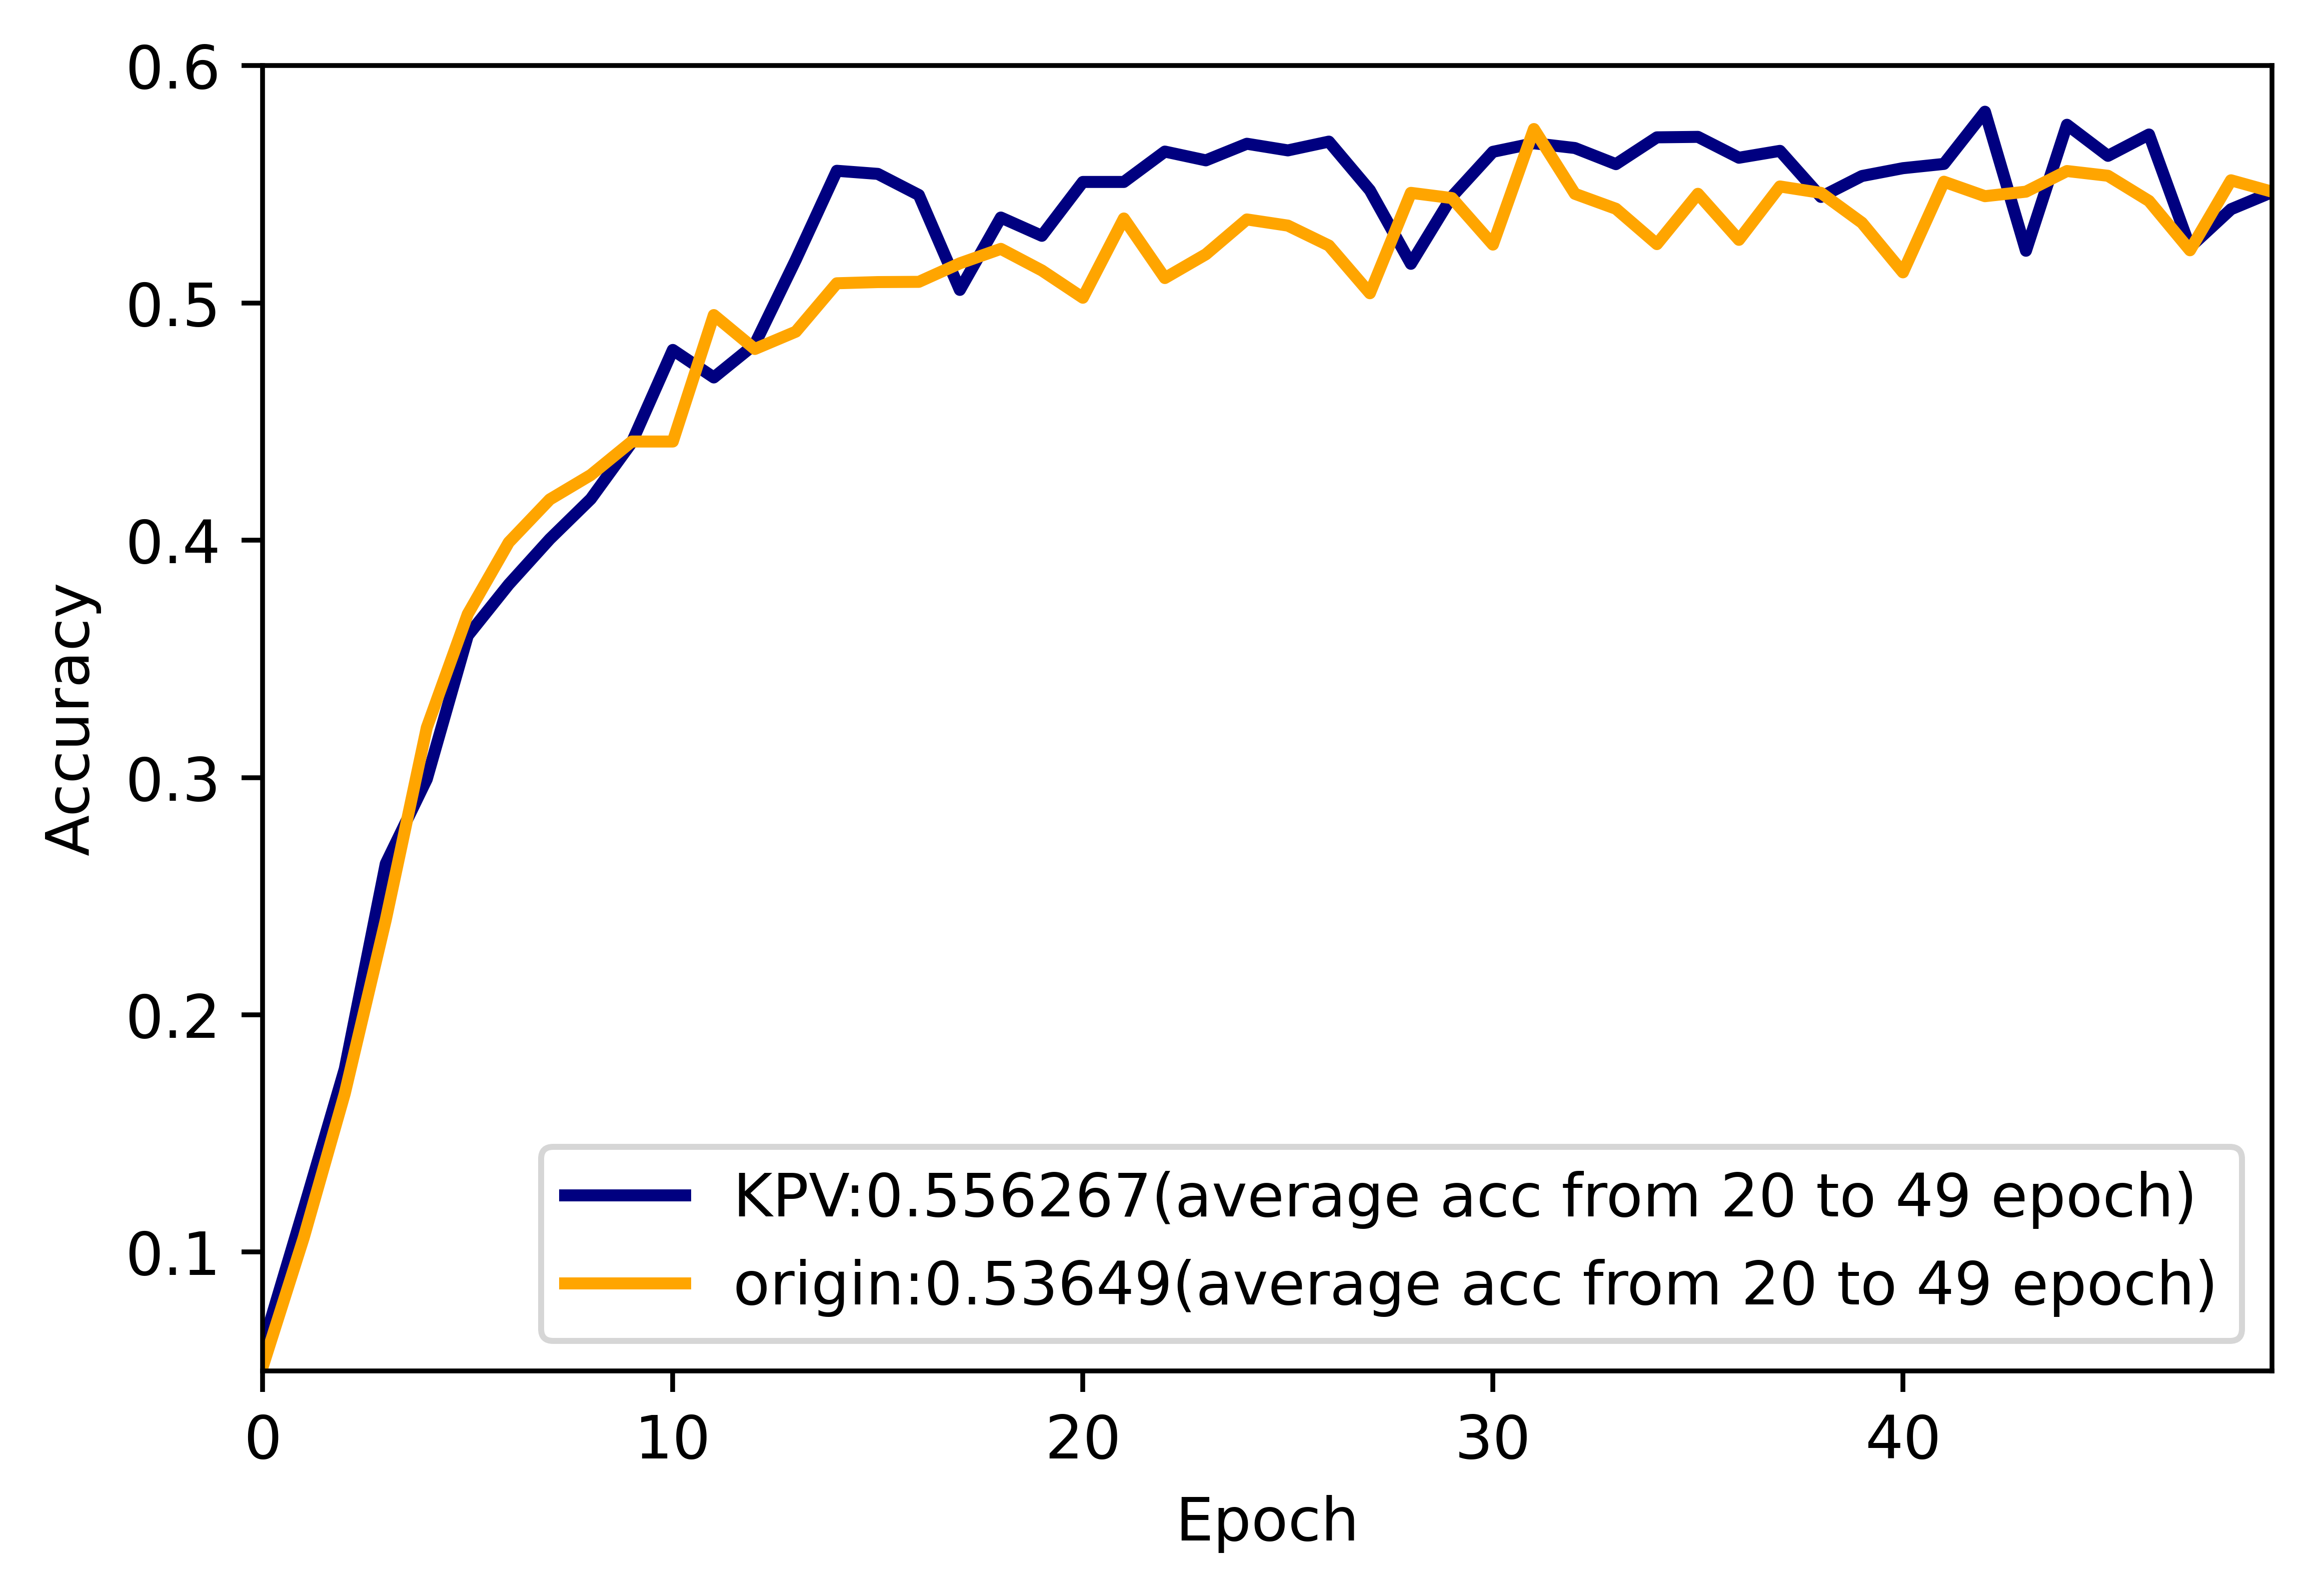

In [15]:
loss = [0.0603, 0.1182, 0.1772, 0.2637, 0.2993, 0.3598, 0.3814, 0.4005, 0.4174, 0.4412, 0.4802, 0.4686, 0.4826, 0.5182, 0.5557, 0.5544, 0.5455, 0.5055, 0.536, 0.5283, 0.551, 0.551, 0.5638, 0.5601, 0.5671, 0.5643, 0.568, 0.5475, 0.5165, 0.5448, 0.5637, 0.5673, 0.5653, 0.5585, 0.5698, 0.57, 0.5612, 0.5641, 0.5447, 0.5535, 0.5568, 0.5586, 0.5806, 0.522, 0.5751, 0.562, 0.571, 0.5235, 0.5395, 0.5467]
origin = [0.0517, 0.1061, 0.1668, 0.24, 0.321, 0.3689, 0.3991, 0.4172, 0.4275, 0.4416, 0.4416, 0.4949, 0.4806, 0.4879, 0.5083, 0.5088, 0.5089, 0.5167, 0.5228, 0.5137, 0.5022, 0.5356, 0.5105, 0.5205, 0.5352, 0.5326, 0.5242, 0.5041, 0.5464, 0.5442, 0.5246, 0.5733, 0.546, 0.5397, 0.5248, 0.546, 0.5266, 0.5491, 0.5464, 0.5338, 0.5129, 0.5511, 0.545, 0.5469, 0.5556, 0.5536, 0.543, 0.5222, 0.5517, 0.5469]
plt.figure(dpi = 864)
#lw = 2
plt.plot(loss, label='KPV:0.556267(average acc from 20 to 49 epoch)', color='navy', linewidth=2)
plt.plot(origin, label='origin:0.53649(average acc from 20 to 49 epoch)', color='orange', linewidth=2)
#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#for i, color in zip(range(3), colors):
#    plt.plot(fpr_dict[i], tpr_dict[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc_dict[i]))
#plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0, 49])
plt.ylim([0.05, 0.6])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc="lower right")
plt.savefig('Iv3acc.jpg')
plt.show()

In [49]:
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [17]:
1/0.00000002

50000000.0

In [22]:
print(50000000*0.5626759182341661)
50000000*0.5600206199360205

28133795.911708303


28001030.996801022

In [23]:
50000000*(0.5626759182341661-0.5600206199360205)

132764.9149072796

In [19]:
1/0.0000001

10000000.0

In [20]:
10000000*(0.5226596026854219-0.5214678347186699)

11917.67966752022